# Crowd Counting

**People counting**, also known as crowd counting, is a common application of computer vision (CV).
People counting is used to count people passing by or to estimate the number of people in an area
Statistics of people counted can be produced to provide insights.

We will use a **RetinaNet model to detect up to 80 standard objects**. Results will be saved into an Azure ML experiment.

## 1. Settings

In [1]:
#!pip install imageai
#!pip install --upgrade tensorflow
#!pip install moviepy
#!pip install xlwt

In [2]:
import os
import cv2
import matplotlib.pyplot as plt
import os.path
import os
import urllib
import datetime
import pandas as pd
import moviepy
from moviepy.editor import *
from imageai.Detection import VideoObjectDetection
import xlwt
from azureml.core.experiment import Experiment
from azureml.core.workspace import Workspace
import time
import seaborn as sns
import random

In [3]:
import sys
print("You are using Python:", sys.version)

You are using Python: 3.6.9 |Anaconda, Inc.| (default, Jul 30 2019, 19:07:31) 
[GCC 7.3.0]


In [8]:
print("Today:", datetime.datetime.now())

Today: 2022-01-25 12:17:28.932551


In [5]:
print("Current directory is:\n", os.getcwd())

Current directory is:
 /mnt/batch/tasks/shared/LS_root/mounts/clusters/seretkow5/code/Users/seretkow/ComputerVision/People Counting and Tracking


In [6]:
import azureml.core
print("Version Azure ML :", azureml.core.VERSION)

Version Azure ML : 1.36.0


In [7]:
import platform,socket,re,uuid,json,psutil,logging

def getSystemInfo():
    try:
        info={}
        info['Platform']=platform.system()
        info['Platform-release']=platform.release()
        info['Platform-version']=platform.version()
        info['Architecture']=platform.machine()
        info['Hostname']=socket.gethostname()
        info['IP-address']=socket.gethostbyname(socket.gethostname())
        info['MAC-address']=':'.join(re.findall('..', '%012x' % uuid.getnode()))
        info['Processeur']=platform.processor()
        info['RAM']=str(round(psutil.virtual_memory().total / (1024.0 **3)))+" Go"
        return json.dumps(info)
    
    except Exception as e:
        logging.exception(e)

json.loads(getSystemInfo())

{'Platform': 'Linux',
 'Platform-release': '5.4.0-1063-azure',
 'Platform-version': '#66~18.04.1-Ubuntu SMP Thu Oct 21 09:59:28 UTC 2021',
 'Architecture': 'x86_64',
 'Hostname': 'seretkow5',
 'IP-address': '127.0.0.1',
 'MAC-address': '57:67:cd:4e:3e:72',
 'Processeur': 'x86_64',
 'RAM': '220 Go'}

In [9]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)

if gpu_info.find('failed') >= 0:
    print('Select an Azure ML GPU compute instance ')
else:
    print(gpu_info)

Tue Jan 25 12:17:33 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.82.01    Driver Version: 470.82.01    CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           On   | 00000001:00:00.0 Off |                    0 |
| N/A   40C    P8    27W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Tesla K80           On   | 00000002:00:00.0 Off |                    0 |
| N/A   

In [10]:
def get_size(bytes, suffix="B"):
    factor = 1024
    for unit in ["", "K", "M", "G", "T", "P"]:
        if bytes < factor:
            return f"{bytes:.2f}{unit}{suffix}"
        bytes /= factor

In [11]:
print("Disk Information")
print("Partitions and Usage:\n")

# get all disk partitions
partitions = psutil.disk_partitions()
for partition in partitions:
    print(f"=== Device: {partition.device} ===")
    print(f"  Mountpoint: {partition.mountpoint}")
    print(f"  File system type: {partition.fstype}")
    print()
    try:
        partition_usage = psutil.disk_usage(partition.mountpoint)
    except PermissionError:
        continue
    print(f"  Total Size: {get_size(partition_usage.total)}")
    print(f"  Used: {get_size(partition_usage.used)}")
    print(f"  Free: {get_size(partition_usage.free)}")
    print(f"  Percentage: {partition_usage.percent}%")
    print()

disk_io = psutil.disk_io_counters()
print(f"Total read: {get_size(disk_io.read_bytes)}")
print(f"Total write: {get_size(disk_io.write_bytes)}")

Disk Information
Partitions and Usage:

=== Device: /dev/sdb1 ===
  Mountpoint: /
  File system type: ext4

  Total Size: 118.07GB
  Used: 57.86GB
  Free: 60.20GB
  Percentage: 49.0%

=== Device: /dev/sdb15 ===
  Mountpoint: /boot/efi
  File system type: vfat

  Total Size: 104.35MB
  Used: 4.36MB
  Free: 100.00MB
  Percentage: 4.2%

=== Device: /dev/sda1 ===
  Mountpoint: /mnt
  File system type: ext4

  Total Size: 1.38TB
  Used: 61.50GB
  Free: 1.25TB
  Percentage: 4.6%

=== Device: /dev/sda1 ===
  Mountpoint: /tmp
  File system type: ext4

  Total Size: 1.38TB
  Used: 61.50GB
  Free: 1.25TB
  Percentage: 4.6%

Total read: 11.39GB
Total write: 29.80GB


In [12]:
ws = Workspace.from_config()
print('Current Azure ML Workspace: ' + ws.name, 
      'Region: ' + ws.location, 
      'Ressource Group: ' + ws.resource_group, sep='\n')

Current Azure ML Workspace: AMLworkshop
Region: westeurope
Ressource Group: AMLworkshop-rg


In [13]:
from azureml.core import experiment
experiment = Experiment(workspace=ws, name="PeopleCounting")

In [14]:
experiment

Name,Workspace,Report Page,Docs Page
PeopleCounting,AMLworkshop,Link to Azure Machine Learning studio,Link to Documentation


## 2. Downloading RetinaNet h5 model file

This ObjectDetection class provides you function to perform object detection on any image or set of images, using pre-trained models that was trained on the COCO dataset. We will use a RetinetNet model.

In [15]:
# Print Current directory
os.getcwd()

'/mnt/batch/tasks/shared/LS_root/mounts/clusters/seretkow5/code/Users/seretkow/ComputerVision/People Counting and Tracking'

In [16]:
def createdir(dirname):
    # Function to create directory if needed
    import os.path
    from os import path
    if path.os.path.isdir(dirname) :
        print("Directory:", dirname, "exists!")
    else:
        print("Creating directory:", dirname)
        os.mkdir(dirname)
        print("Done!")

In [17]:
createdir('resnet50')

Creating directory: resnet50
Done!


In [18]:
if os.path.isfile('resnet50/resnet50_coco_best_v2.1.0.h5'):
    print("resnet50 file is found.")

else:
    print("resnet50 file not there => Let's download it ...\n")
    os.chdir('resnet50')
    
    download_url = 'https://github.com/OlafenwaMoses/ImageAI/releases/download/essentials-v5/resnet50_coco_best_v2.1.0.h5'
    model_file = 'resnet50_coco_best_v2.1.0.h5'
    t1 = datetime.datetime.now()
    print(t1, "Downloading resnet50 file...")
    urllib.request.urlretrieve(download_url, filename = model_file)
    t2 = datetime.datetime.now()
    
    os.chdir('..')
    print("Done in:", t2 - t1)

resnet50 file not there => Let's download it ...

2022-01-25 12:17:40.298744 Downloading resnet50 file...
Done in: 0:00:22.053282


In [19]:
def ts_to_dt(ts):
    return datetime.datetime.fromtimestamp(ts)

for item in os.scandir('resnet50'):
     print(ts_to_dt(item.stat().st_atime), item.stat().st_size, item.name)

2022-01-25 12:18:02.334749 152662144 resnet50_coco_best_v2.1.0.h5


## 3. Analyzing an image

In [20]:
image_file = 'image/crowd.jpg'

In [21]:
# Check image location
for item in os.scandir('image'):
     print(ts_to_dt(item.stat().st_atime), item.stat().st_size, item.name)

2022-01-24 15:54:41.531469 0 .ipynb_checkpoints
2022-01-24 15:54:44.362821 295759 crowd.jpg


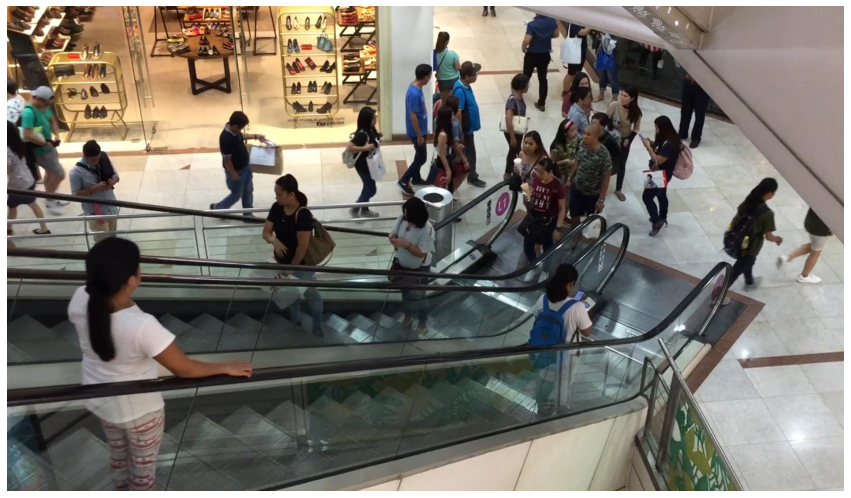

In [22]:
if os.path.exists(image_file) == True :
    img = cv2.imread(image_file)
    plt.figure(figsize=(15,10)) 
    plt.axis('off')
    image_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(image_rgb)

if os.path.exists(image_file) == False :
    print("File", image_file, "did not exist!")

In [23]:
print("Image shape:", img.shape)

Image shape: (881, 1522, 3)


### Calling the Object Detection model

In [24]:
from imageai.Detection import ObjectDetection

detector = ObjectDetection()
detector.setModelTypeAsRetinaNet()
detector.setModelPath("resnet50/resnet50_coco_best_v2.1.0.h5")
detector.loadModel()

In [25]:
detections = detector.detectObjectsFromImage(input_image=image_file, 
                                             output_image_path = "image/result1.jpg")

print("\033[1;31;34m", "Number of detected objects =", len(detections), '\n')

i = 1
for eachObject in detections:
    print("\033[1;31;34m", i, eachObject["name"] , " with confidence =" , eachObject["percentage_probability"] )
    i += 1

 Number of detected objects = 22 

 1 person  with confidence = 90.89946746826172
 2 person  with confidence = 84.9977970123291
 3 person  with confidence = 82.99766778945923
 4 person  with confidence = 77.10983753204346
 5 person  with confidence = 73.68886470794678
 6 person  with confidence = 72.71561622619629
 7 person  with confidence = 69.18348670005798
 8 person  with confidence = 68.30465793609619
 9 person  with confidence = 68.06912422180176
 10 person  with confidence = 67.83004403114319
 11 person  with confidence = 67.19354391098022
 12 person  with confidence = 65.35038352012634
 13 backpack  with confidence = 63.1388783454895
 14 person  with confidence = 62.132060527801514
 15 person  with confidence = 61.712342500686646
 16 handbag  with confidence = 61.33532524108887
 17 person  with confidence = 60.446763038635254
 18 person  with confidence = 58.957284688949585
 19 person  with confidence = 58.82608890533447
 20 person  with confidence = 57.96188712120056
 21 perso

We are going to use now a custom object detection model

In [26]:
# We can list some of the 80 objects we can detect
my_object_list = detector.CustomObjects(person = True)

In [27]:
my_object_list

{'person': 'valid',
 'bicycle': 'invalid',
 'car': 'invalid',
 'motorcycle': 'invalid',
 'airplane': 'invalid',
 'bus': 'invalid',
 'train': 'invalid',
 'truck': 'invalid',
 'boat': 'invalid',
 'traffic light': 'invalid',
 'fire hydrant': 'invalid',
 'stop sign': 'invalid',
 'parking meter': 'invalid',
 'bench': 'invalid',
 'bird': 'invalid',
 'cat': 'invalid',
 'dog': 'invalid',
 'horse': 'invalid',
 'sheep': 'invalid',
 'cow': 'invalid',
 'elephant': 'invalid',
 'bear': 'invalid',
 'zebra': 'invalid',
 'giraffe': 'invalid',
 'backpack': 'invalid',
 'umbrella': 'invalid',
 'handbag': 'invalid',
 'tie': 'invalid',
 'suitcase': 'invalid',
 'frisbee': 'invalid',
 'skis': 'invalid',
 'snowboard': 'invalid',
 'sports ball': 'invalid',
 'kite': 'invalid',
 'baseball bat': 'invalid',
 'baseball glove': 'invalid',
 'skateboard': 'invalid',
 'surfboard': 'invalid',
 'tennis racket': 'invalid',
 'bottle': 'invalid',
 'wine glass': 'invalid',
 'cup': 'invalid',
 'fork': 'invalid',
 'knife': 'inv

In [28]:
img, predictions  = detector.detectCustomObjectsFromImage(input_image = image_file,
                                                          custom_objects = my_object_list,
                                                          input_type="file", 
                                                          output_type="array",
                                                          minimum_percentage_probability = 50,
                                                          display_percentage_probability = True,
                                                          display_object_name = True)

## Results

In [29]:
print("Number of detected objects in the image =", len(predictions))

Number of detected objects in the image = 20


In [30]:
predictions

[{'name': 'person',
  'percentage_probability': 90.89946746826172,
  'box_points': [101, 428, 450, 880]},
 {'name': 'person',
  'percentage_probability': 84.9977970123291,
  'box_points': [1400, 362, 1510, 504]},
 {'name': 'person',
  'percentage_probability': 82.99766778945923,
  'box_points': [366, 188, 462, 377]},
 {'name': 'person',
  'percentage_probability': 77.10983753204346,
  'box_points': [1309, 316, 1405, 524]},
 {'name': 'person',
  'percentage_probability': 73.68886470794678,
  'box_points': [947, 466, 1074, 625]},
 {'name': 'person',
  'percentage_probability': 72.71561622619629,
  'box_points': [932, 13, 1005, 189]},
 {'name': 'person',
  'percentage_probability': 69.18348670005798,
  'box_points': [1151, 186, 1230, 419]},
 {'name': 'person',
  'percentage_probability': 68.30465793609619,
  'box_points': [112, 244, 207, 423]},
 {'name': 'person',
  'percentage_probability': 68.06912422180176,
  'box_points': [612, 179, 685, 388]},
 {'name': 'person',
  'percentage_probab

In [31]:
print("\033[1;31;34mTotal of detected objects =", len(predictions), '\n')

i = 1
nb_people = 0

for key in predictions:
    print("Object", i, ':', str.upper(key['name']), round(key['percentage_probability']/100, 5), 
          '\nBBox:', key['box_points'], '\n')
    if key['name'] == 'person':
        nb_people +=1
    i +=1

print(">> Number of persons in the image =", nb_people)

Total of detected objects = 20 

Object 1 : PERSON 0.90899 
BBox: [101, 428, 450, 880] 

Object 2 : PERSON 0.84998 
BBox: [1400, 362, 1510, 504] 

Object 3 : PERSON 0.82998 
BBox: [366, 188, 462, 377] 

Object 4 : PERSON 0.7711 
BBox: [1309, 316, 1405, 524] 

Object 5 : PERSON 0.73689 
BBox: [947, 466, 1074, 625] 

Object 6 : PERSON 0.72716 
BBox: [932, 13, 1005, 189] 

Object 7 : PERSON 0.69183 
BBox: [1151, 186, 1230, 419] 

Object 8 : PERSON 0.68305 
BBox: [112, 244, 207, 423] 

Object 9 : PERSON 0.68069 
BBox: [612, 179, 685, 388] 

Object 10 : PERSON 0.6783 
BBox: [465, 305, 600, 495] 

Object 11 : PERSON 0.67194 
BBox: [1220, 112, 1281, 256] 

Object 12 : PERSON 0.6535 
BBox: [926, 273, 1017, 467] 

Object 13 : PERSON 0.62132 
BBox: [1017, 200, 1107, 394] 

Object 14 : PERSON 0.61712 
BBox: [23, 134, 111, 388] 

Object 15 : PERSON 0.60447 
BBox: [808, 102, 872, 329] 

Object 16 : PERSON 0.58957 
BBox: [0, 170, 82, 416] 

Object 17 : PERSON 0.58826 
BBox: [692, 348, 784, 590] 

Ob

True

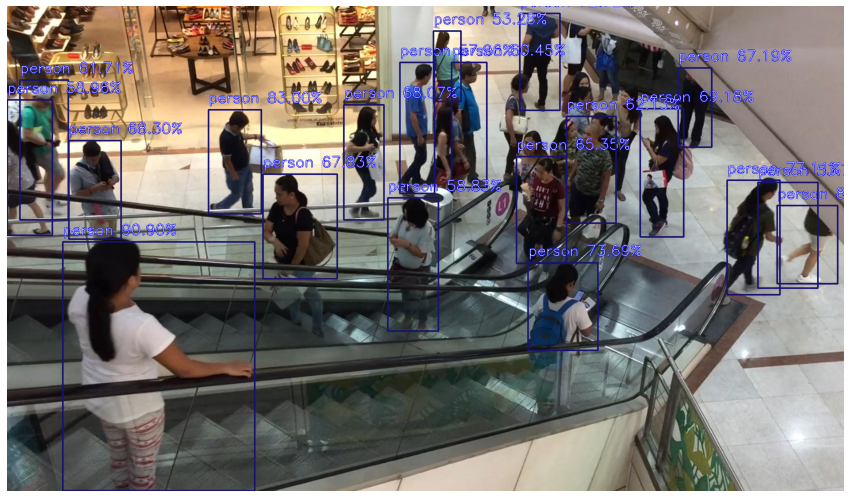

In [32]:
processedimage_file = "image/result2.jpg"

plt.figure(figsize=(15,10)) 
plt.axis('off')
image_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(image_rgb)
cv2.imwrite(processedimage_file, img)

## 4. Video analytics

In [33]:
VIDEOFILE = 'video/crowd.mp4'

In [34]:
for item in os.scandir('video'):
     print(ts_to_dt(item.stat().st_atime), item.stat().st_size, item.name)

2022-01-24 20:34:24.141158 0 .ipynb_checkpoints
2022-01-24 20:34:20.108501 5536475 crowd.mp4


In [1]:
# Viewing the video output
#videoresult = VideoFileClip(VIDEOFILE)
#videoresult.ipython_display(width = 640, height = 480)

In [36]:
MYVIDEOFILE = VideoFileClip(VIDEOFILE)

fps = MYVIDEOFILE.fps
w = MYVIDEOFILE.w
h = MYVIDEOFILE.h
duration = MYVIDEOFILE.duration
nbframes = int(fps * duration)

print("\033[1;31;34mVideo File :", VIDEOFILE)
print("\n- Width:", w, "\n- Height:", h)
print("- FPS =", round(fps))
print("- Duration in seconds :", duration)
print("- Number of frames =", nbframes)

Video File : video/crowd.mp4

- Width: 1920 
- Height: 1080
- FPS = 25
- Duration in seconds : 13.64
- Number of frames = 341


## 5. Analysing a video file or a streaming video

> Let's use now the same video but with a different time length. We have an initial long video. **So we will create first a video clip in order to reduce the time**. We will not analyse all the frames (we have a FPS = 30). We can decide to extract only some frames. 

**Some results will be saved into Azure ML experiments.**

In [37]:
# Directories to create if needed
DIR1 = 'results'
DIR2 = 'results/captures'
OUTPUTDIR = 'output'

createdir(DIR1)
createdir(DIR2)
createdir(OUTPUTDIR)

Creating directory: results
Done!
Creating directory: results/captures
Done!
Creating directory: output
Done!


In [38]:
for root, _, files in os.walk(DIR1):
    print("Directory:", root, "with", len(files), "files.")

Directory: results with 0 files.
Directory: results/captures with 0 files.


In [39]:
for root, _, files in os.walk(OUTPUTDIR):
    print("Directory:", root, "with", len(files), "files.")

Directory: output with 0 files.


### We will create a new videoclip from the initial video

In [40]:
startvideo = 1 # in seconds
endvideo = 12  # in seconds

In [41]:
MYVIDEOFILE = VideoFileClip(VIDEOFILE)
MYCLIP = MYVIDEOFILE.subclip(startvideo, endvideo)

clipduration = MYCLIP.duration # Compute the duration in secs
print("Clip duration =", clipduration, 'seconds')

Clip duration = 11 seconds


In [42]:
# Saving the sample video
MYCLIPNAME = OUTPUTDIR + "/sample.mp4"
MYCLIP.write_videofile(MYCLIPNAME)

Moviepy - Building video output/sample.mp4.
Moviepy - Writing video output/sample.mp4



Moviepy - Done !
Moviepy - video ready output/sample.mp4


In [43]:
for item in os.scandir(OUTPUTDIR):
     print(ts_to_dt(item.stat().st_atime), item.stat().st_size, item.name)

2022-01-25 12:19:41.740628 5007790 sample.mp4


### Settings

In [44]:
# Sampling frame (number of extracted frame)
sampling_frames = 1 # so 25 frames for each 1 second (we have here FPS = 25)
#sampling_frames = 25 # so 1 frame every second (FPS=25)

# Min confidence in % for object detection ie 20 or 50
minpctprob = 40

# Low & high limit for people class (Light, Moderate, Heavy)
low_limit = 32
high_limit = 40

# Width & Height of the video
MYVIDEOFILE = VideoFileClip(MYCLIPNAME)
w = MYVIDEOFILE.w
h = MYVIDEOFILE.h

In [45]:
MYVIDEOFILE = VideoFileClip(MYCLIPNAME)

fps = MYVIDEOFILE.fps
duration = MYVIDEOFILE.duration
nbframes = int(fps * duration)
duration_sec = duration
nbprocessedframes = nbframes / sampling_frames
nbframespersec = sampling_frames / fps

print("\033[1;31;34mVideo Clip:", MYCLIPNAME)
print("- Video input size: width =", w, "height =", h)
print("- FPS =", round(fps))
print("- Duration in seconds =", duration_sec)
print("- Number of frames =", nbframes)

print("\nSetting: Min confidence in % =", minpctprob)

print("\nOutput:")
print("- Sampling Frames =", sampling_frames)
print("- Number of frames to analyse =", int(nbprocessedframes))
print("- Video will be processed each", round(nbframespersec, 2), "seconds")

Video Clip: output/sample.mp4
- Video input size: width = 1920 height = 1080
- FPS = 25
- Duration in seconds = 11.0
- Number of frames = 275

Setting: Min confidence in % = 40

Output:
- Sampling Frames = 1
- Number of frames to analyse = 275
- Video will be processed each 0.04 seconds


### Processing the video

Only detecting persons from the video

In [46]:
video_object_list = detector.CustomObjects(person = True)
video_object_list['person']

'valid'

In [47]:
from imageai.Detection import ObjectDetection

detector = ObjectDetection()
detector.setModelTypeAsRetinaNet()
detector.setModelPath("resnet50/resnet50_coco_best_v2.1.0.h5")
detector.loadModel()

In [48]:
WEBCAM = OUTPUTDIR + "/sample.mp4" # Or you can use a RTSP link to connec to a webcam or a live video camera

if os.path.exists(WEBCAM) == True :
    print("File", WEBCAM, "exists")
    for item in os.scandir(OUTPUTDIR):
         print(ts_to_dt(item.stat().st_atime), item.stat().st_size, item.name)
if os.path.exists(WEBCAM) == False :
    print("File", WEBCAM, "did not exist!")

File output/sample.mp4 exists
2022-01-25 12:19:41.740628 5007790 sample.mp4


Processing the video:  output/sample.mp4 for every 1 frame(s) 

2022-01-25 12:20:24.387920 Processing frame = 000000001 / 275 

 -------------------- Detected objects -------------------- 

1 	 PERSON   0.89679  Bounding Box: [1489, 398, 1562, 562]
2 	 PERSON   0.89103  Bounding Box: [928, 212, 987, 350]
3 	 PERSON   0.85166  Bounding Box: [1500, 556, 1583, 740]
4 	 PERSON   0.83303  Bounding Box: [1316, 710, 1418, 879]
5 	 PERSON   0.82092  Bounding Box: [674, 528, 746, 722]
6 	 PERSON   0.81989  Bounding Box: [233, 520, 305, 701]
7 	 PERSON   0.81974  Bounding Box: [80, 828, 182, 995]
8 	 PERSON   0.81749  Bounding Box: [702, 176, 758, 313]
9 	 PERSON   0.81442  Bounding Box: [1807, 181, 1867, 312]
10 	 PERSON   0.80017  Bounding Box: [1627, 22, 1667, 137]
11 	 PERSON   0.79887  Bounding Box: [1094, 75, 1139, 186]
12 	 PERSON   0.78382  Bounding Box: [988, 130, 1046, 277]
13 	 PERSON   0.78144  Bounding Box: [758, 371, 814, 524]
14 	 PERSON   0.74655  Bounding Box: [1108, 800, 1204, 

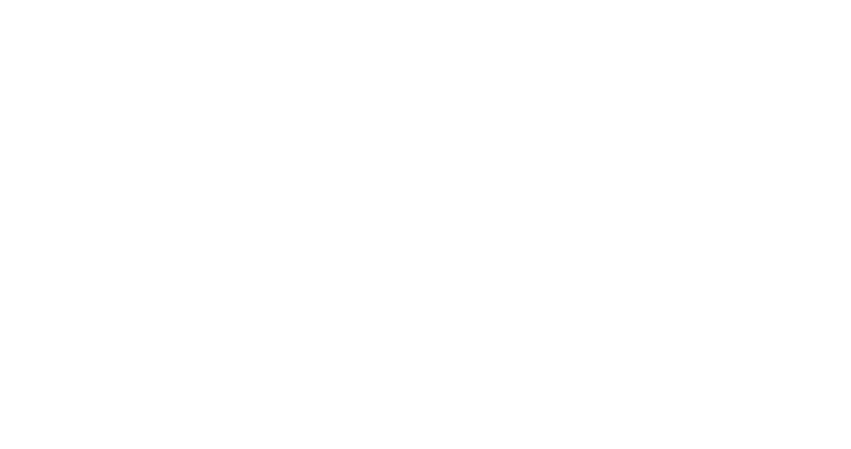

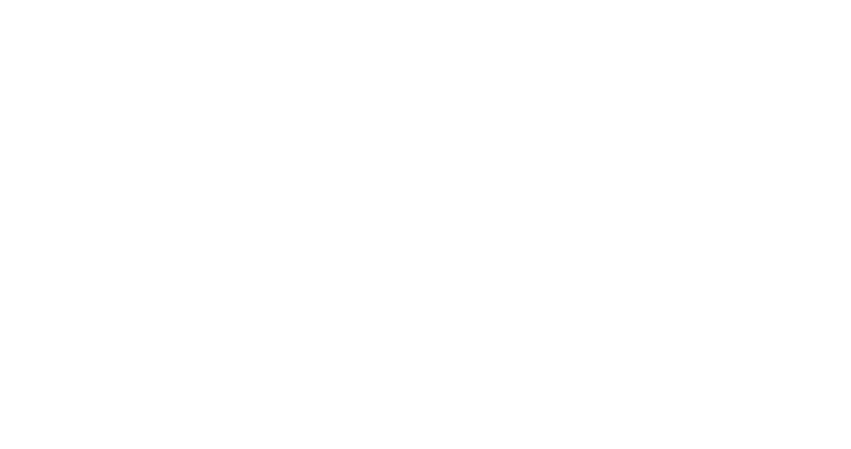

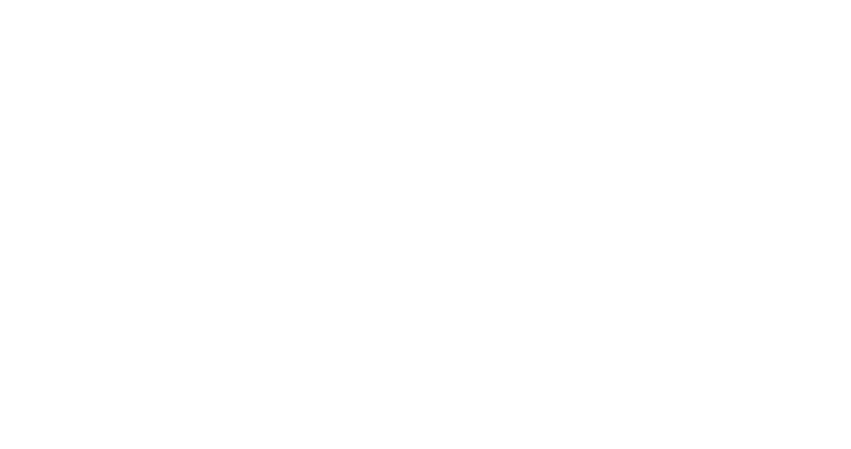

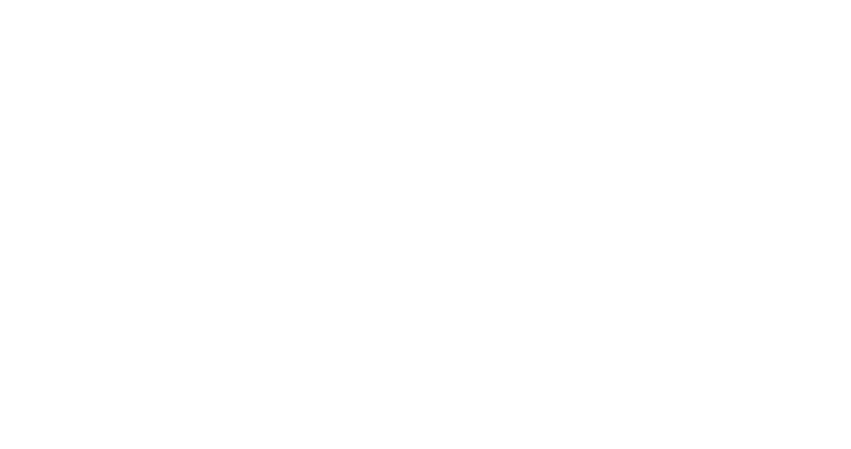

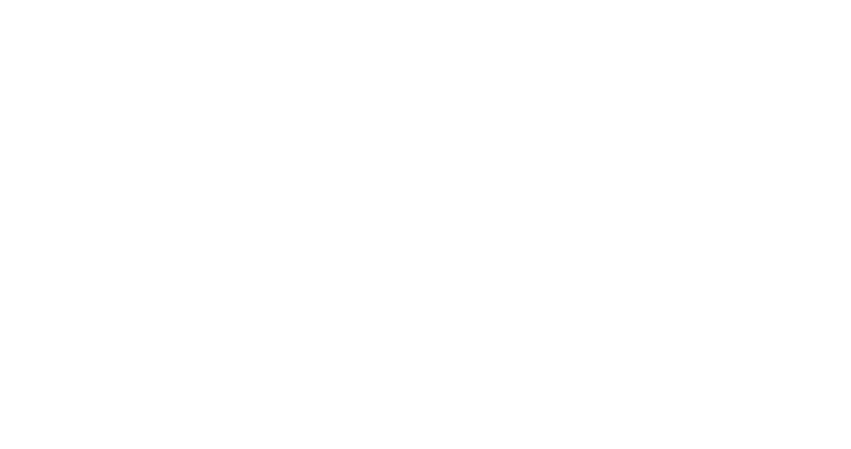

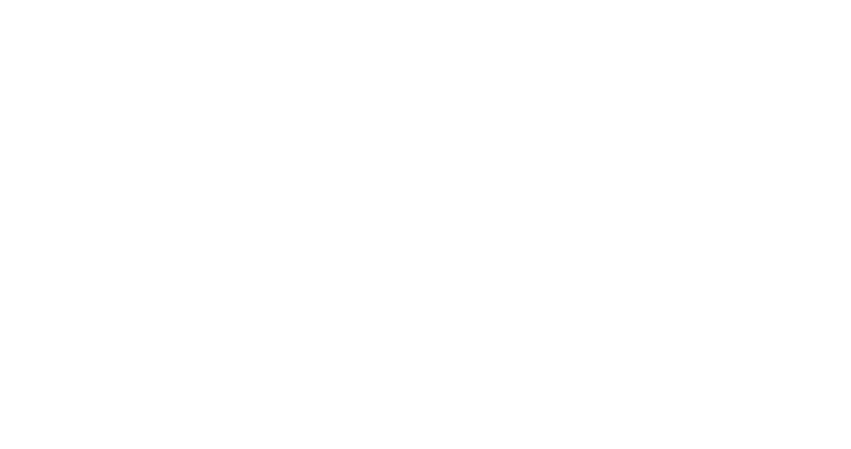

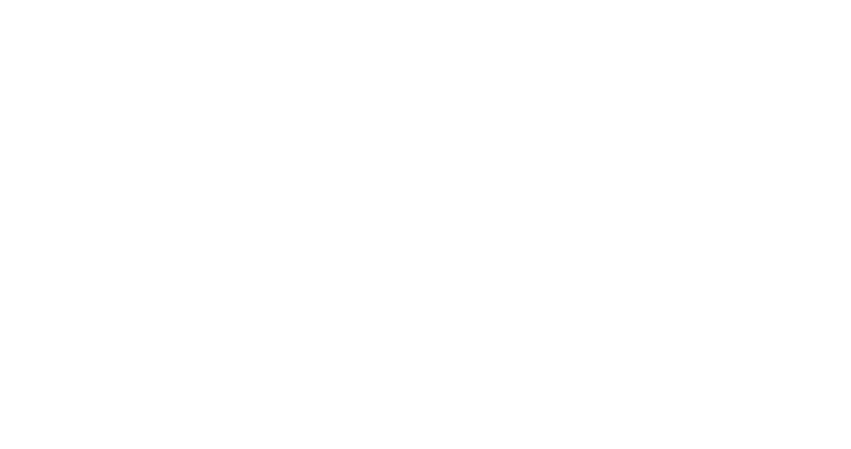

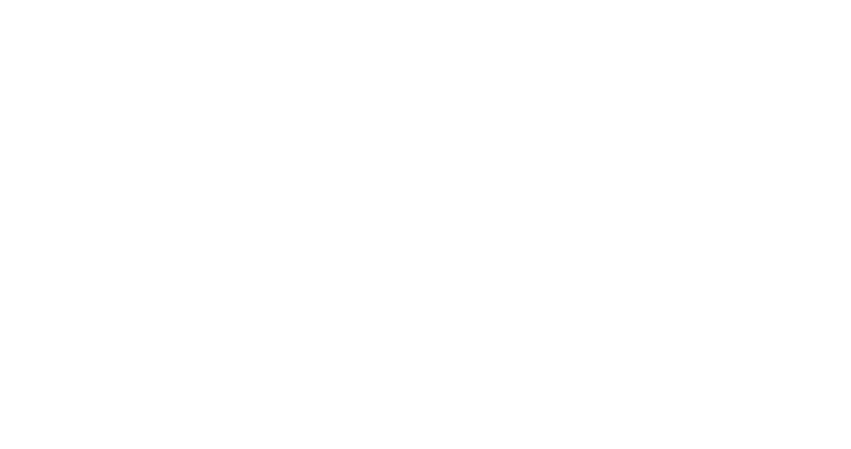

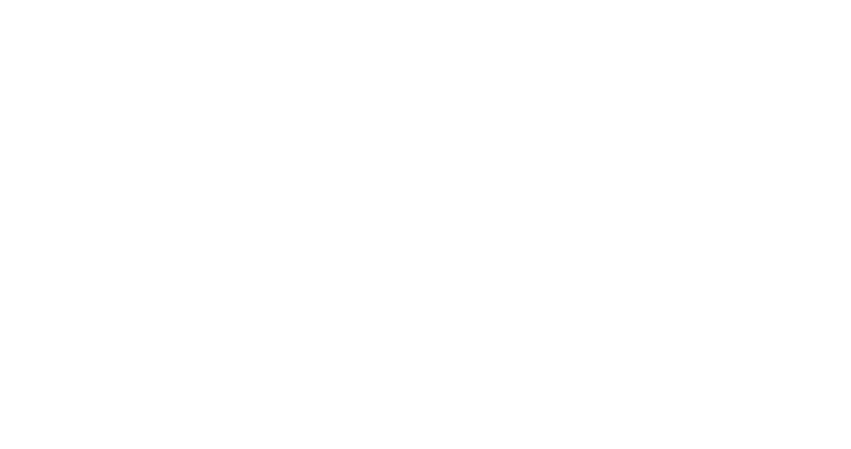

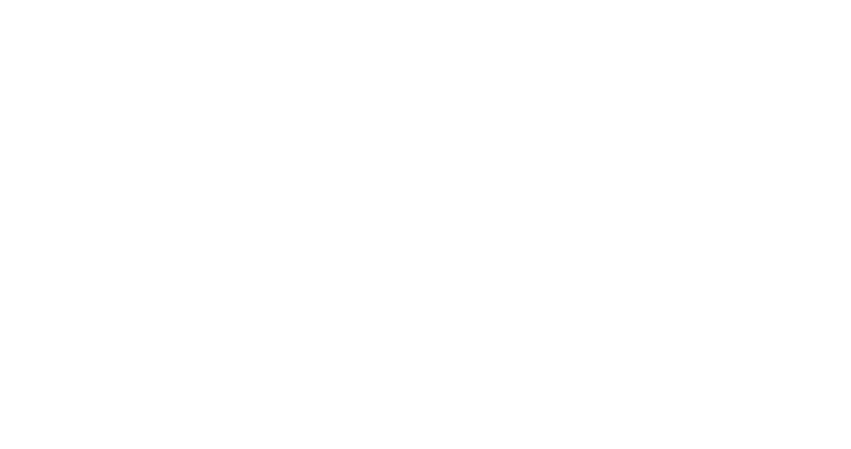

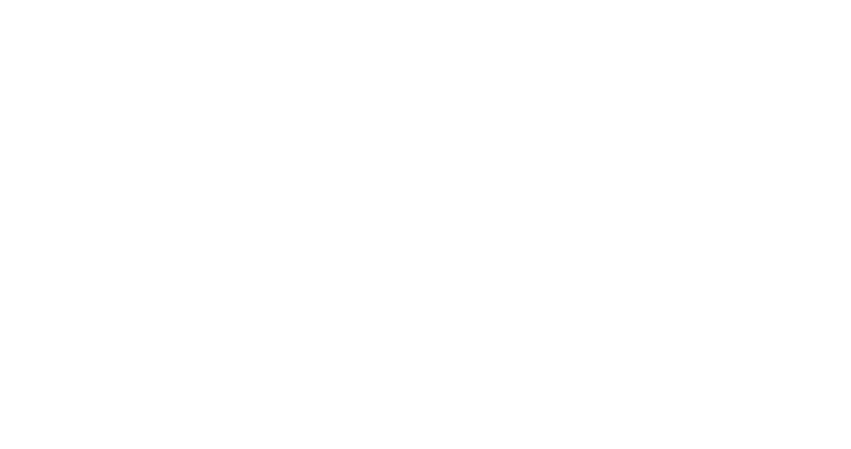

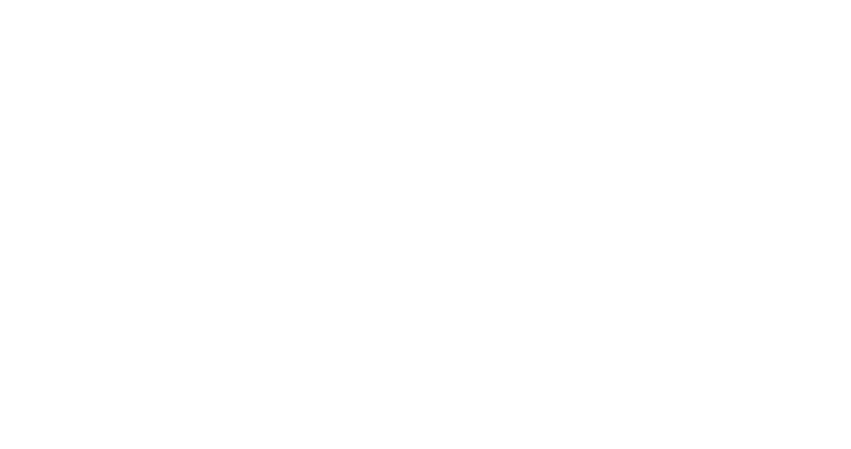

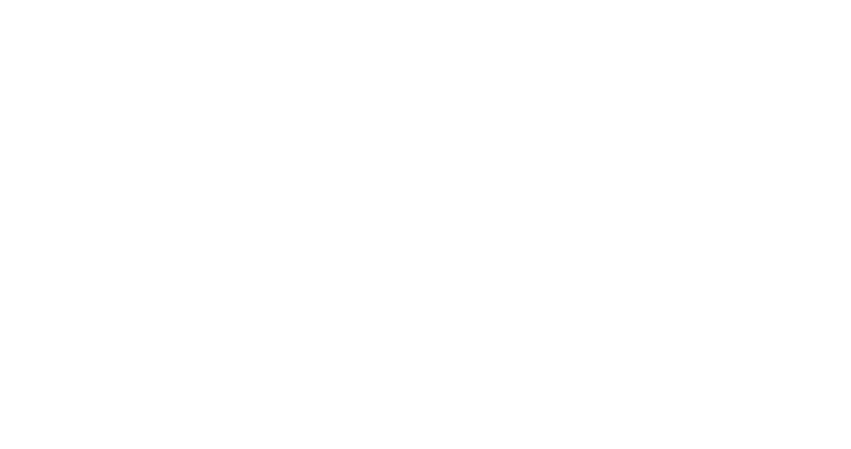

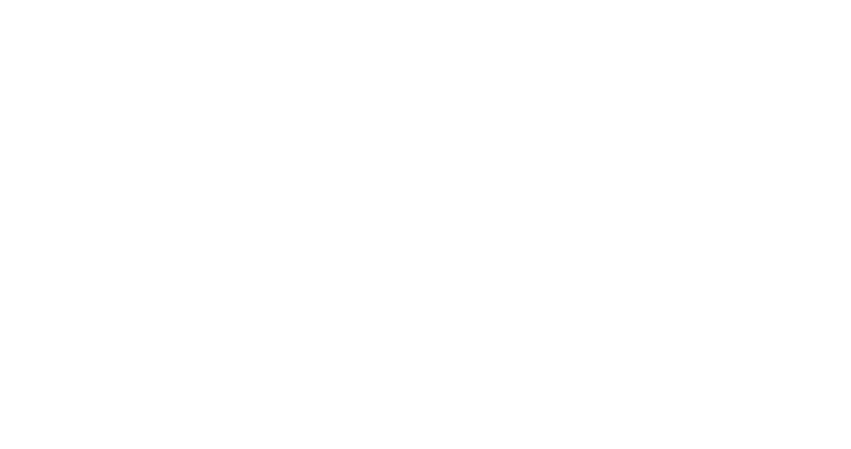

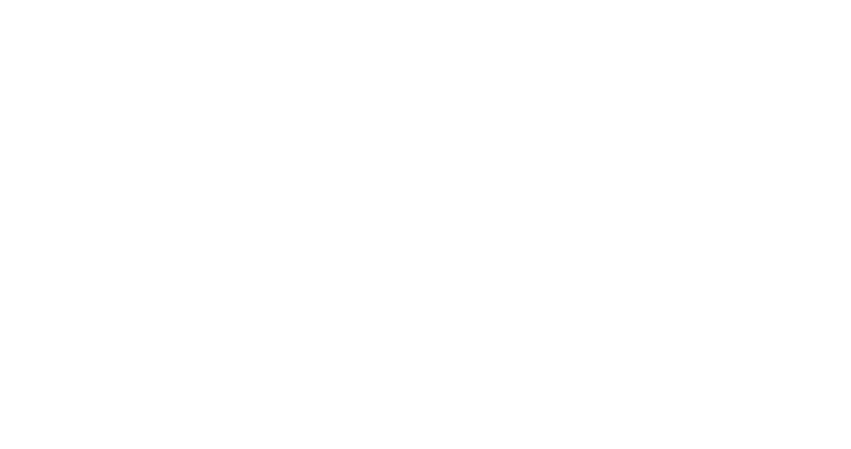

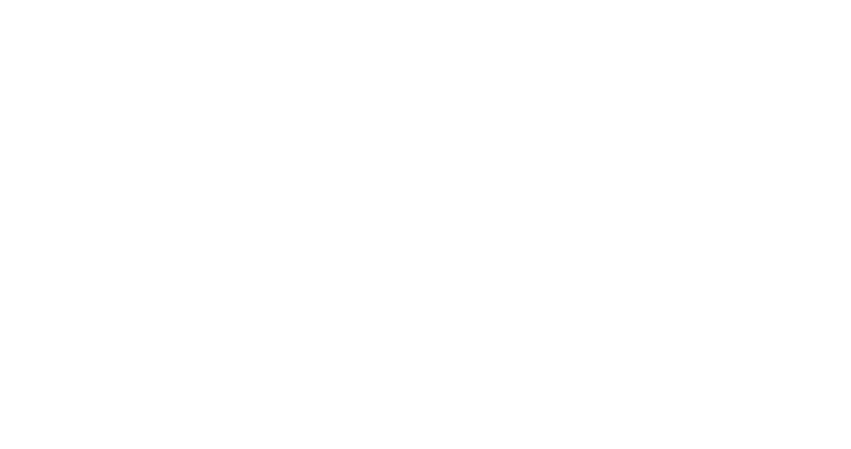

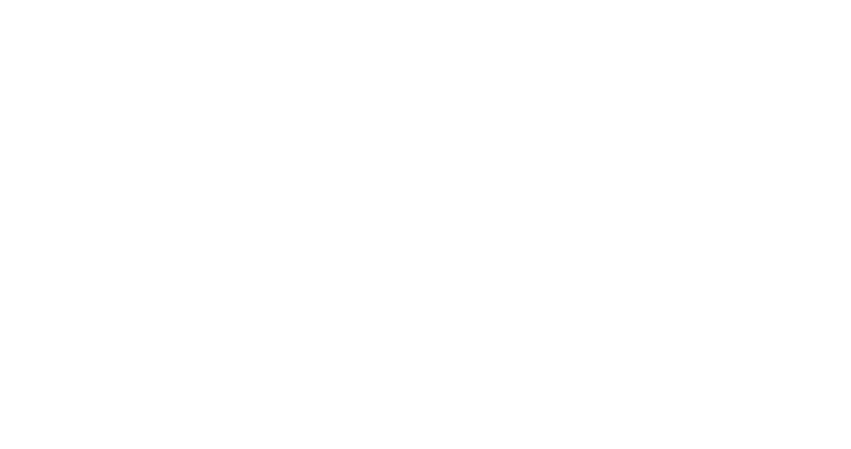

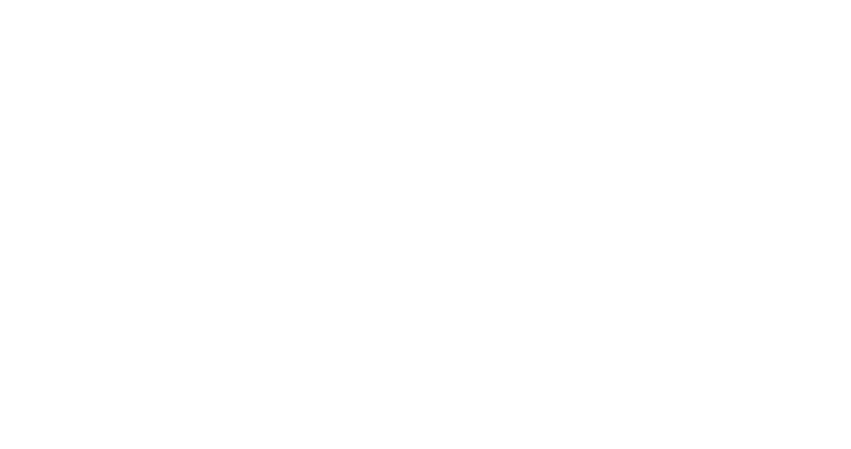

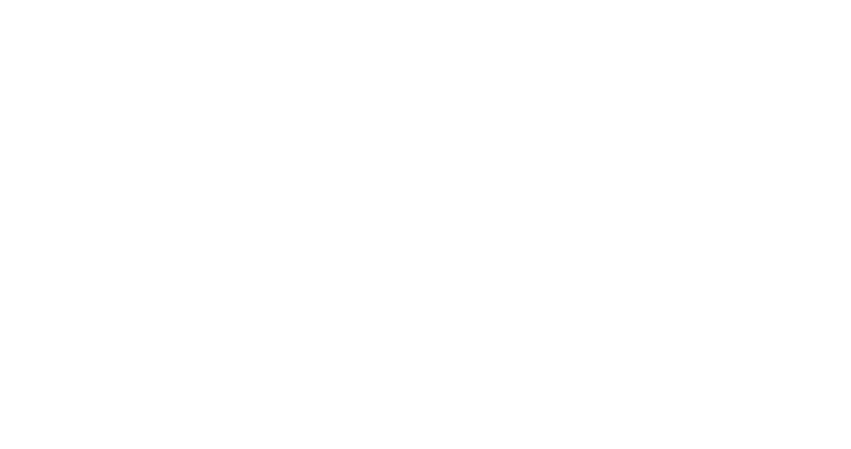

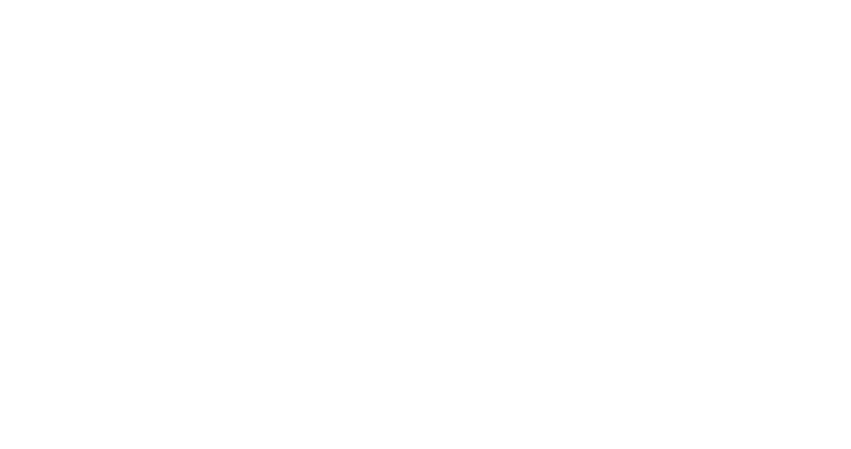

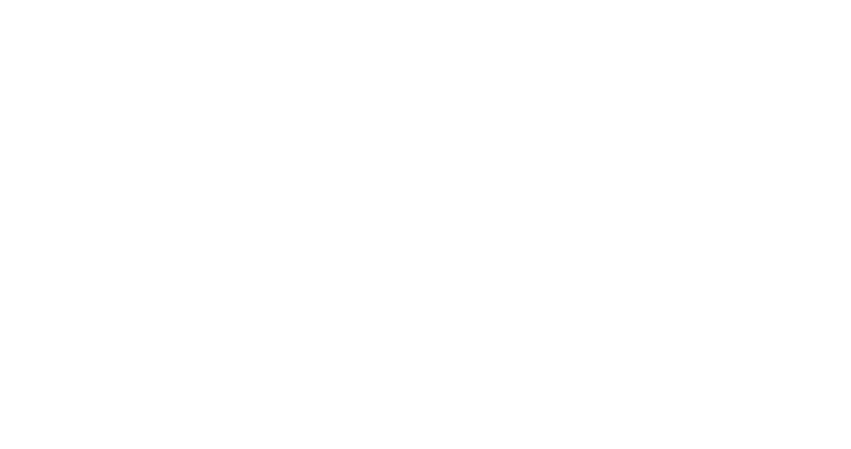

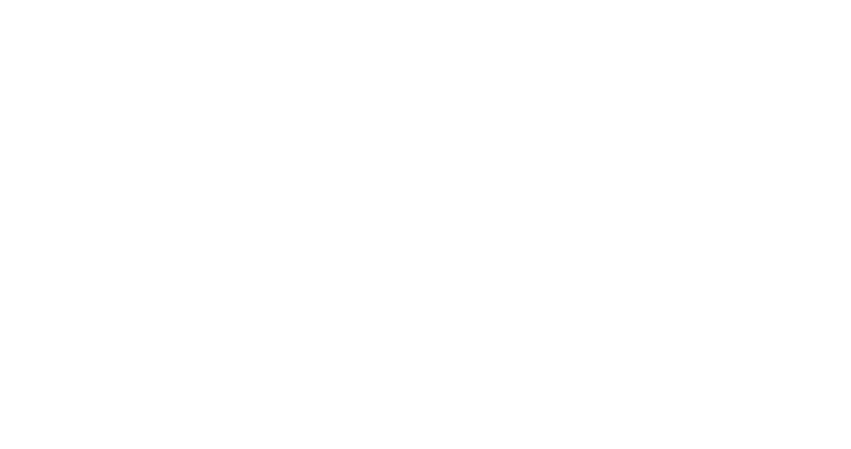

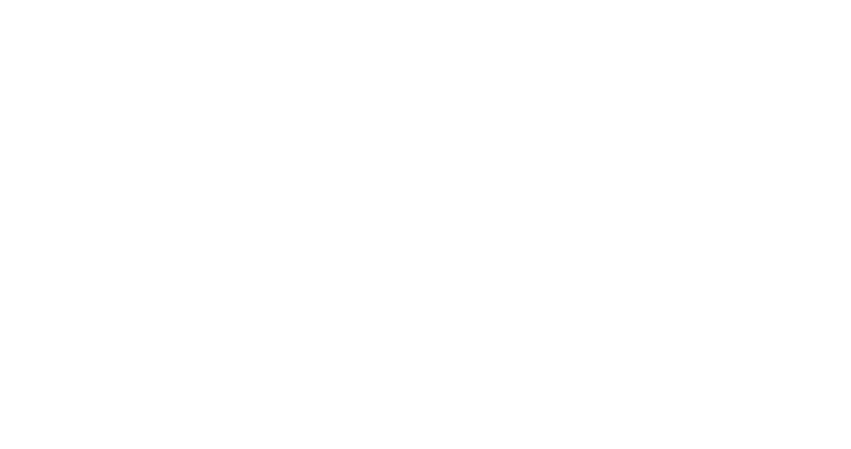

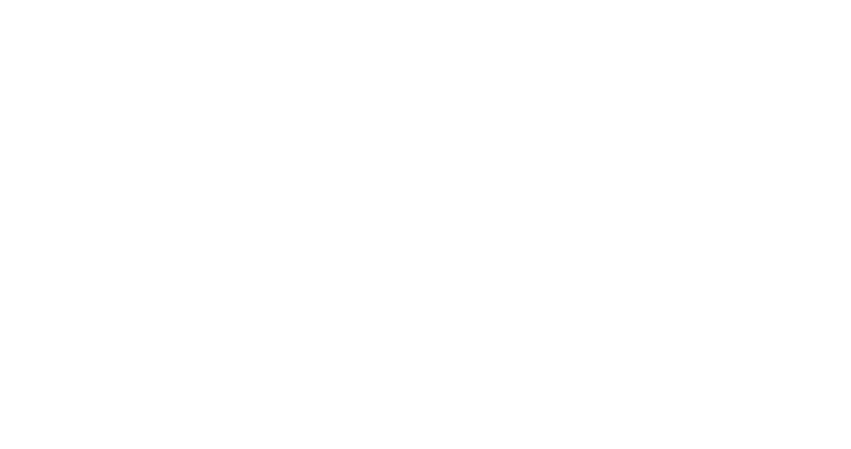

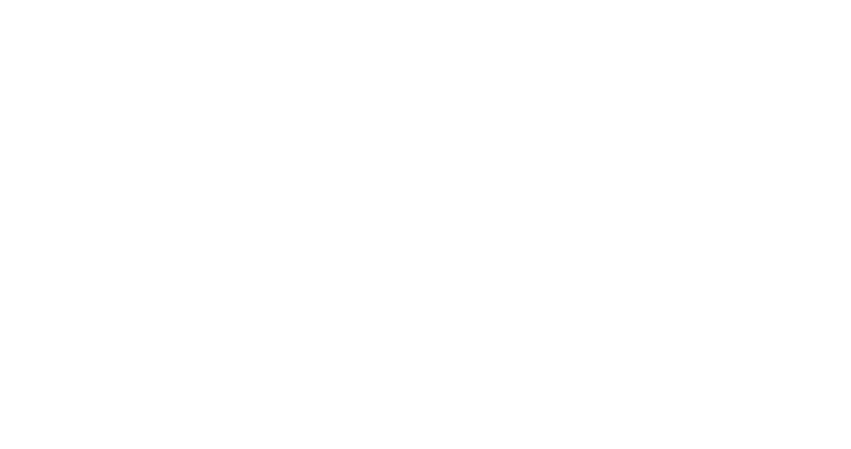

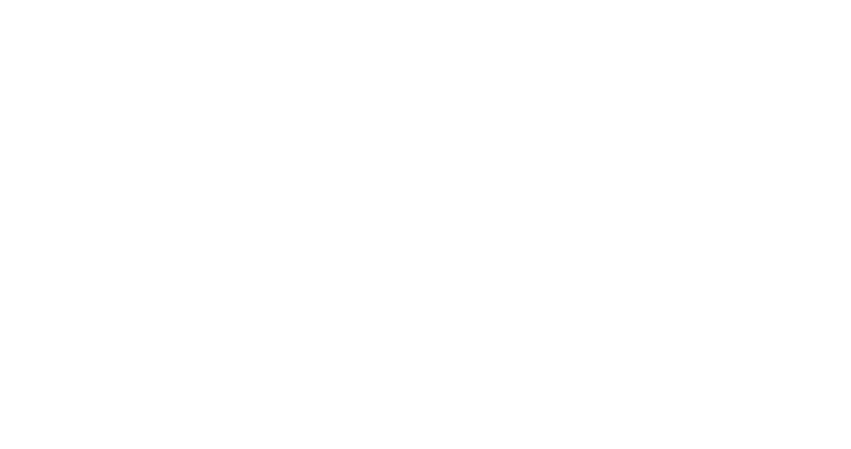

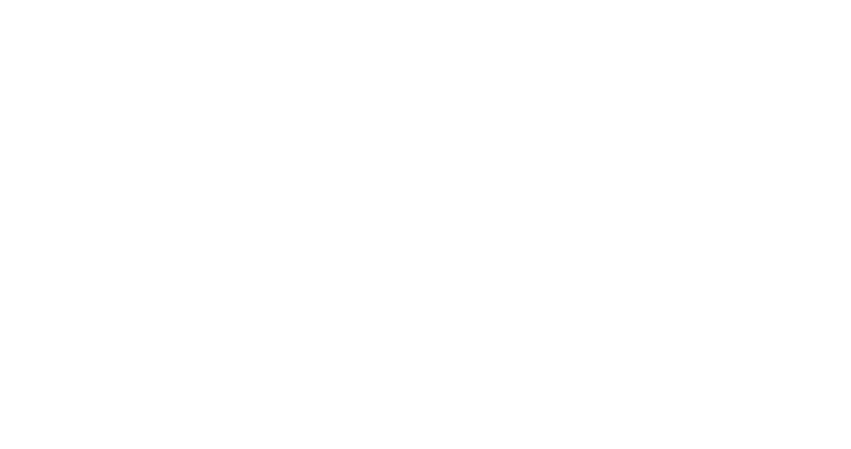

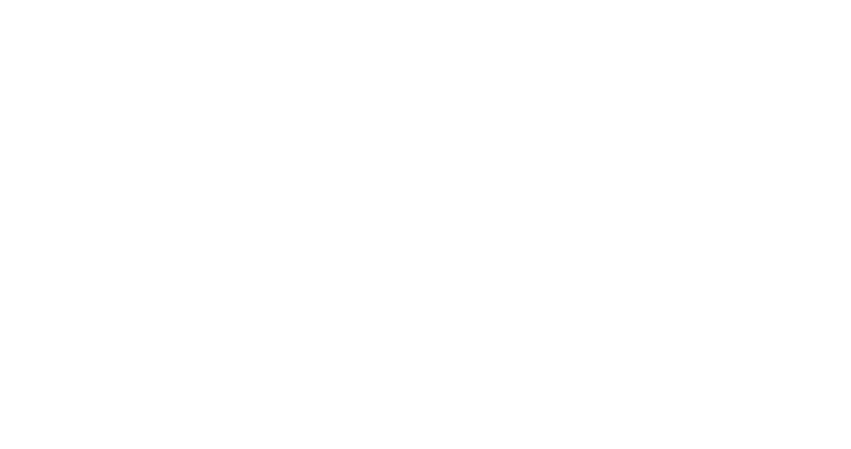

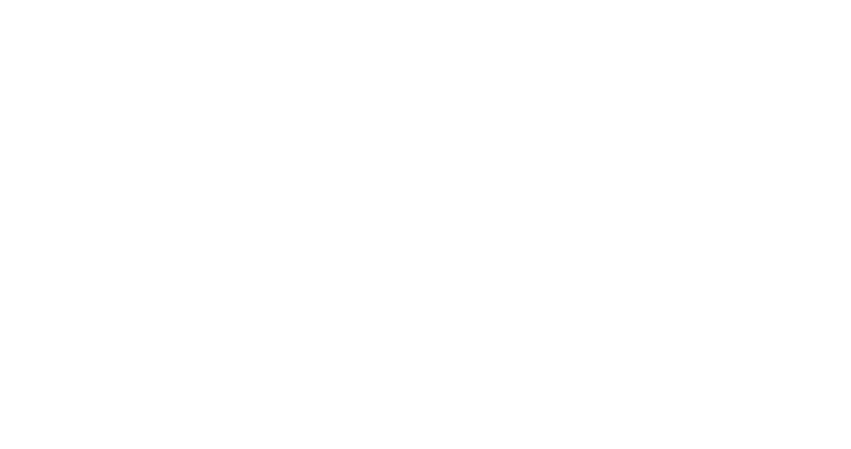

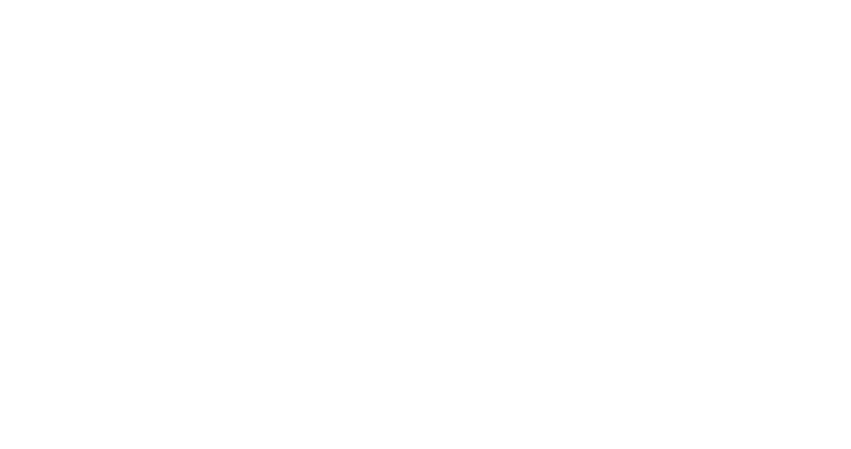

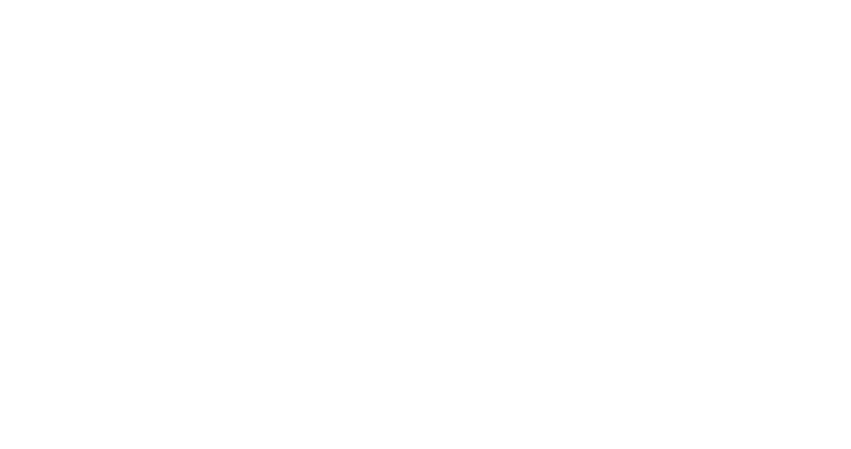

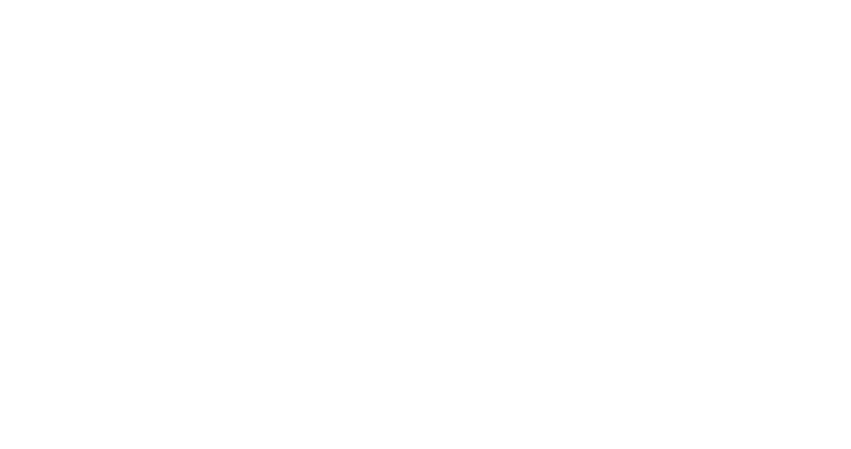

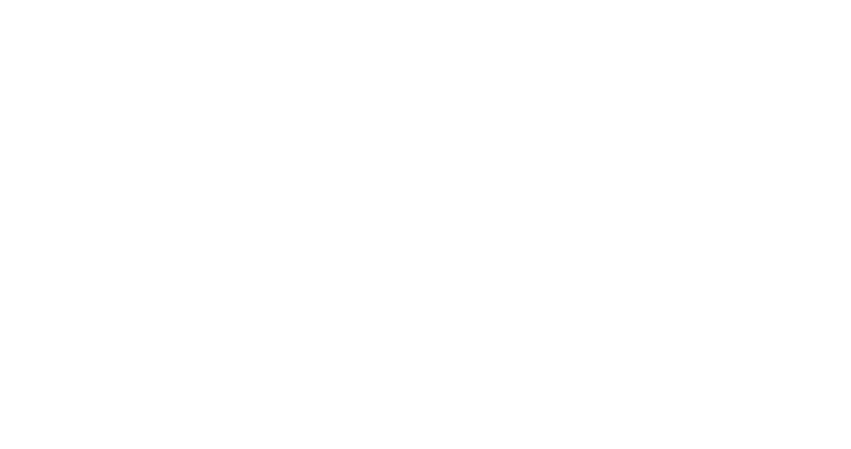

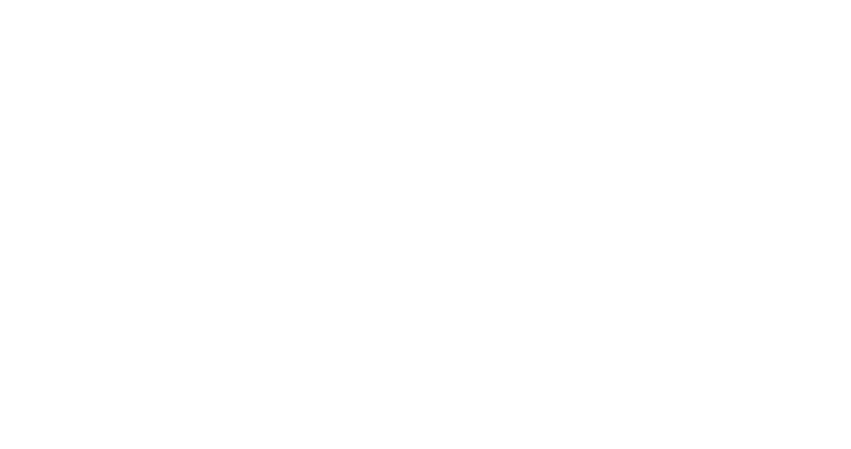

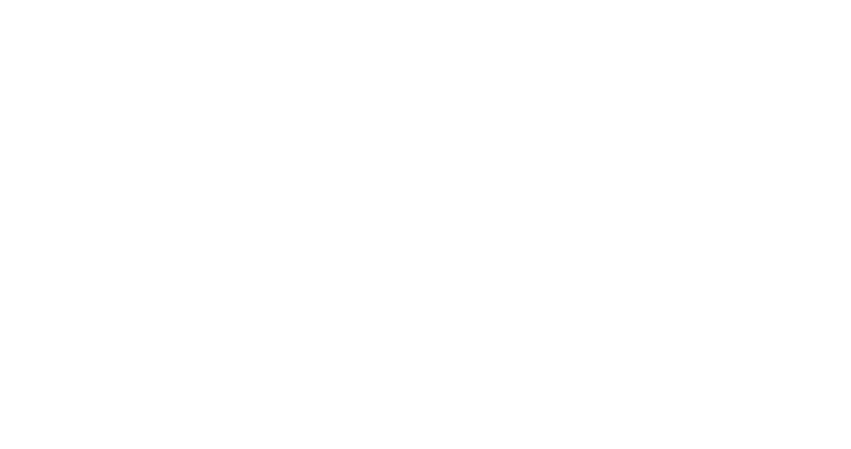

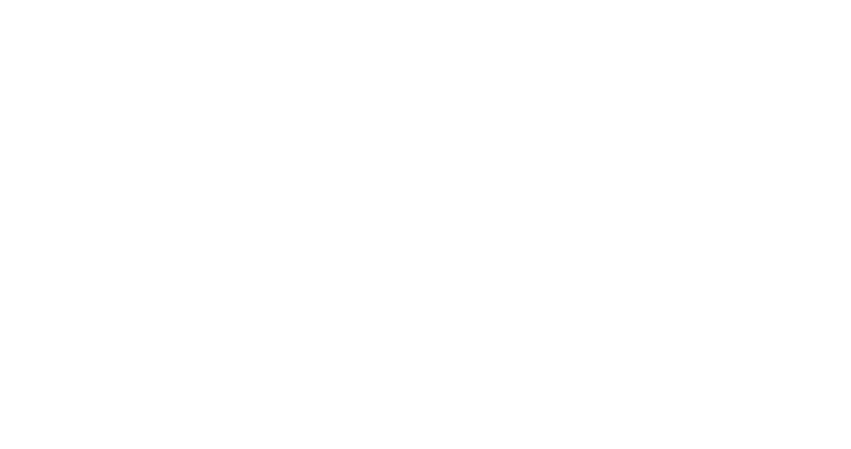

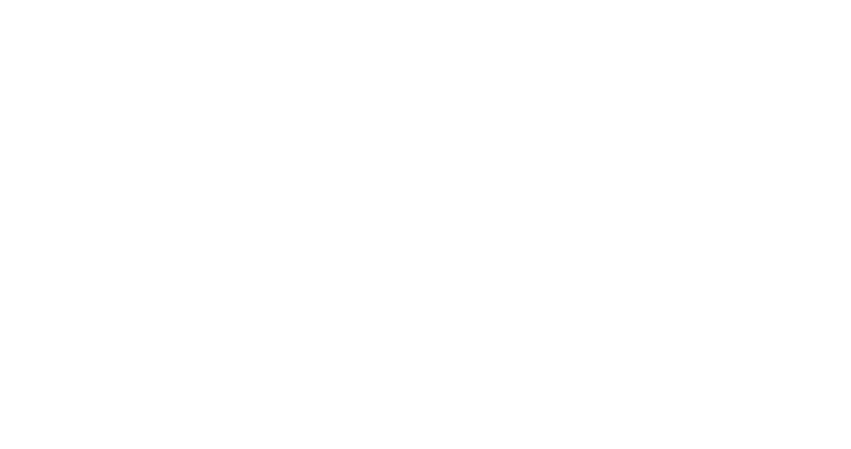

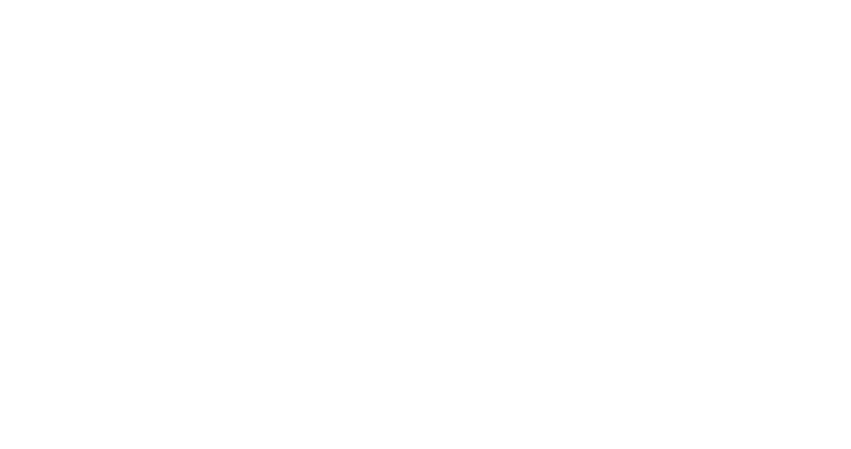

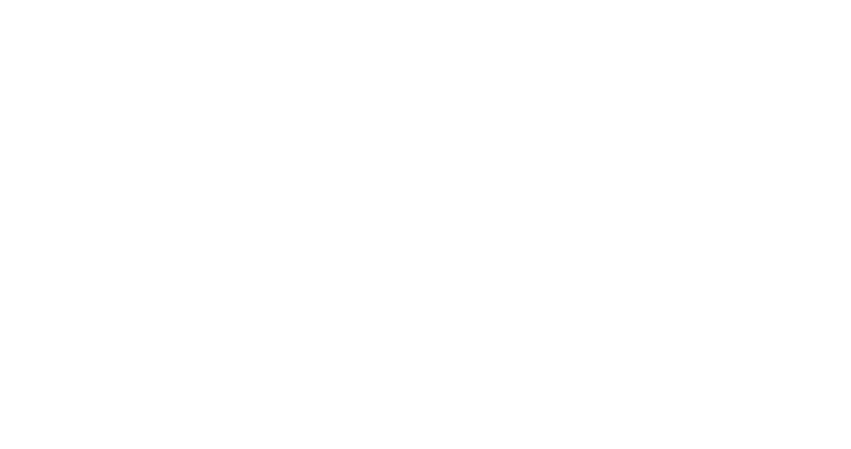

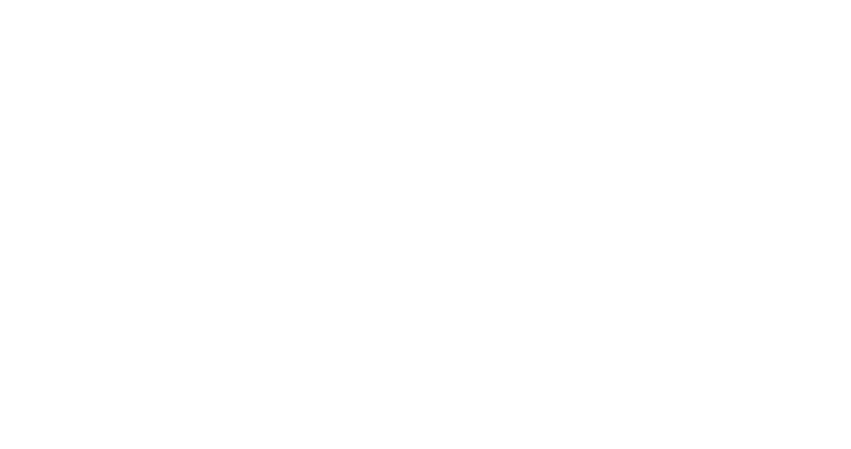

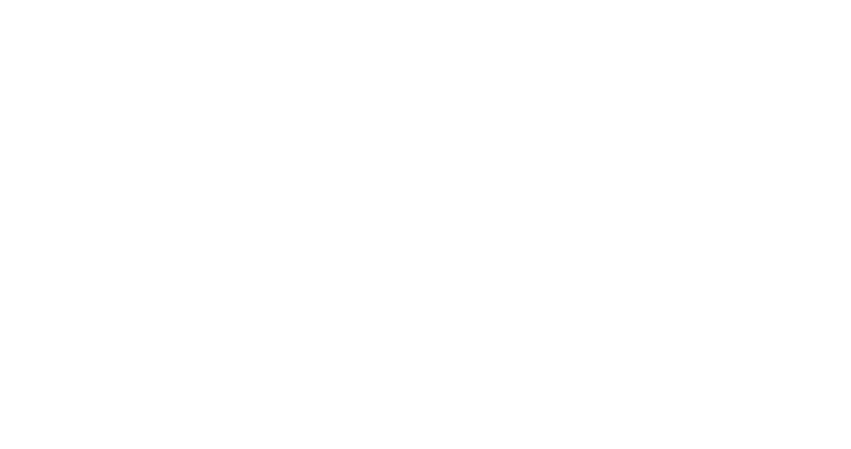

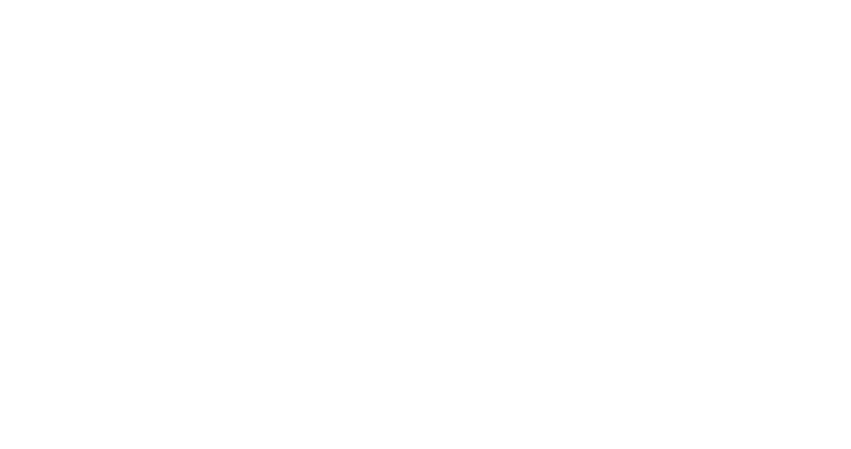

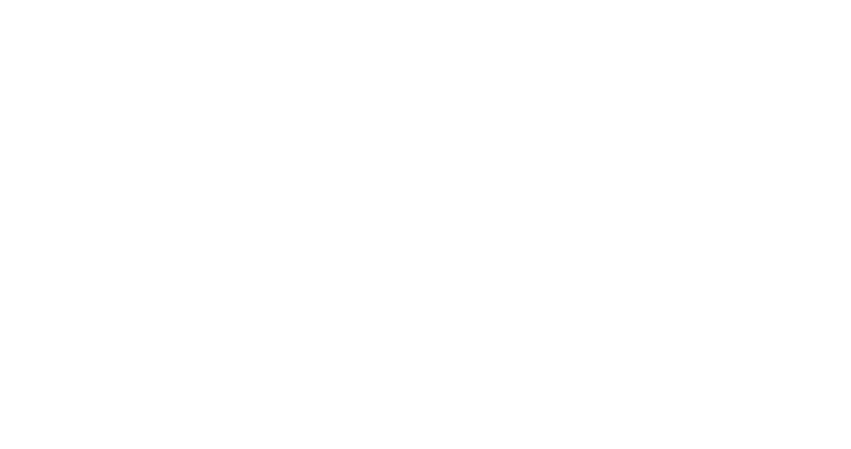

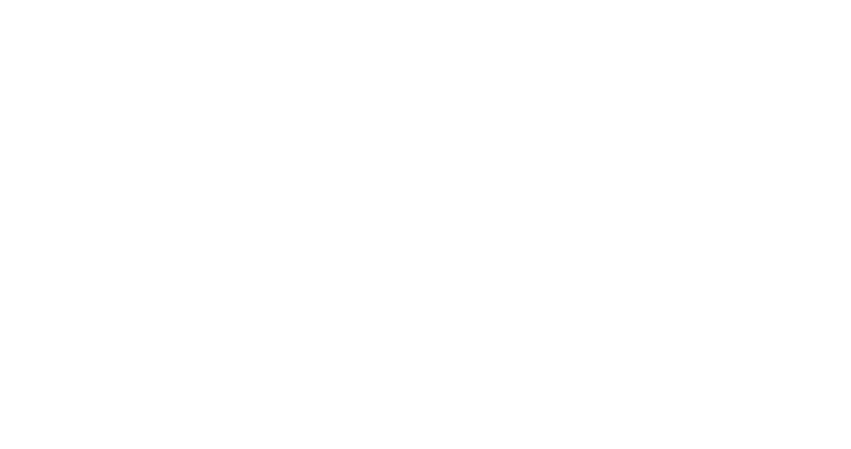

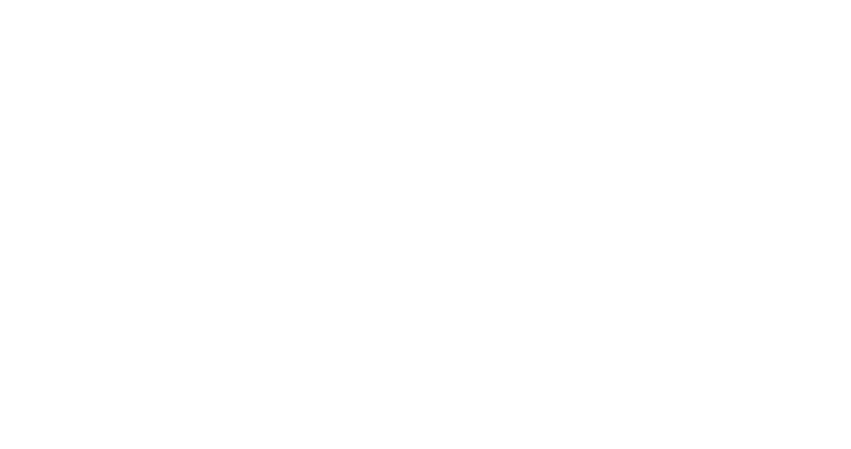

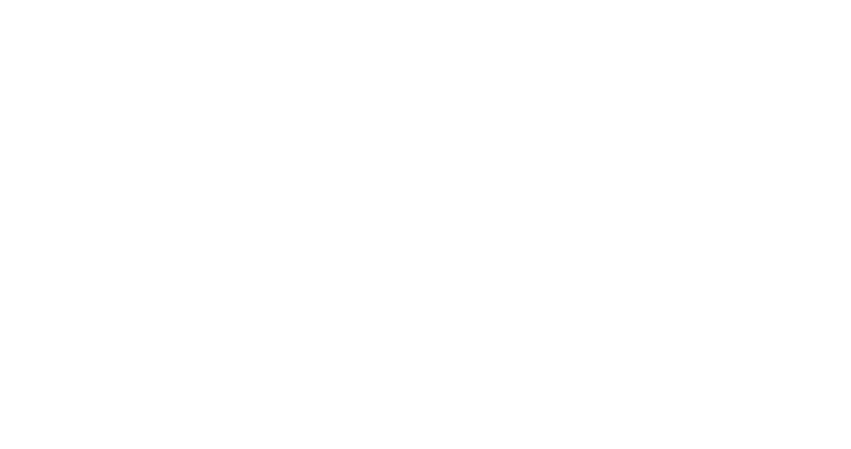

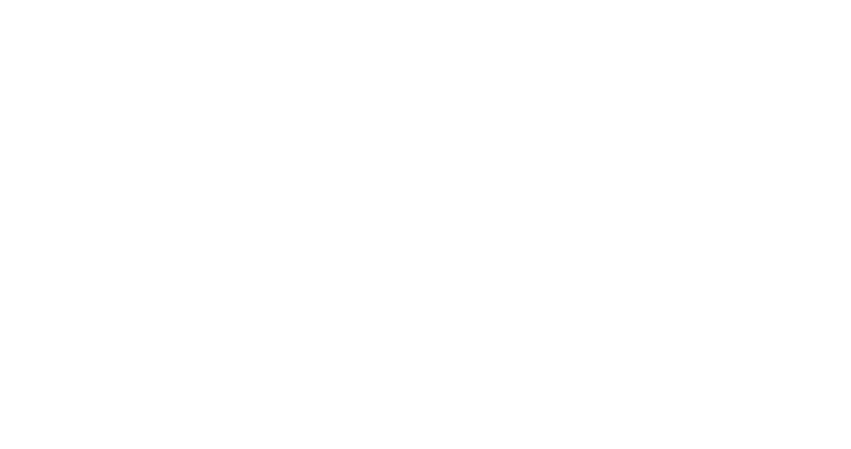

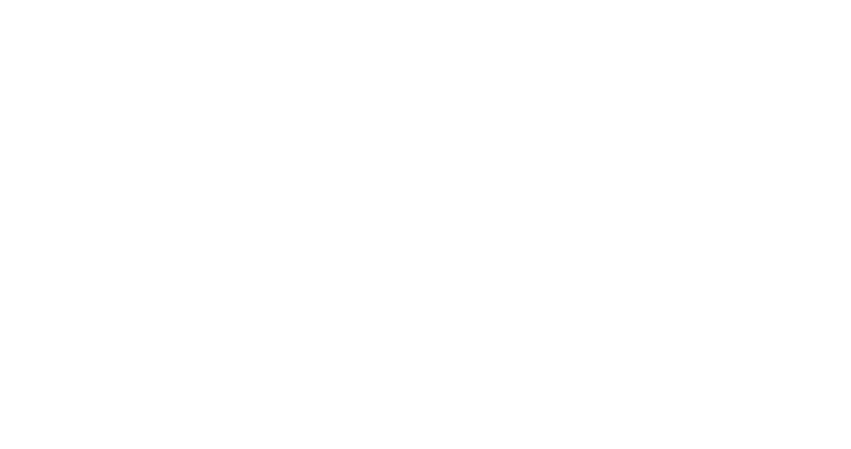

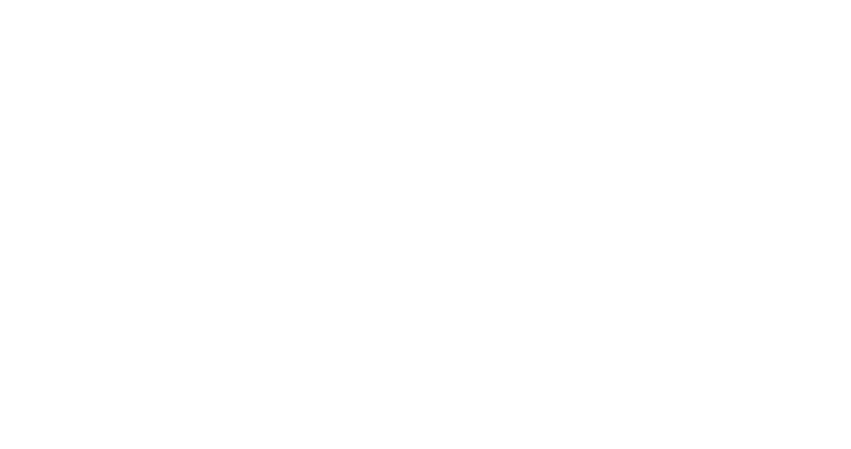

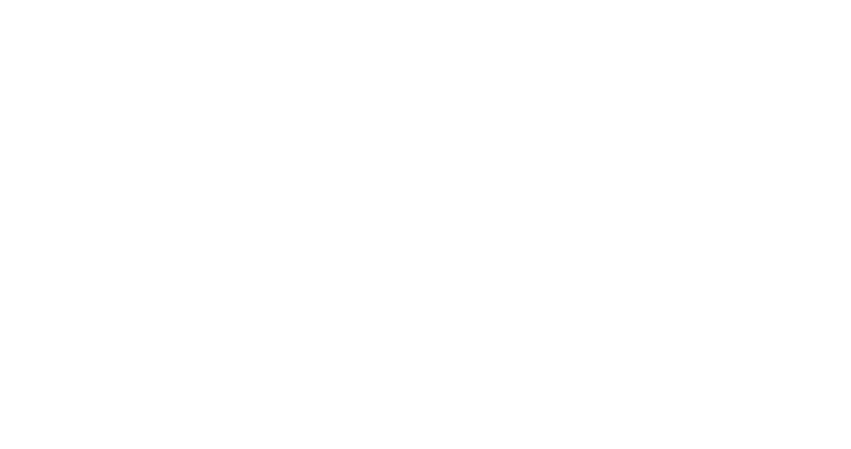

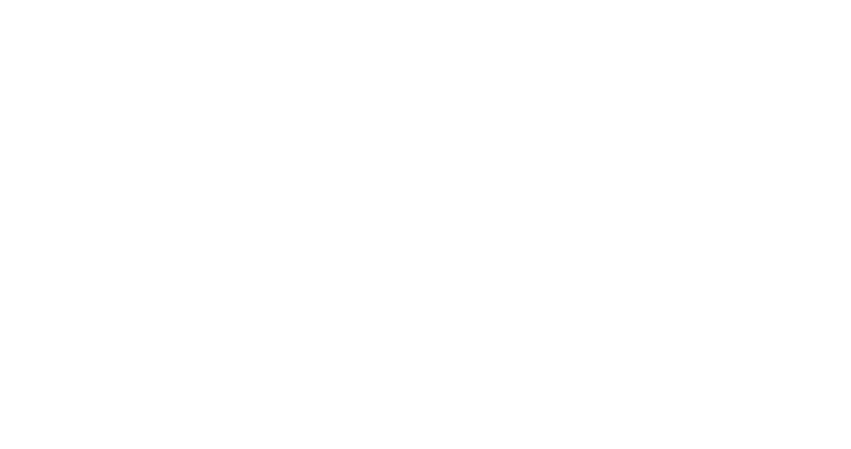

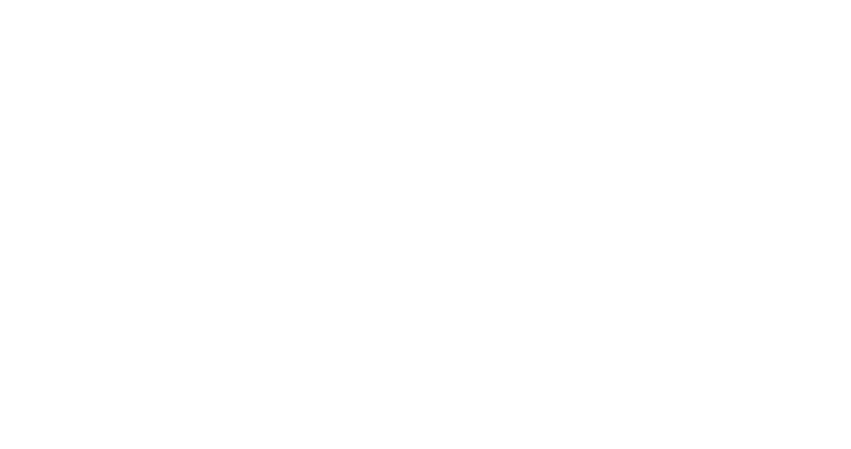

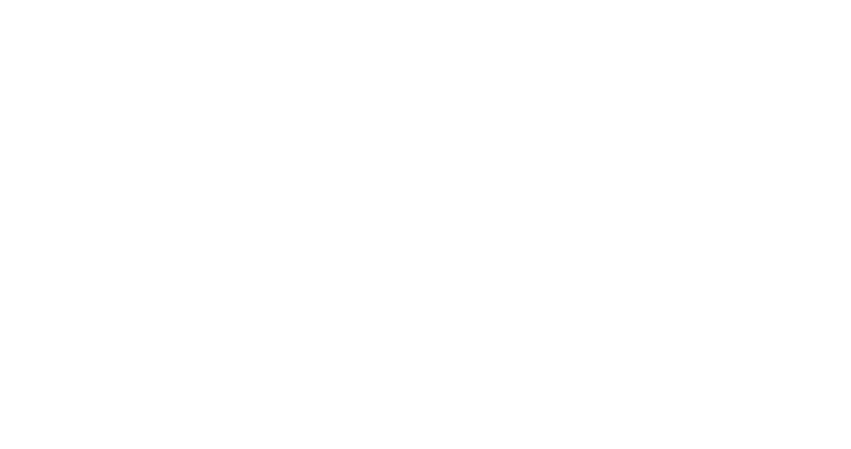

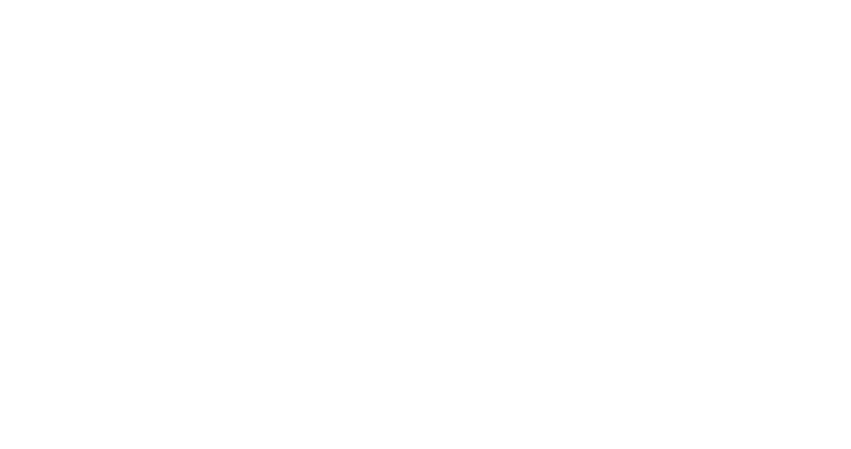

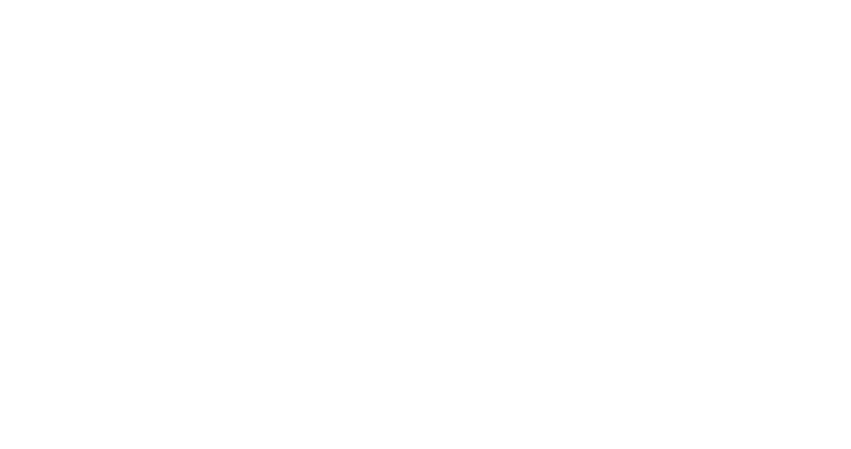

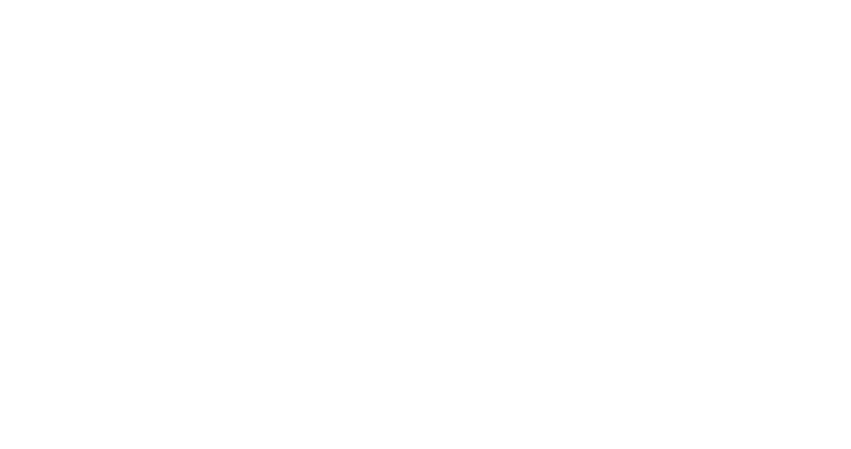

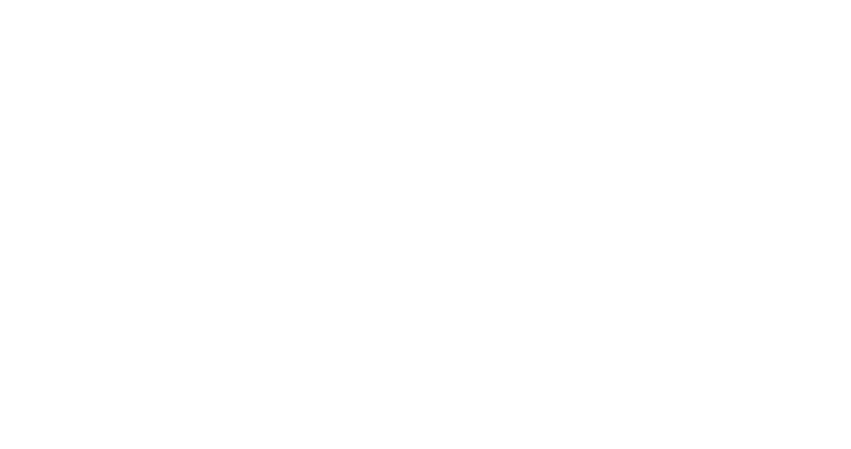

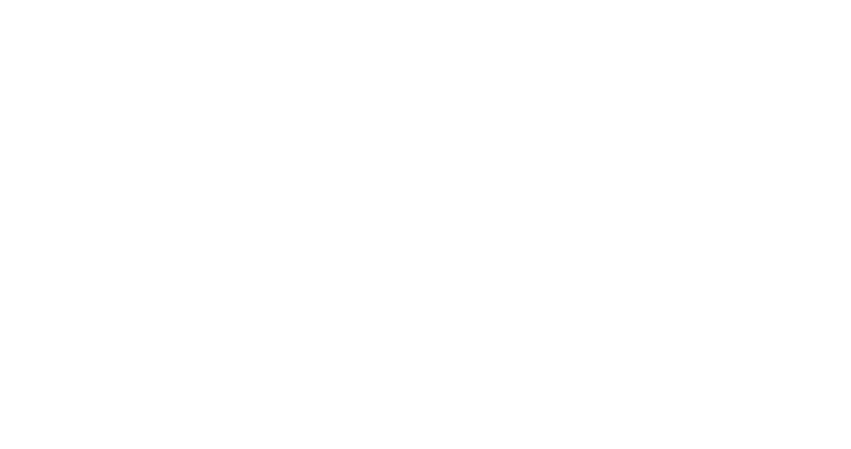

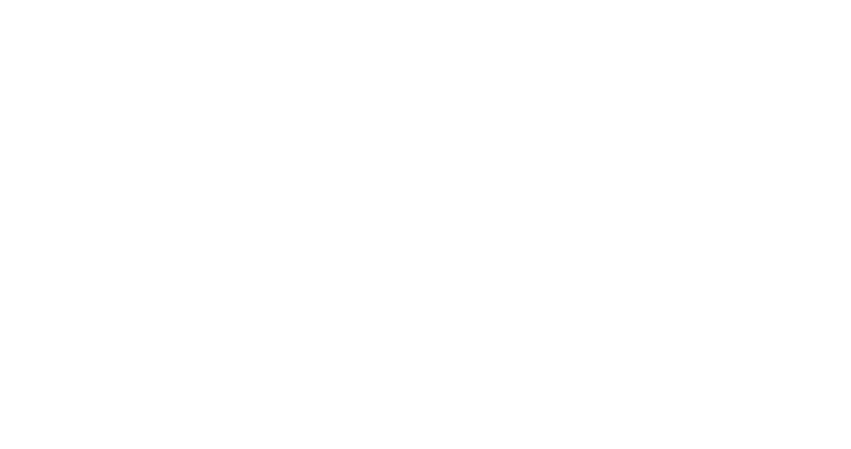

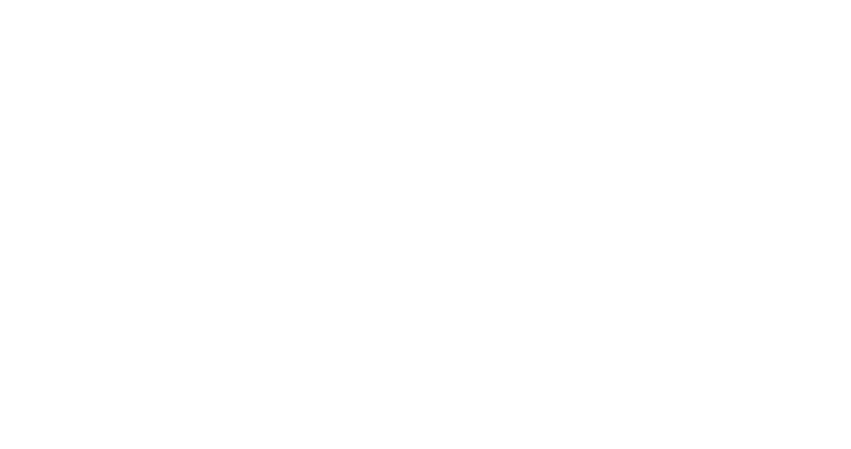

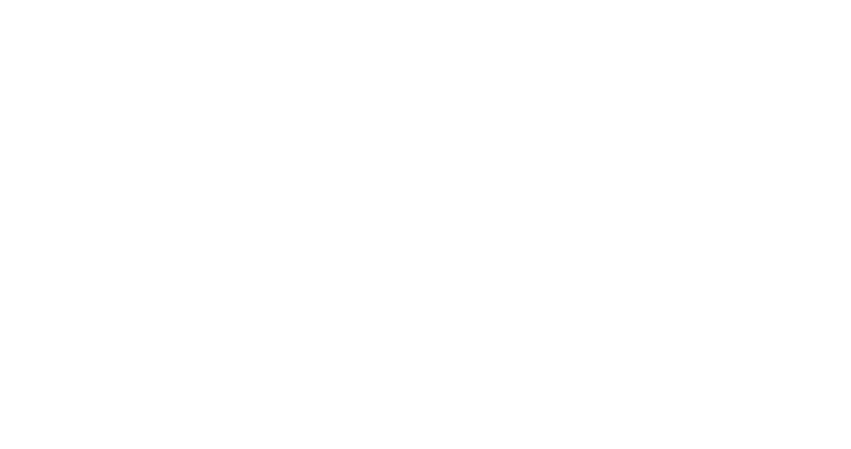

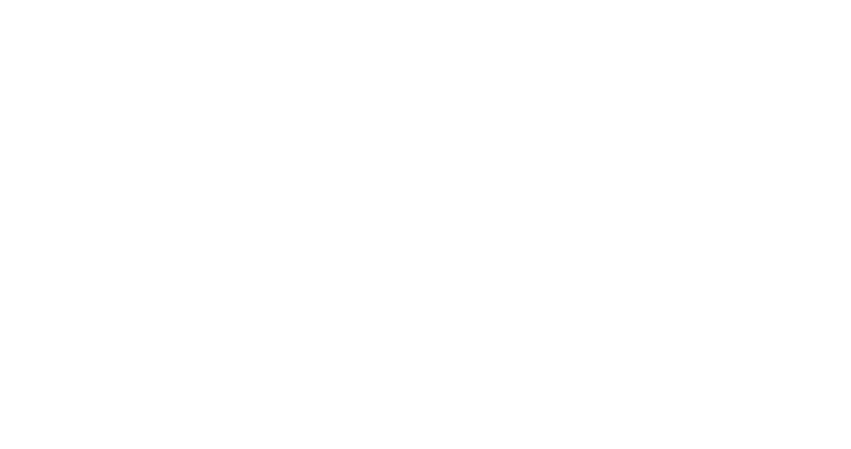

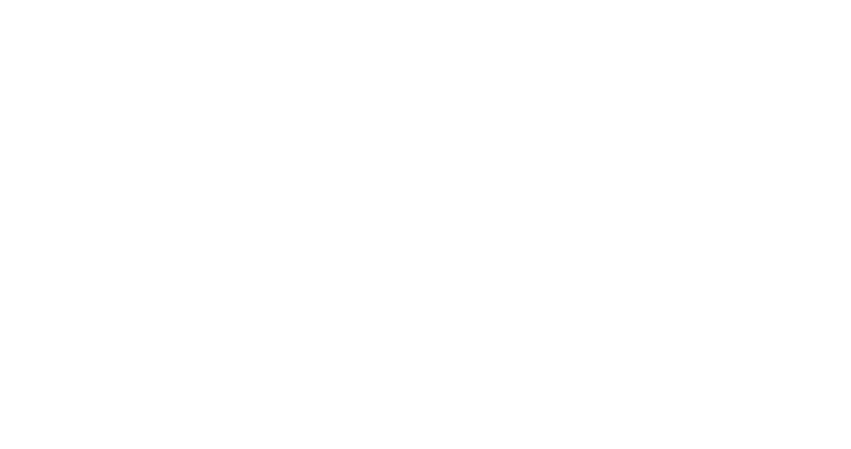

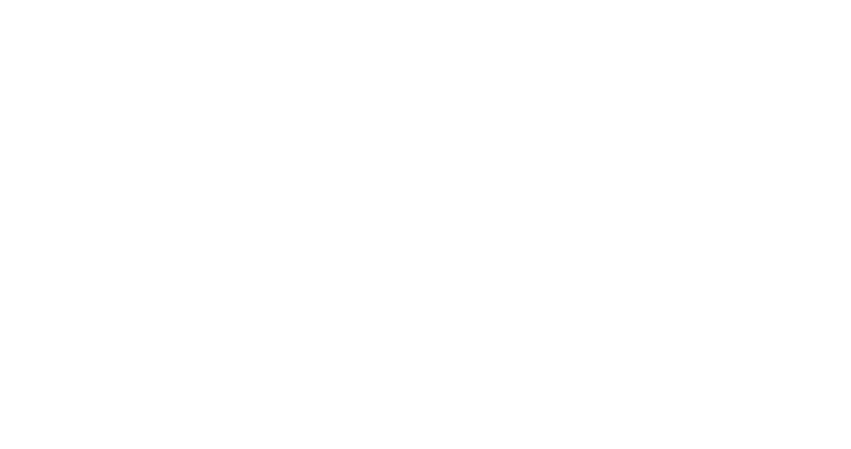

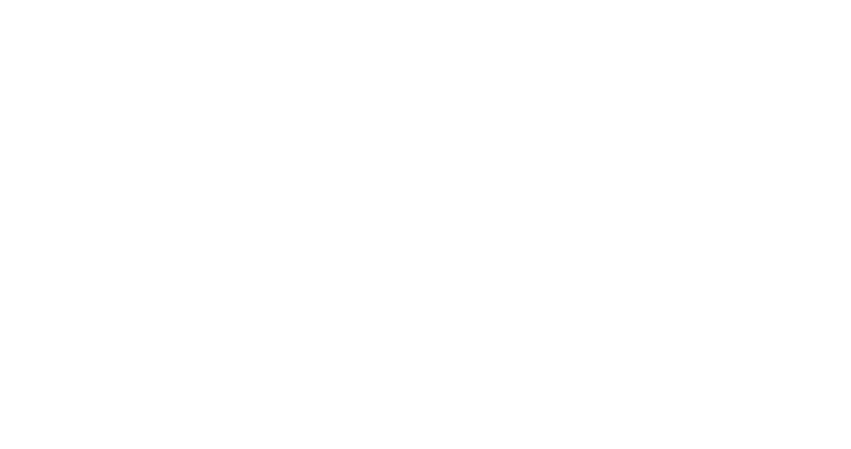

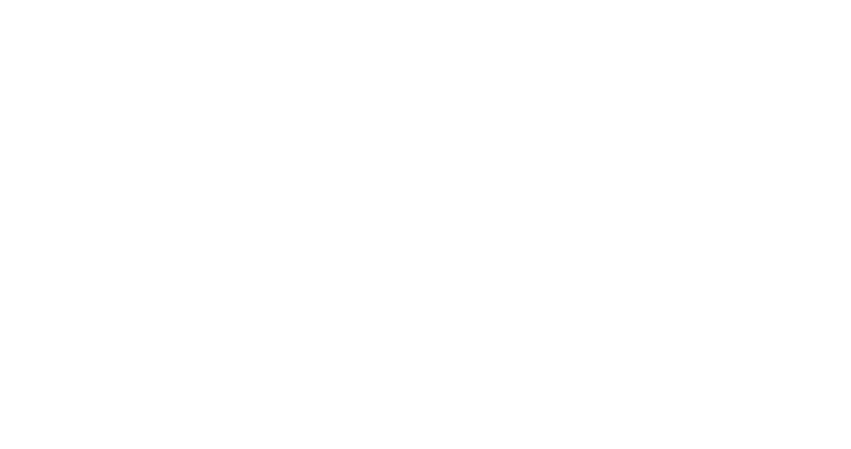

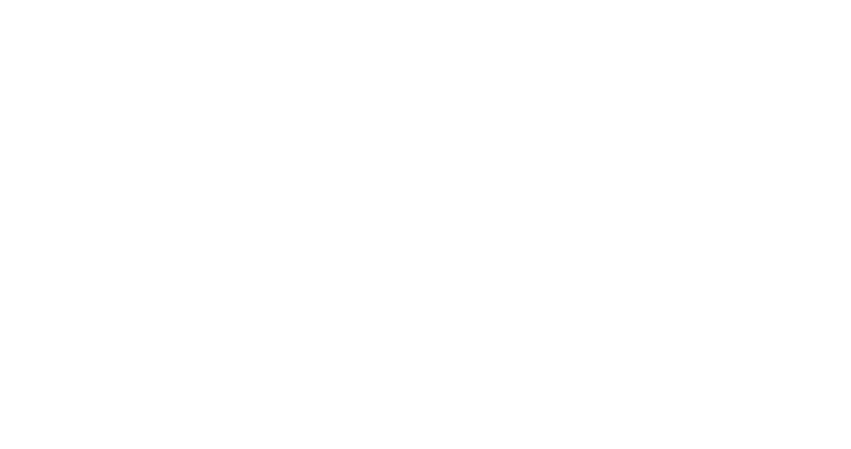

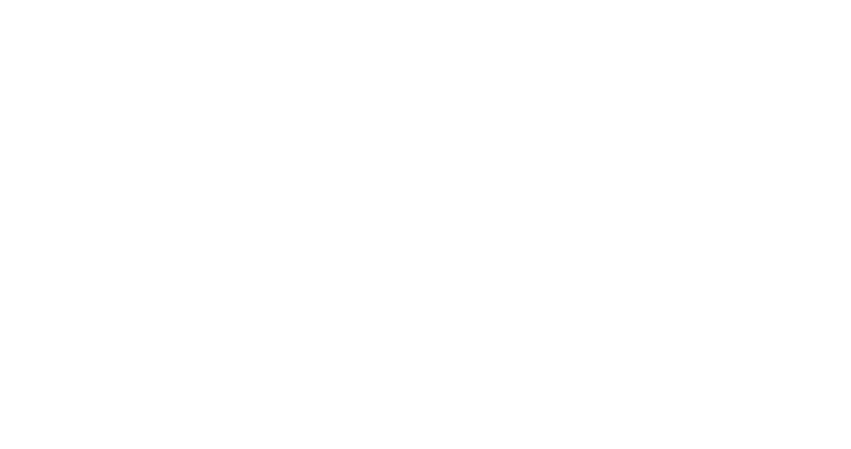

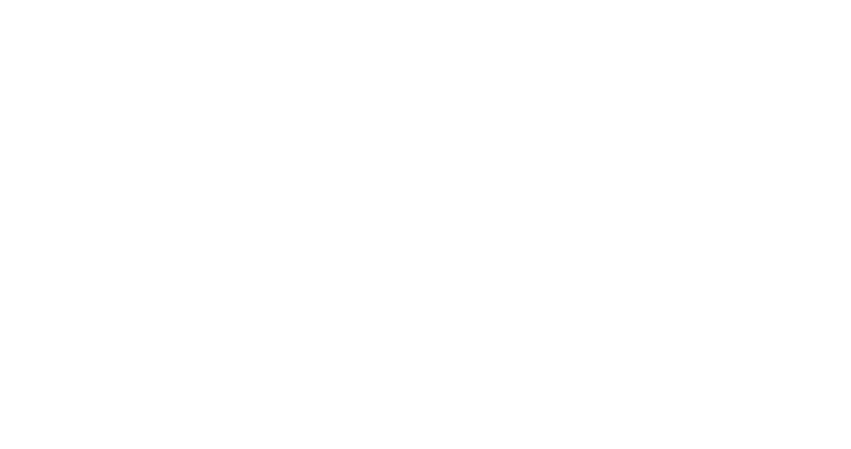

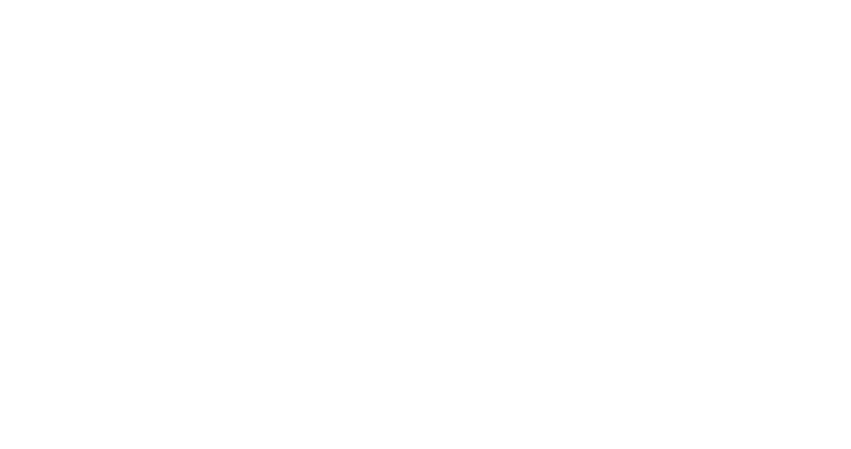

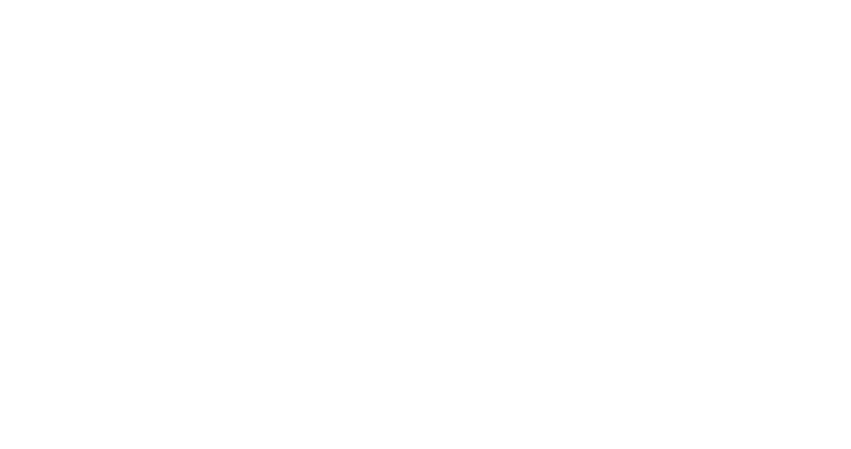

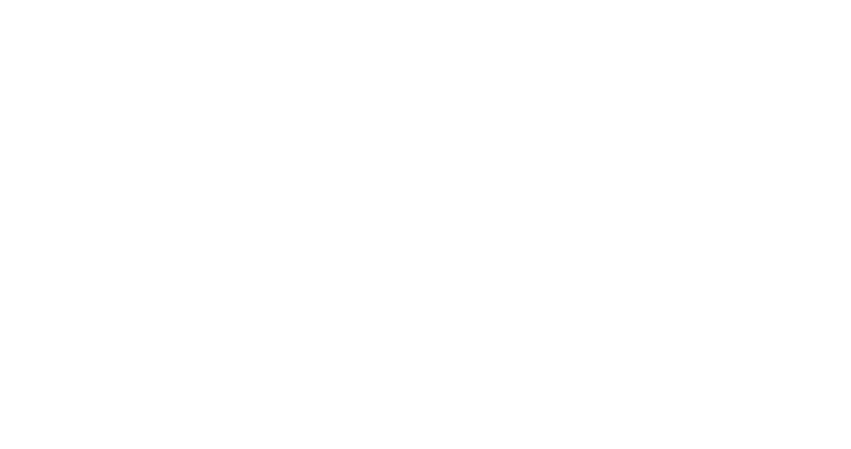

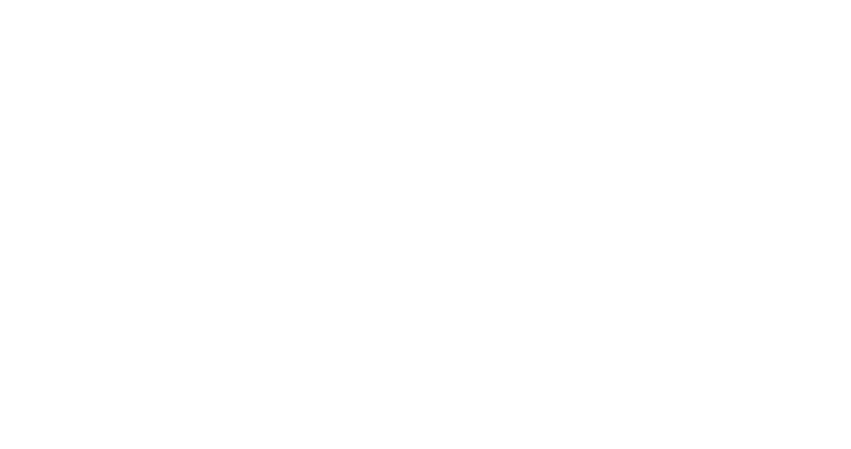

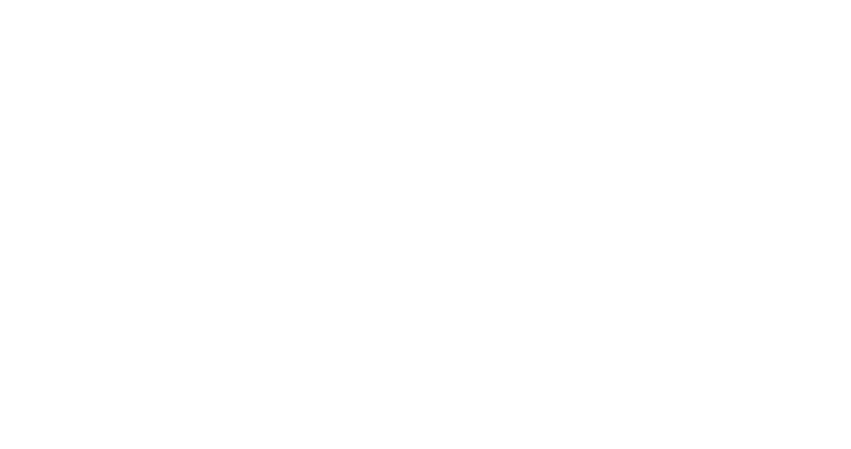

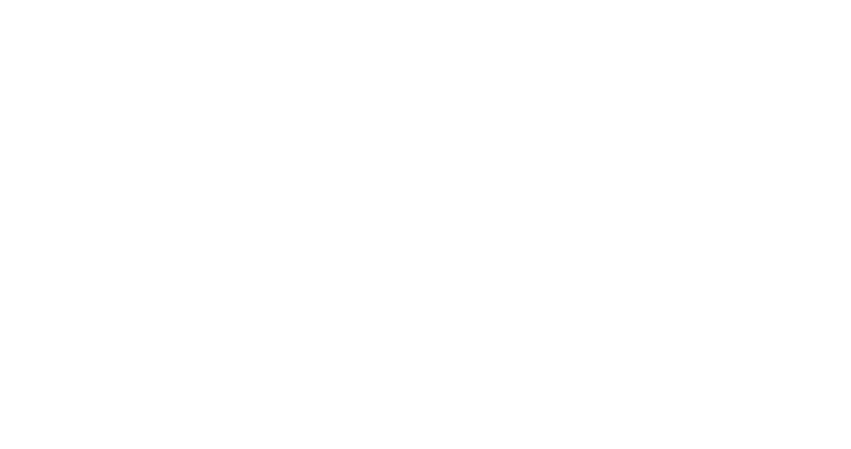

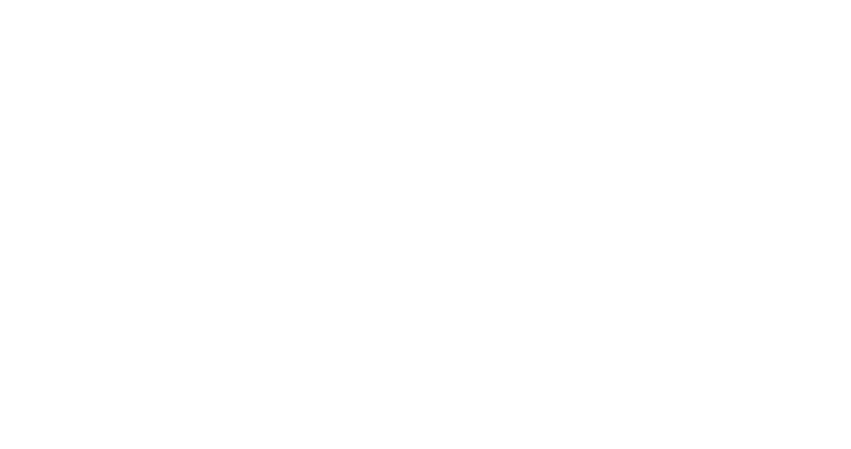

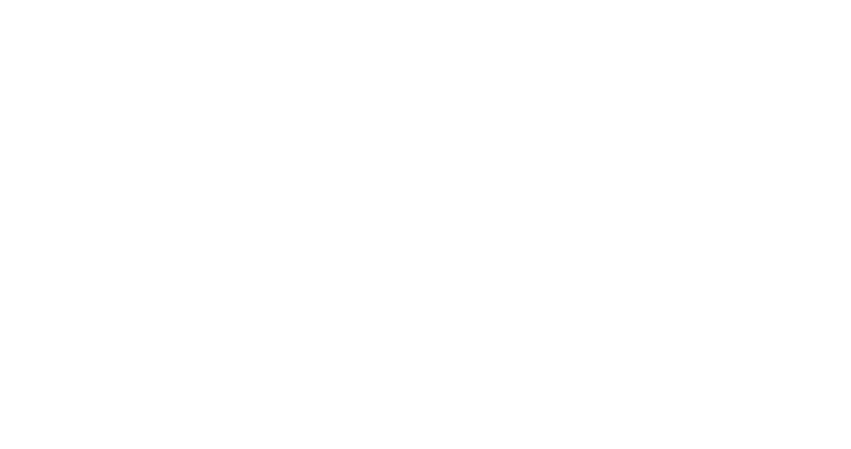

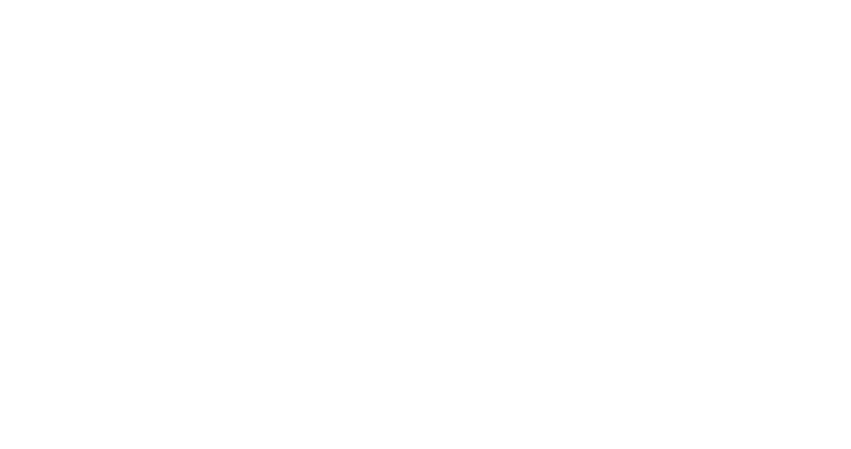

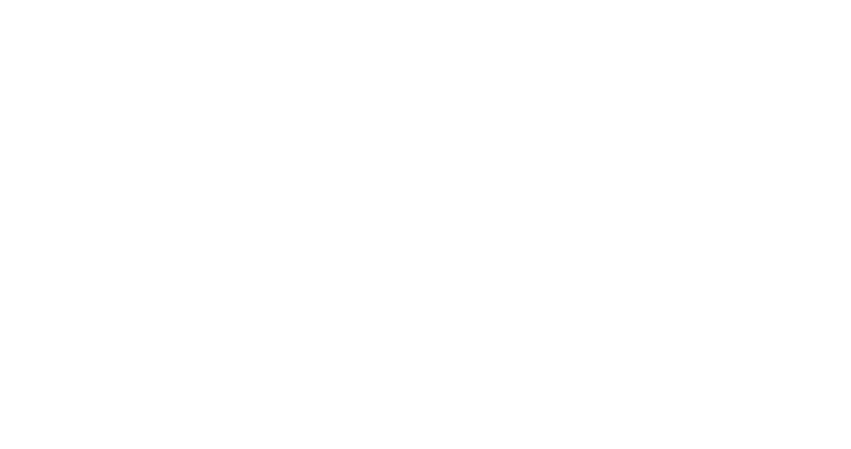

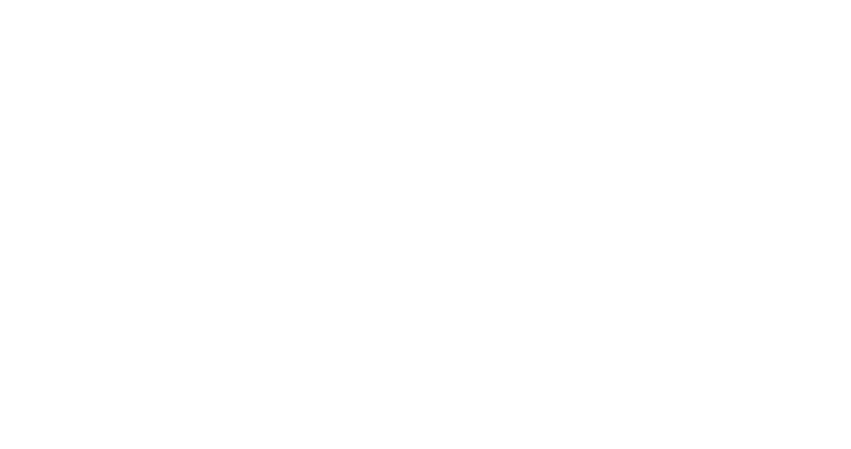

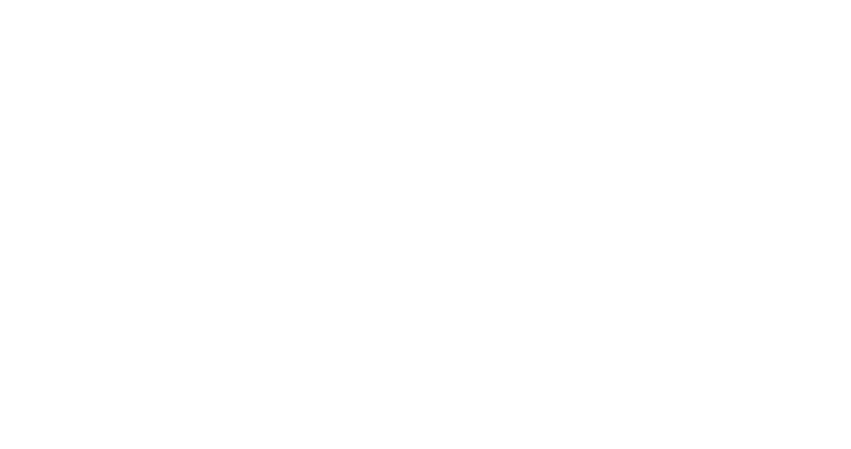

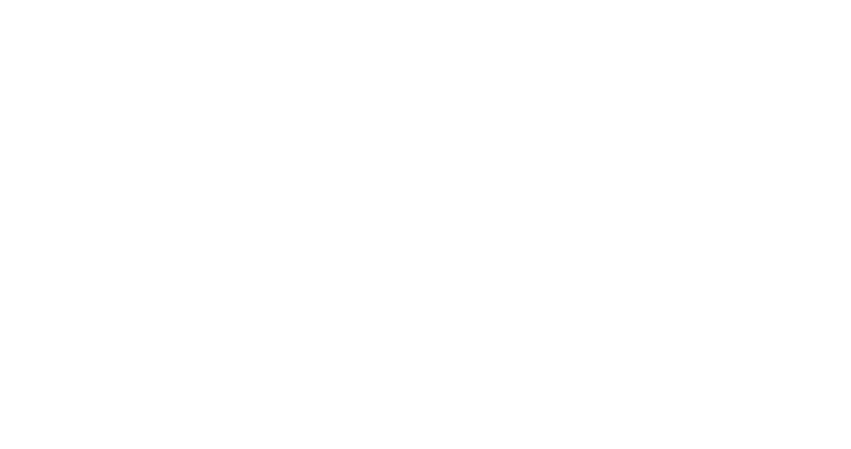

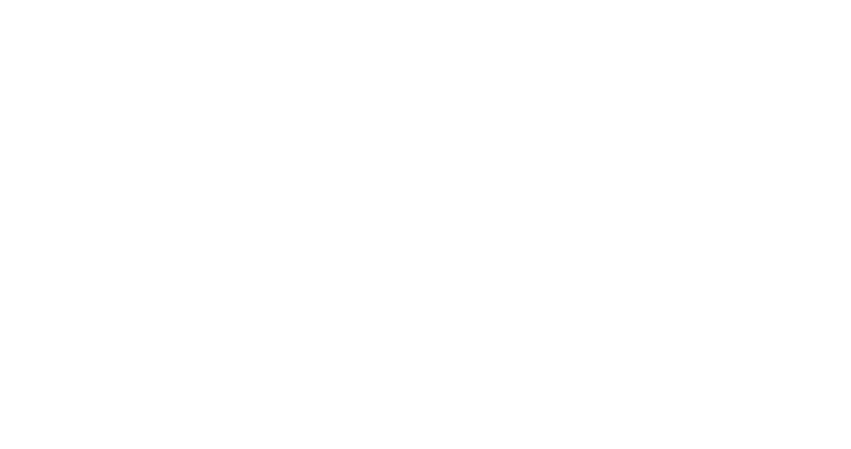

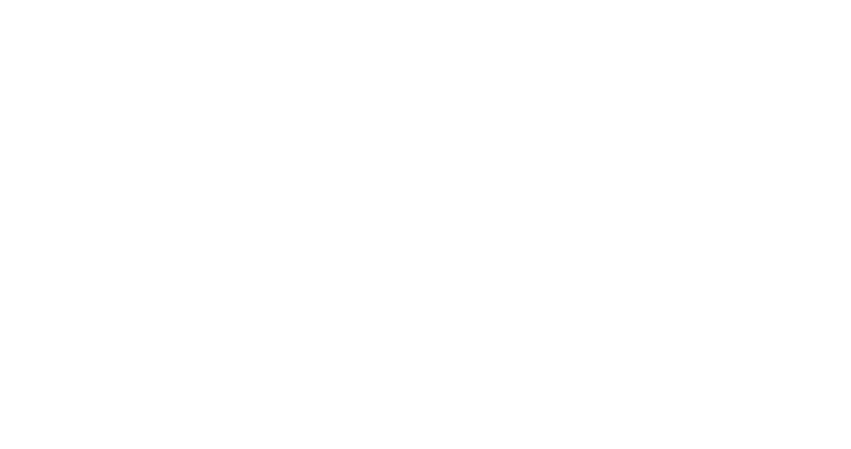

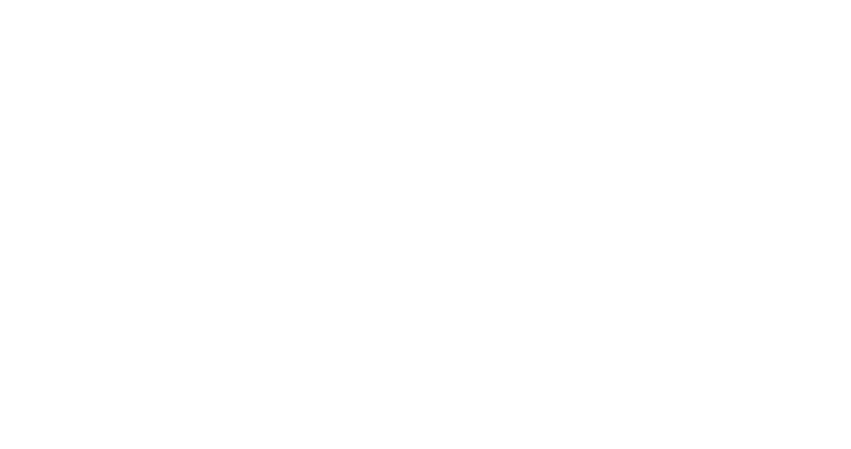

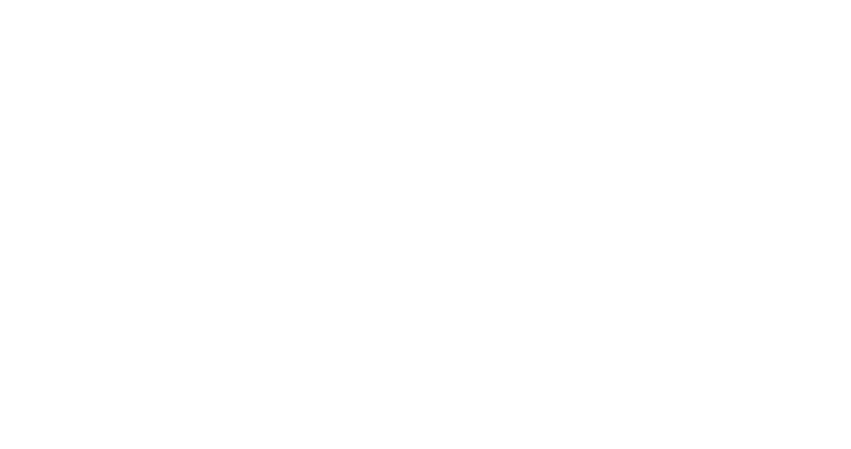

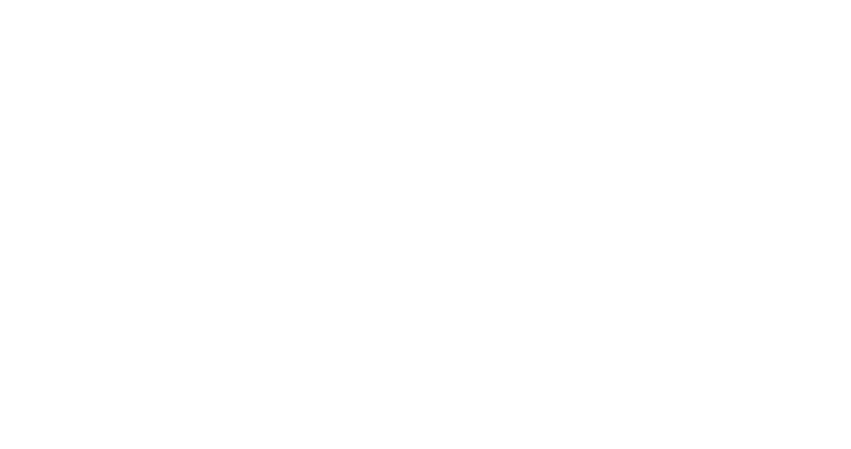

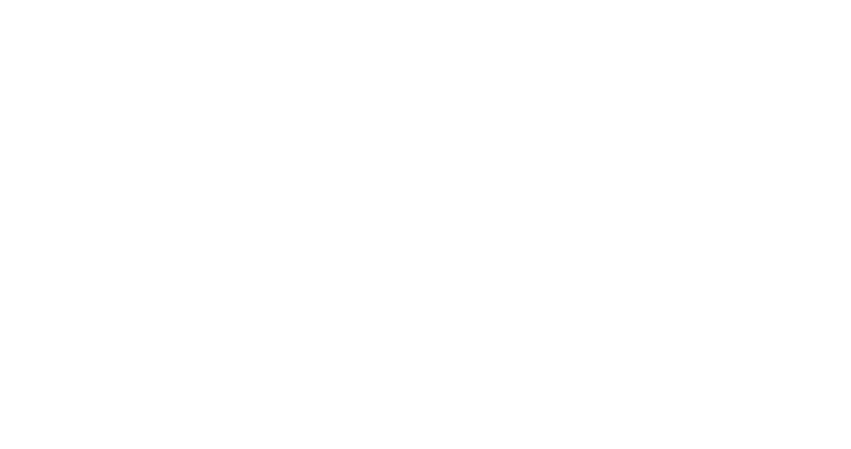

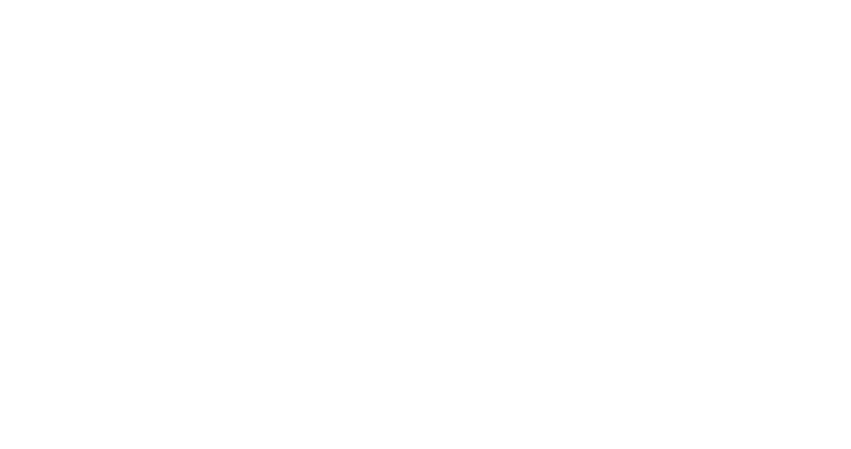

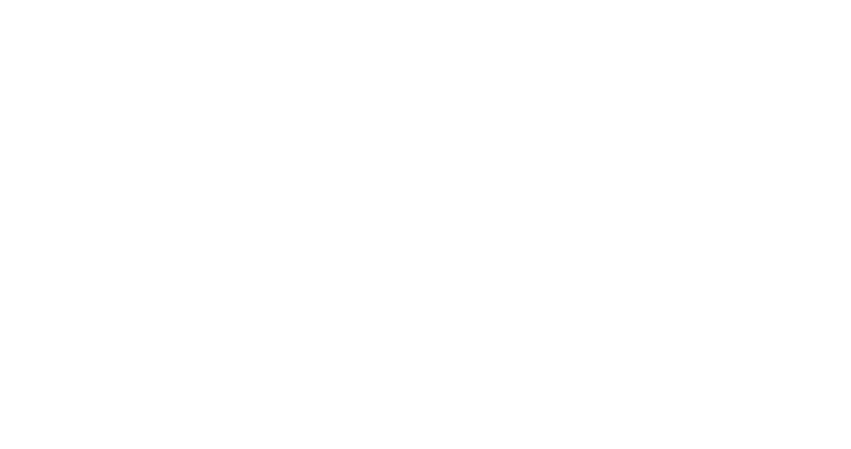

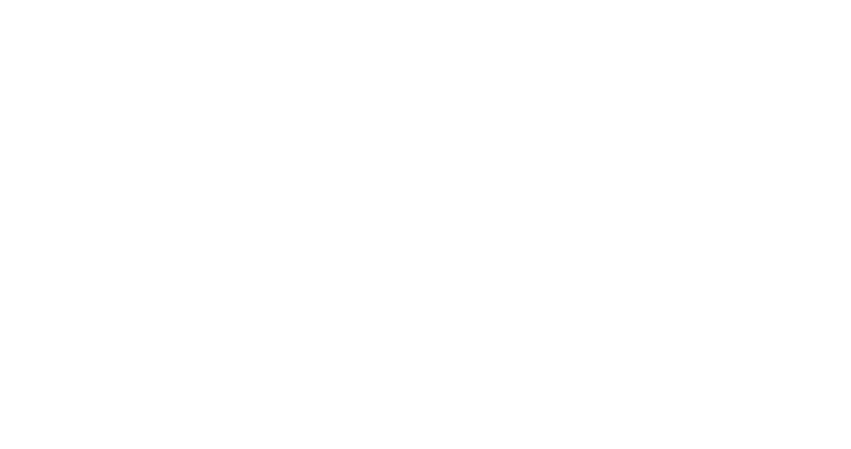

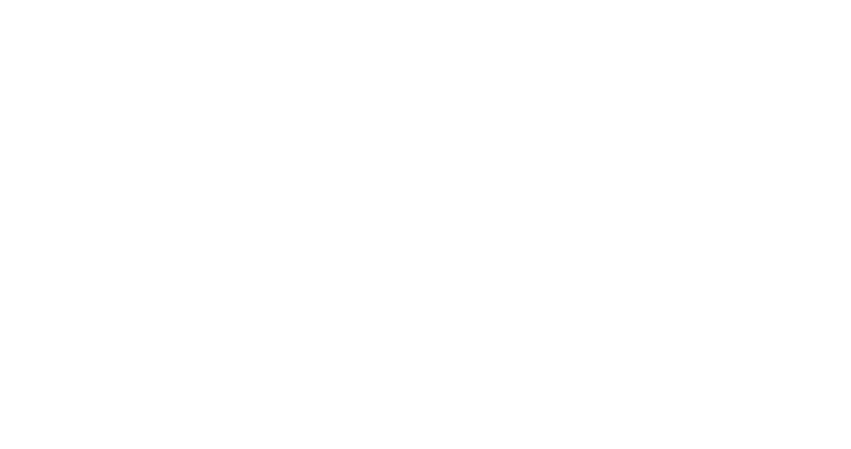

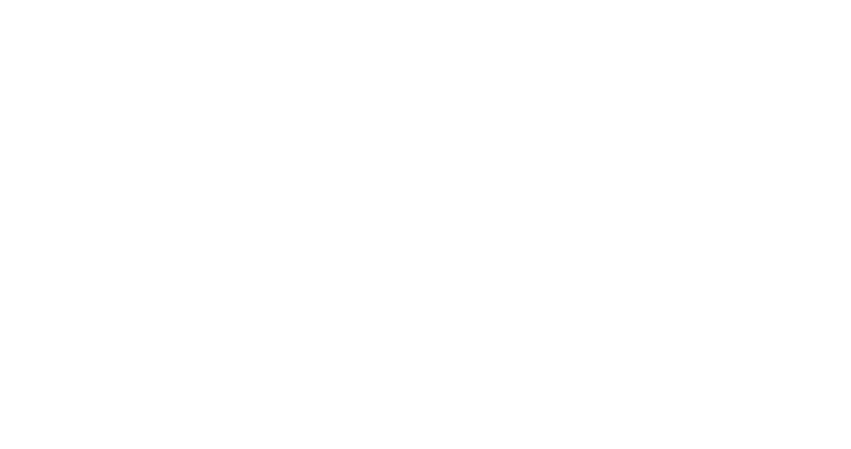

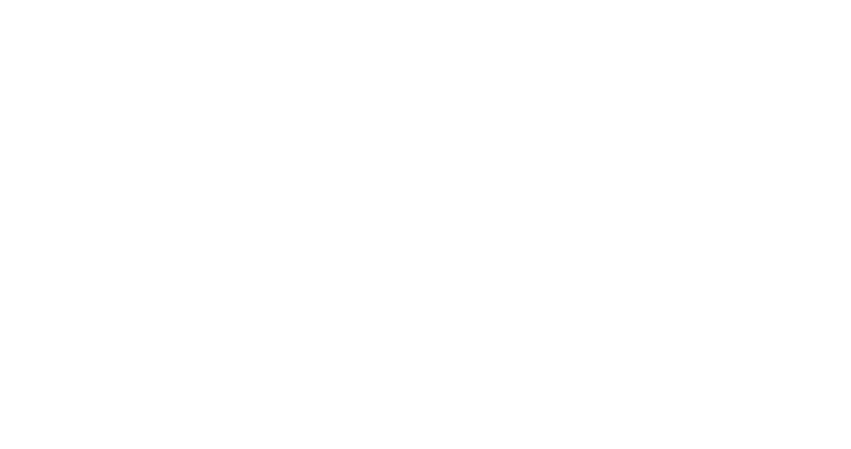

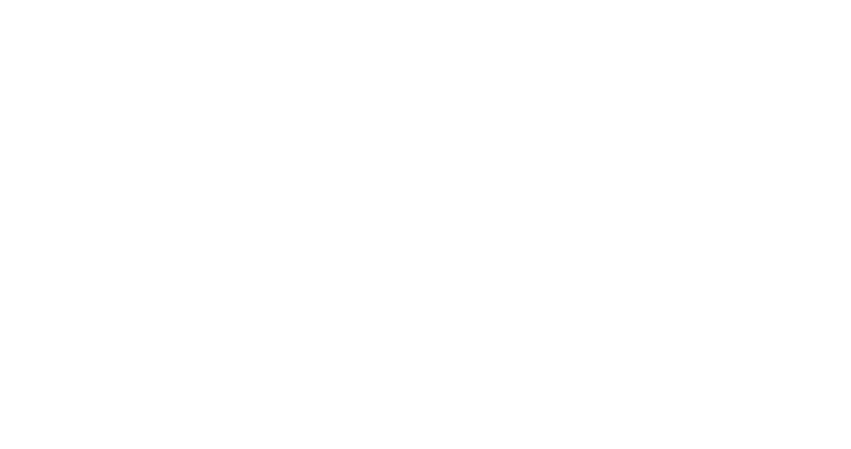

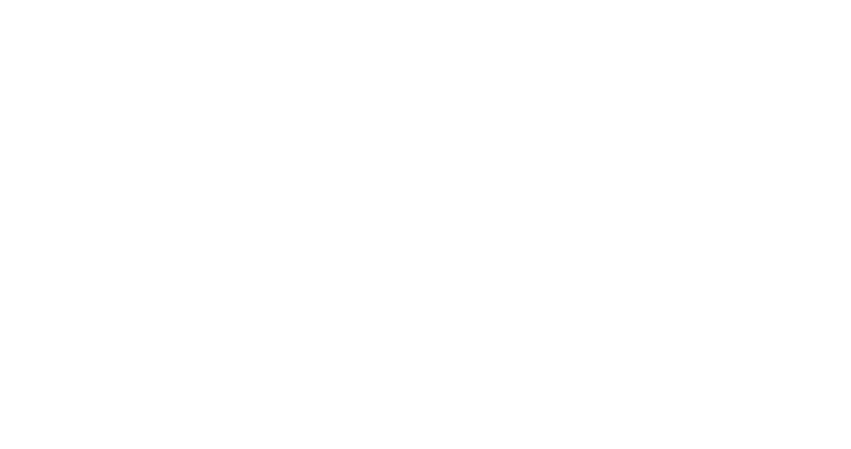

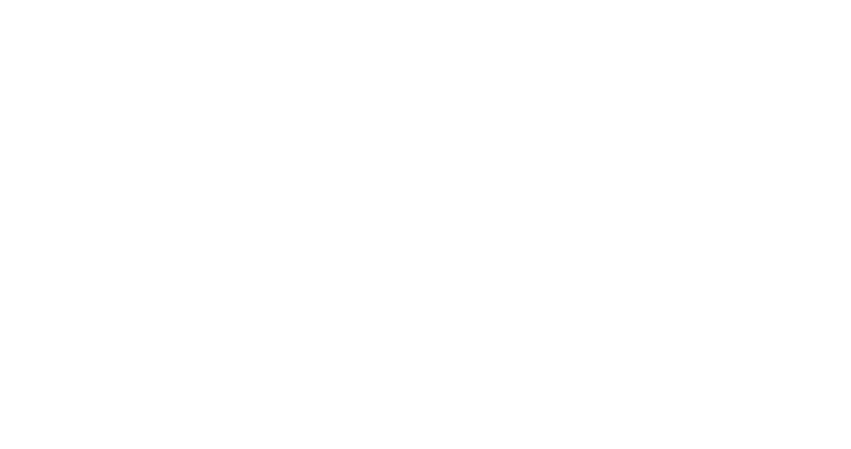

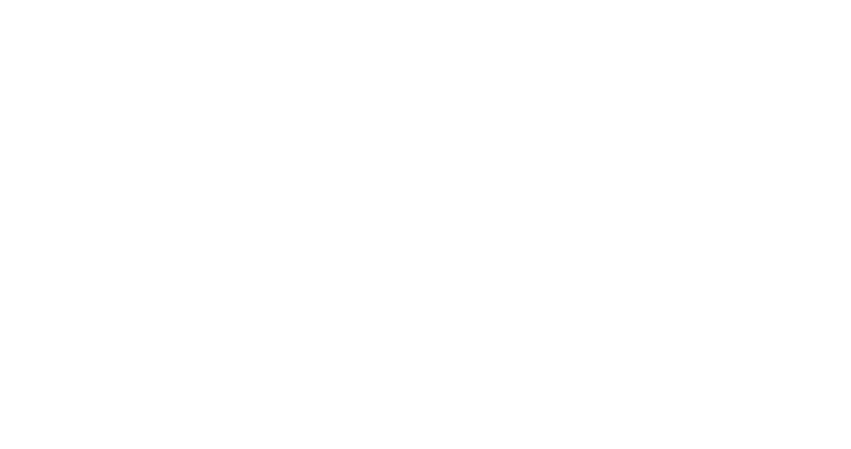

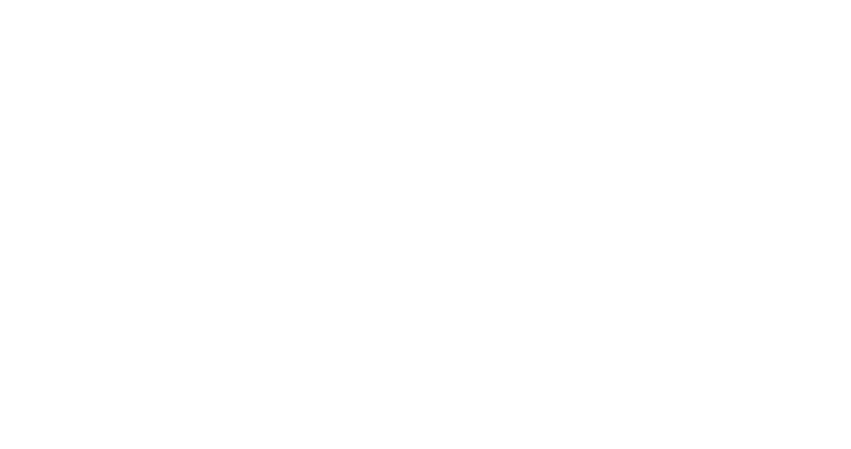

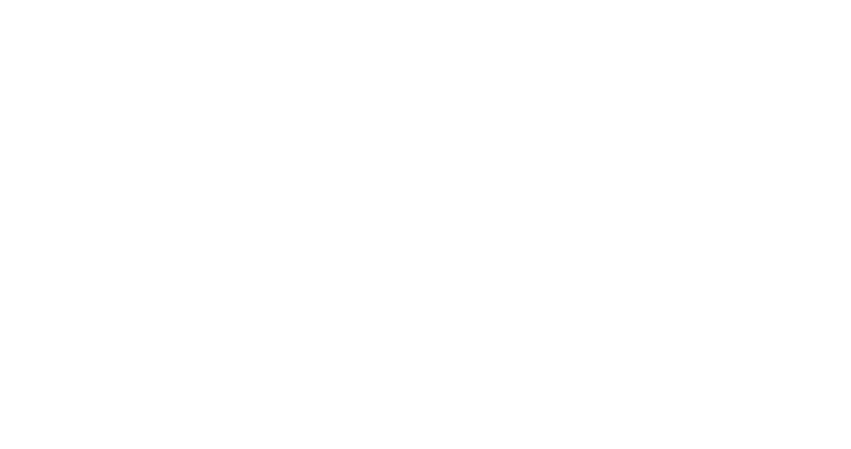

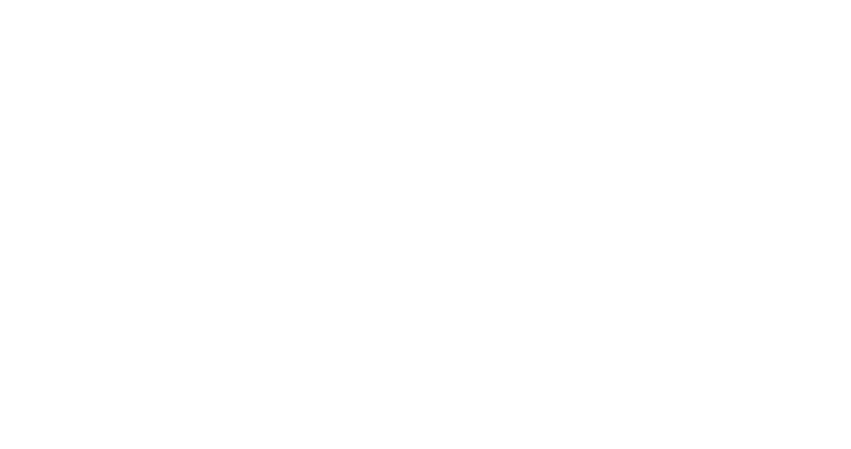

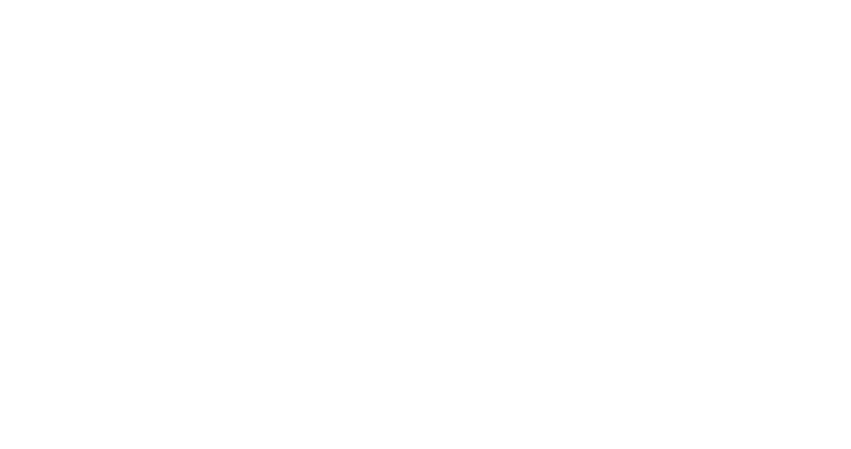

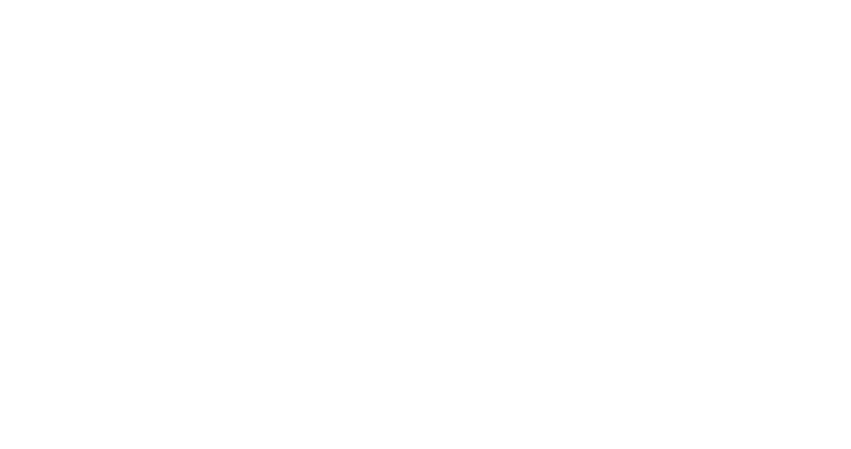

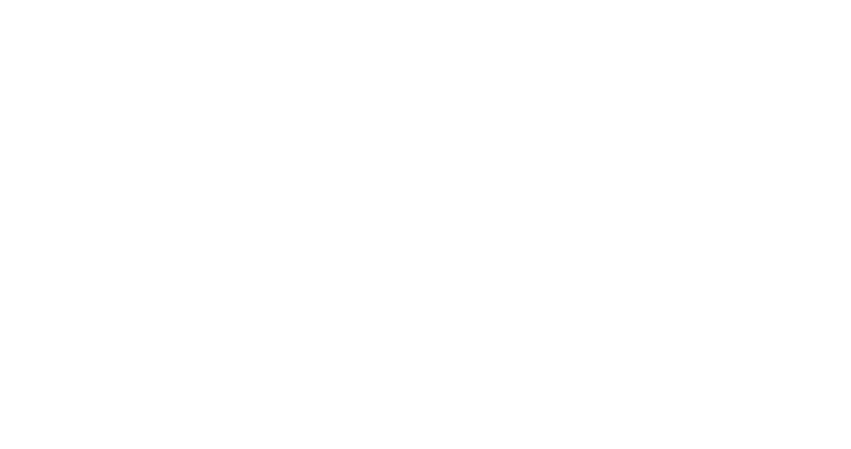

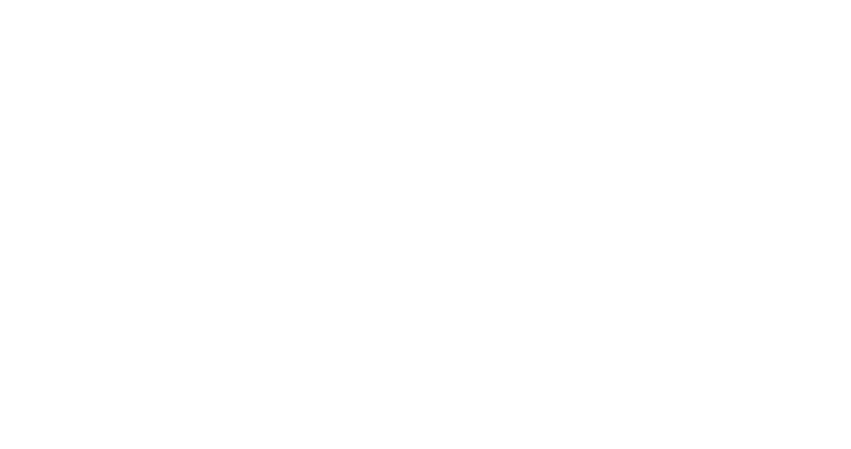

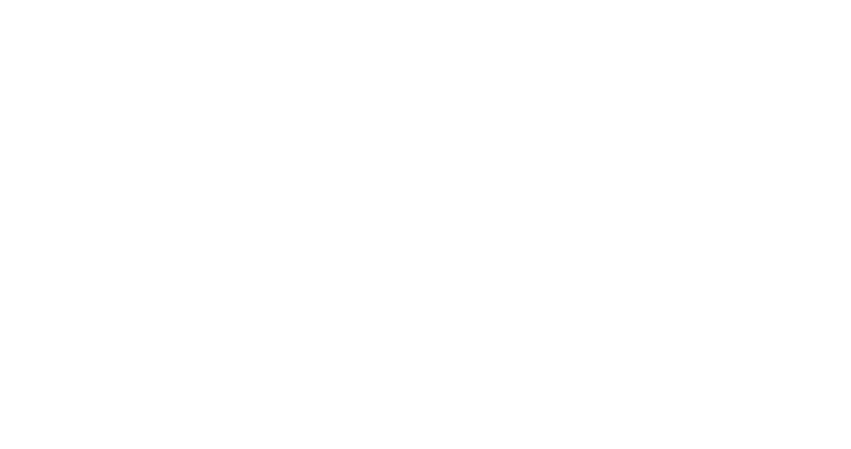

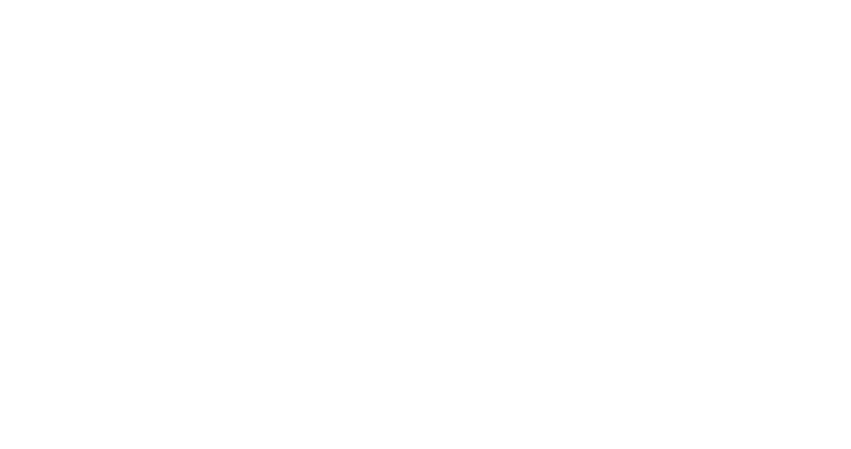

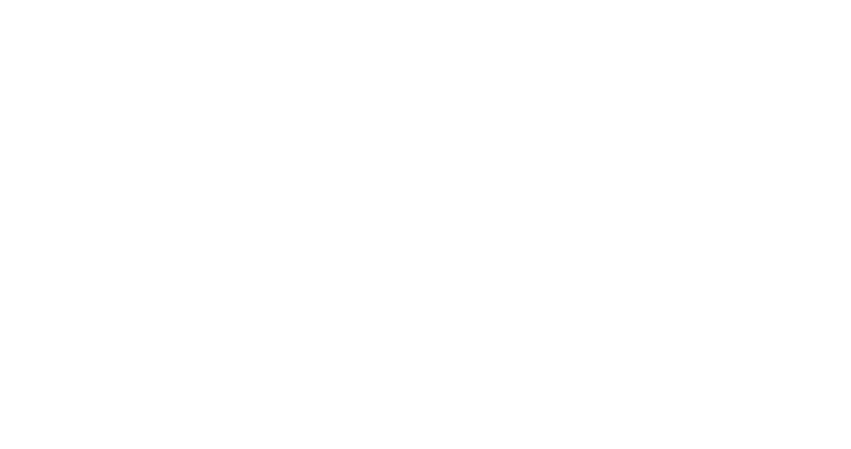

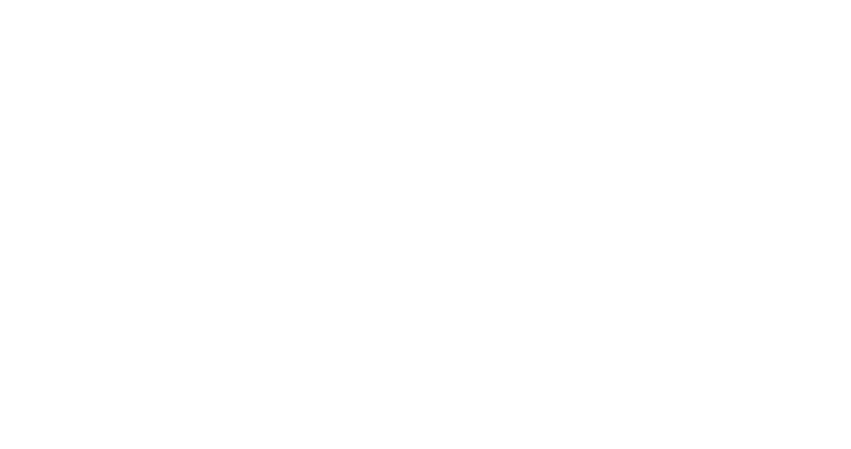

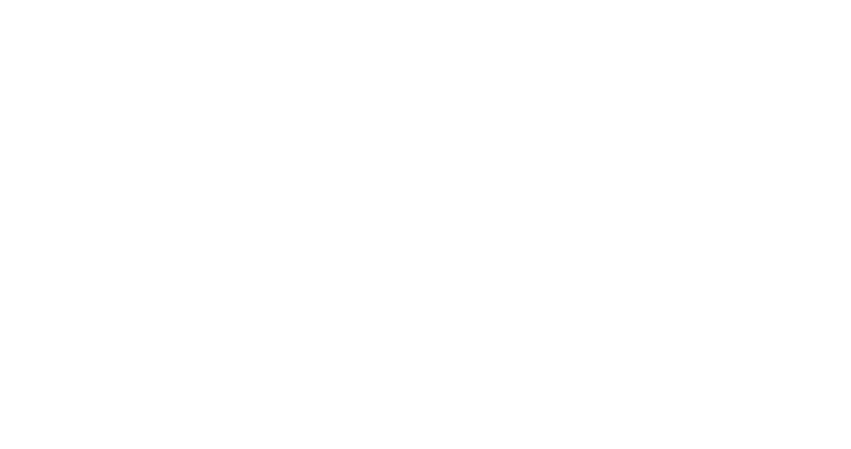

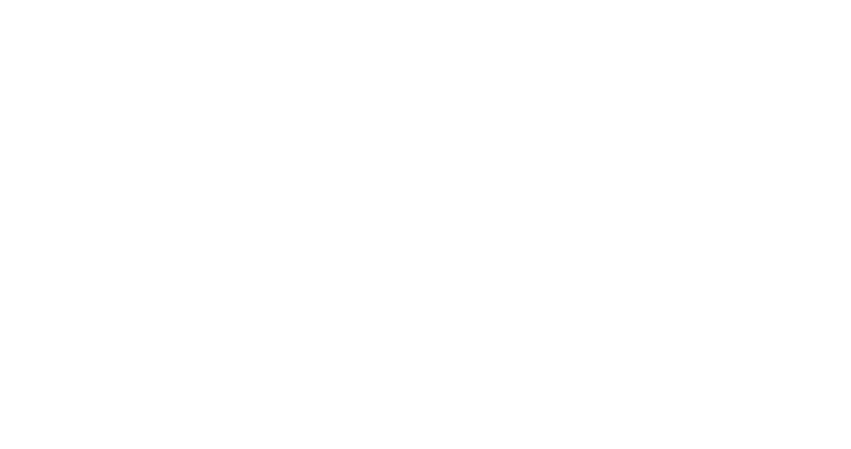

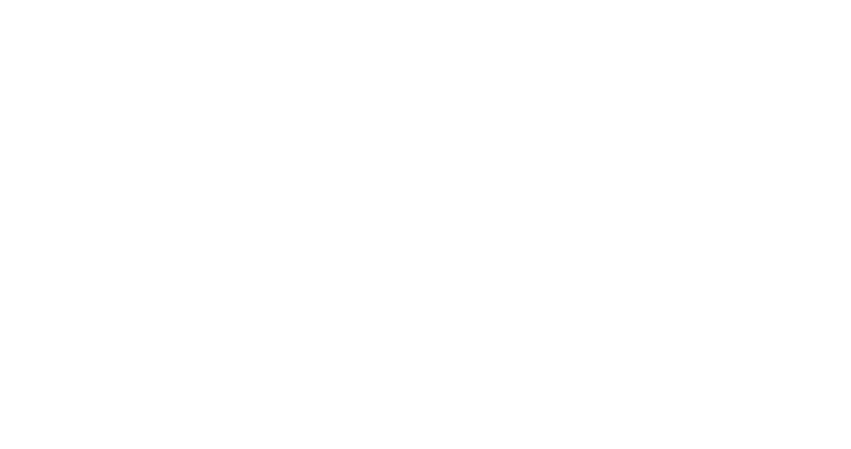

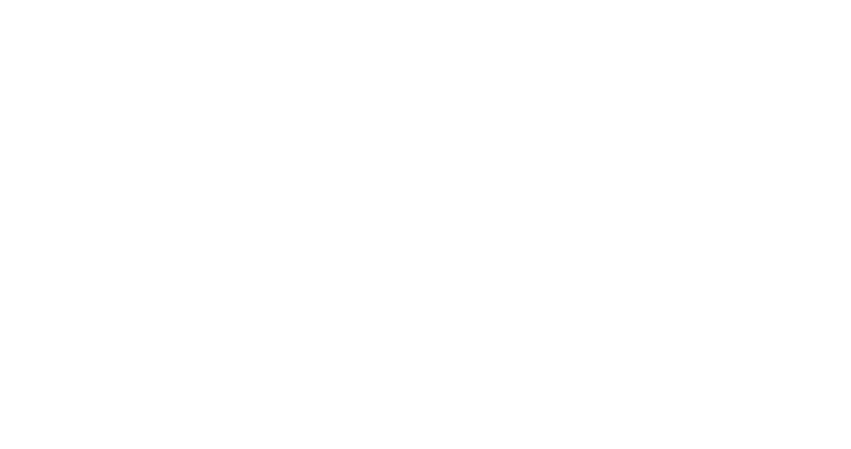

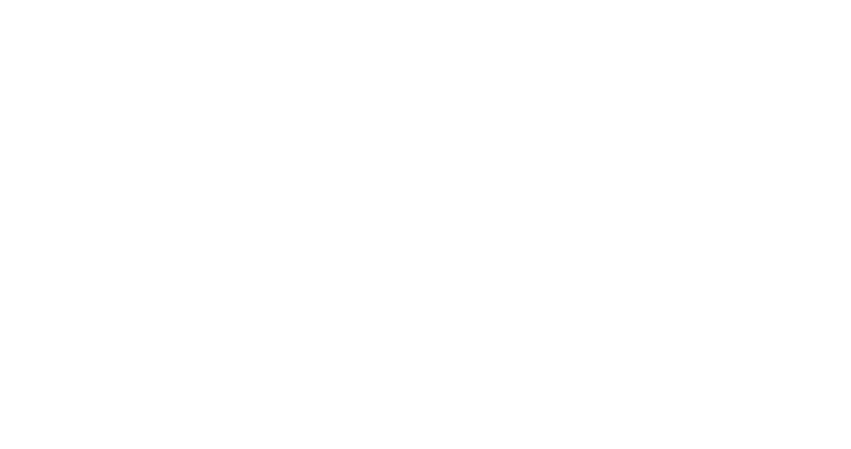

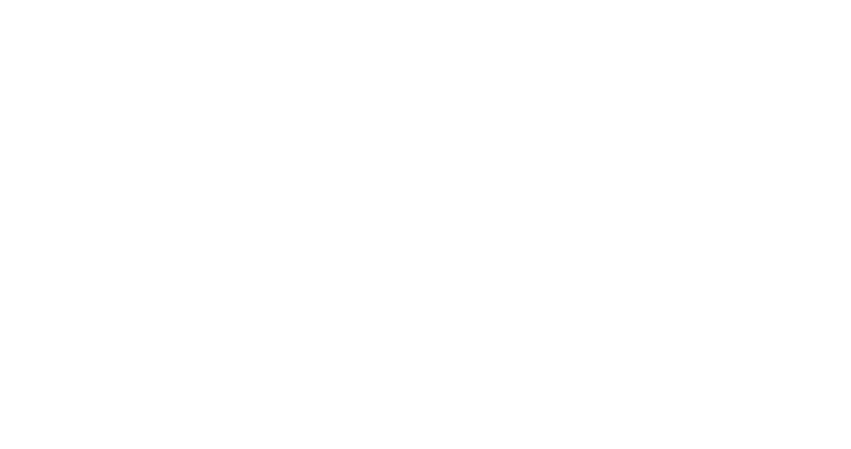

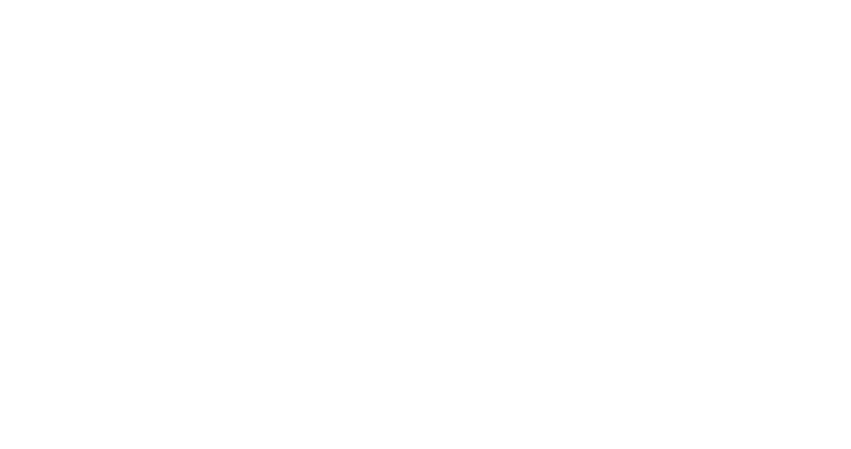

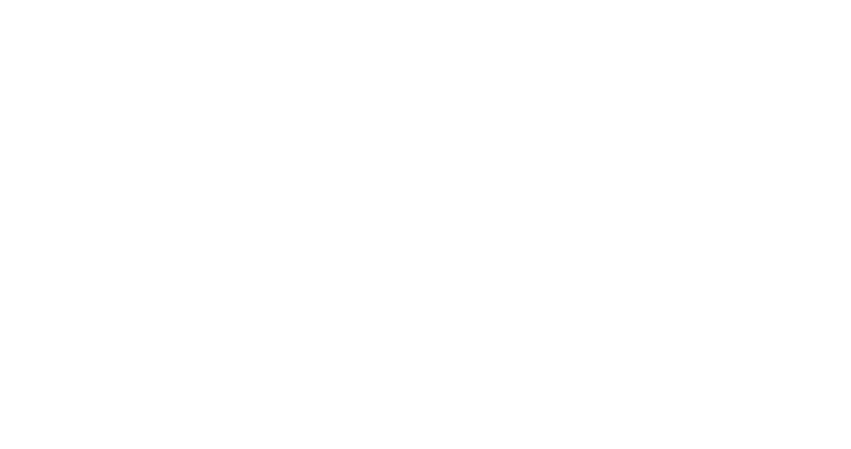

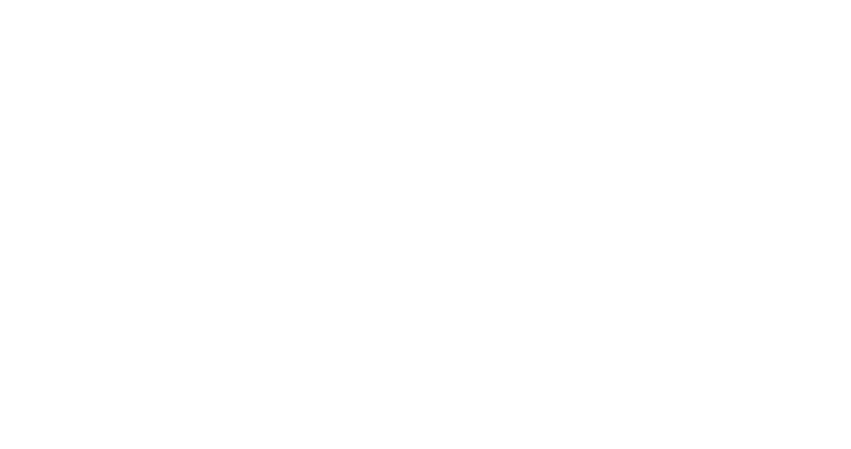

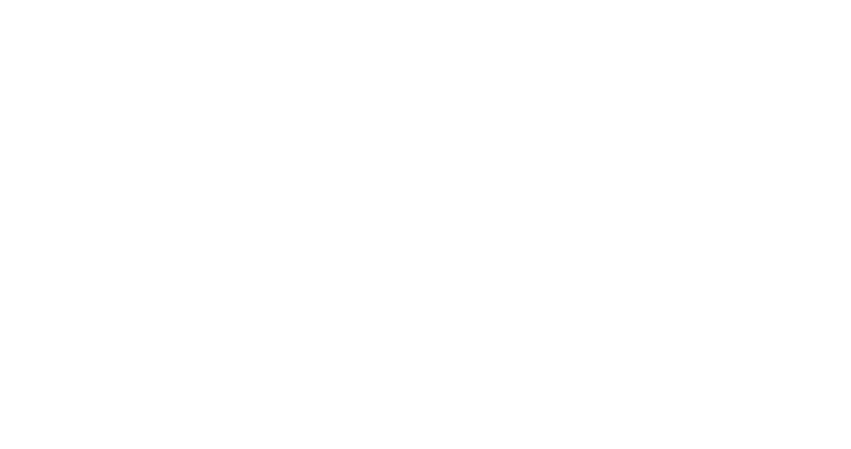

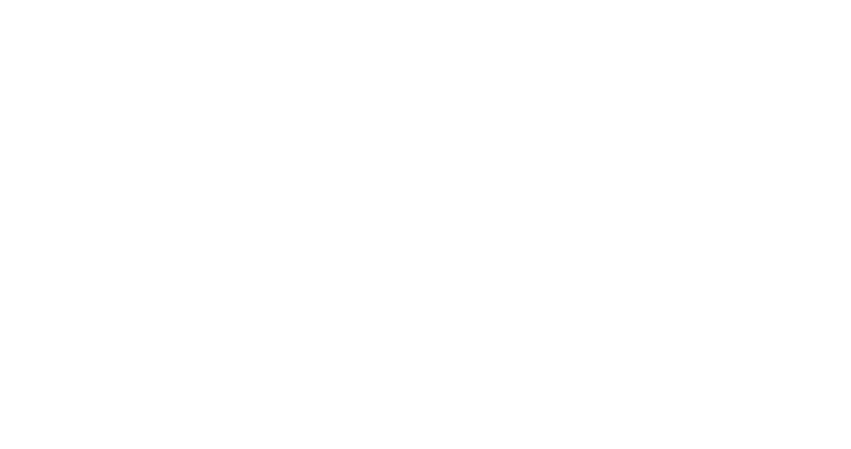

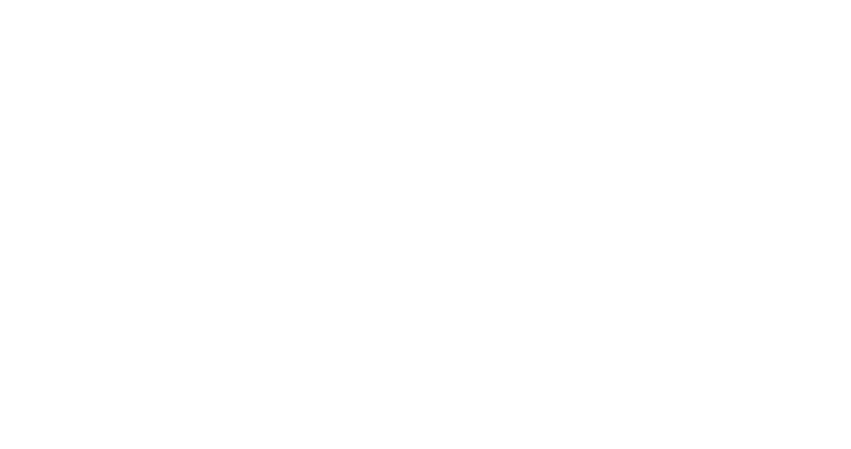

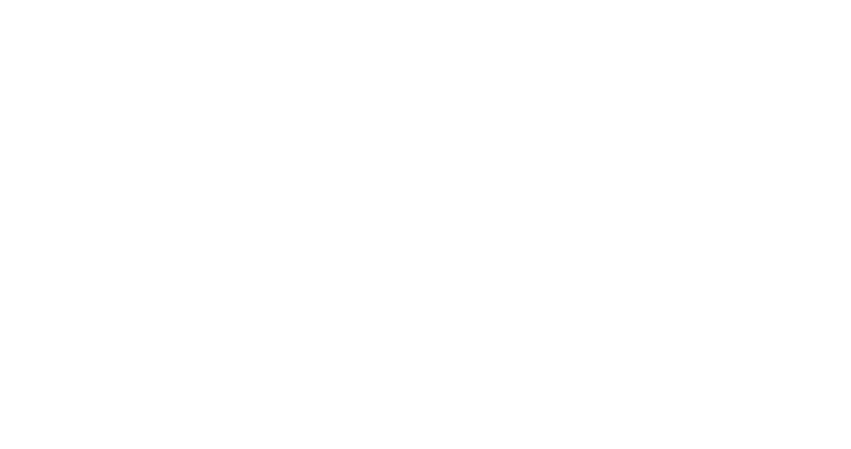

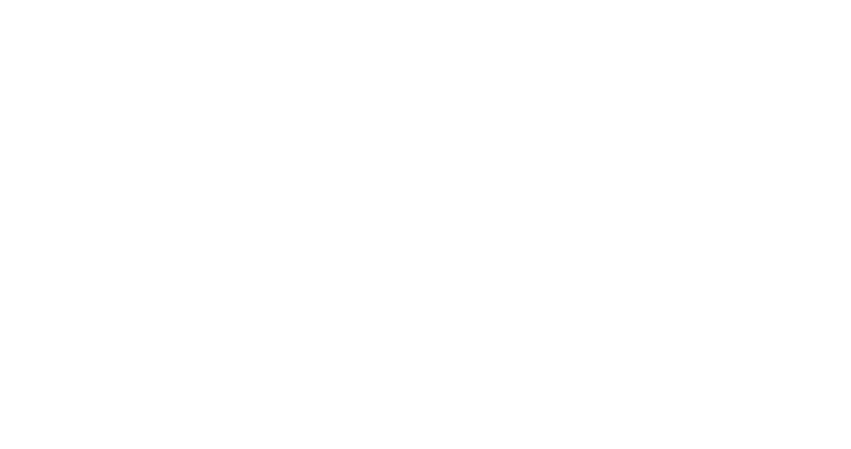

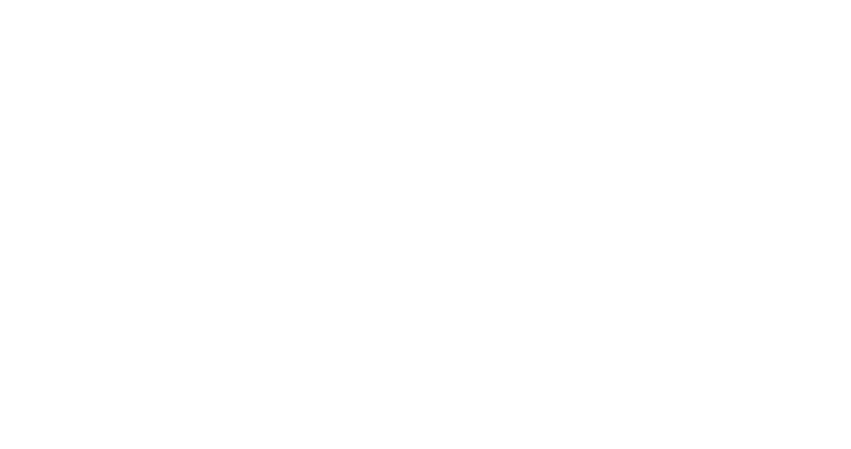

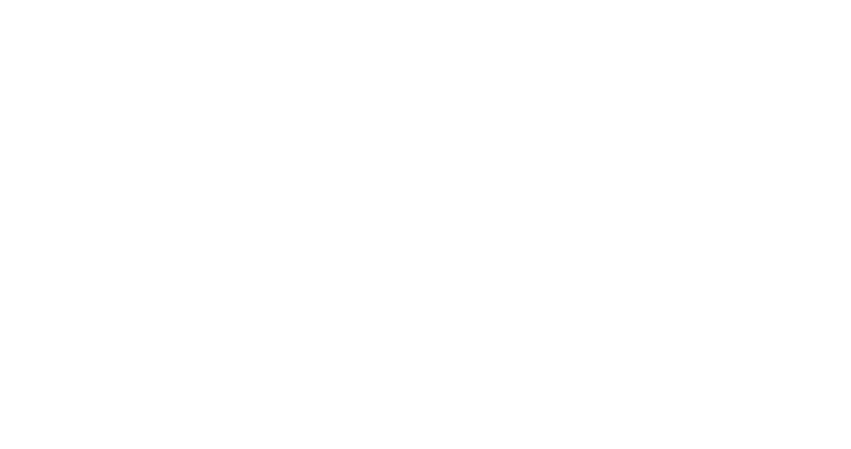

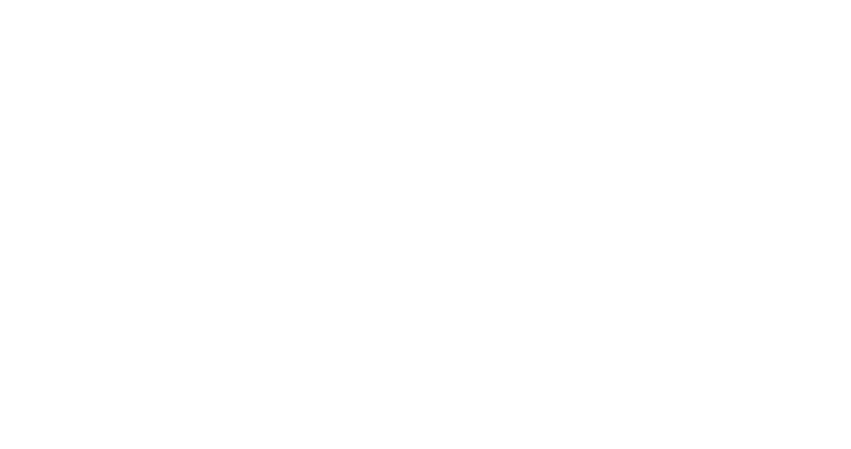

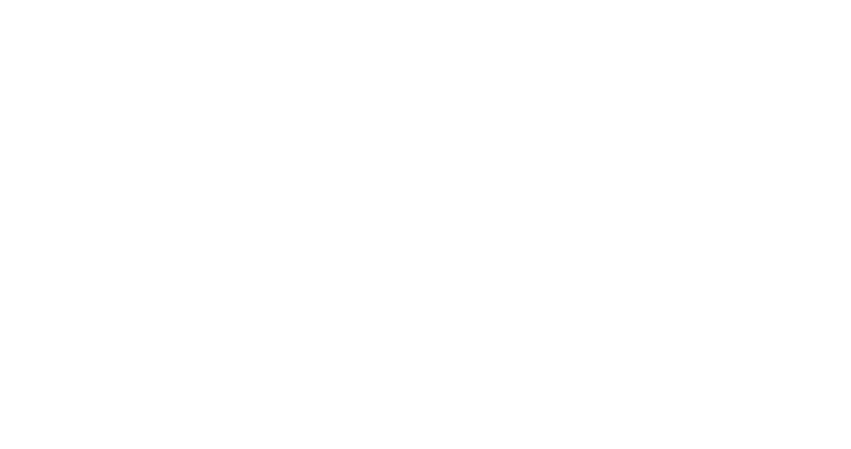

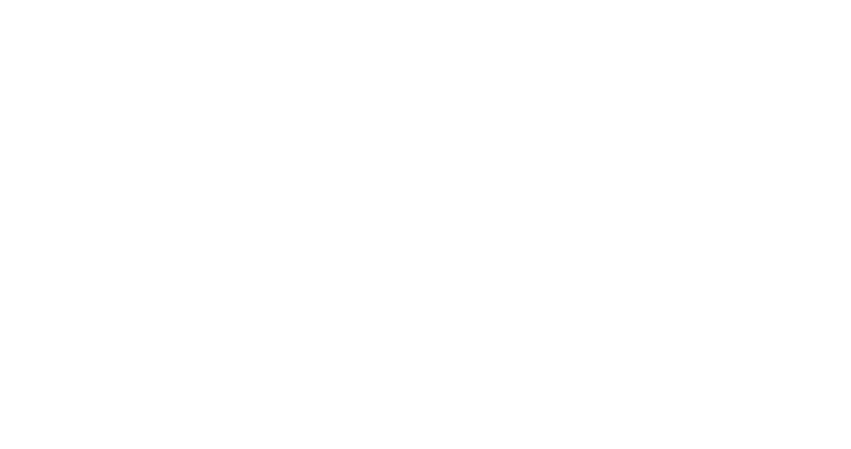

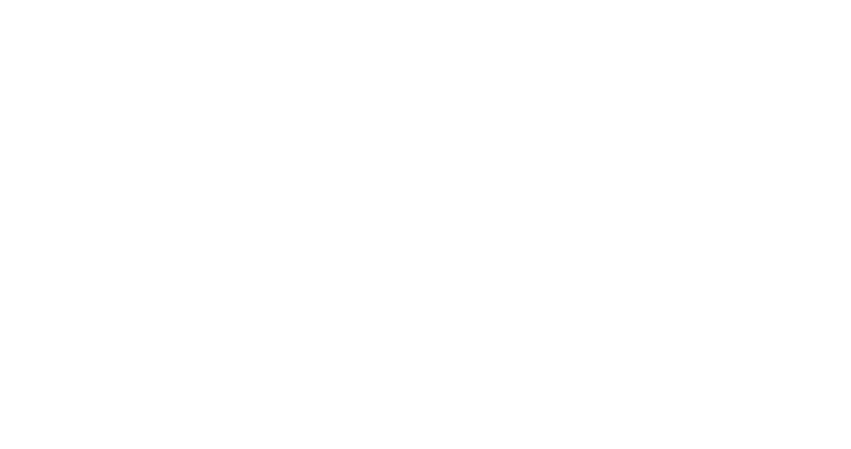

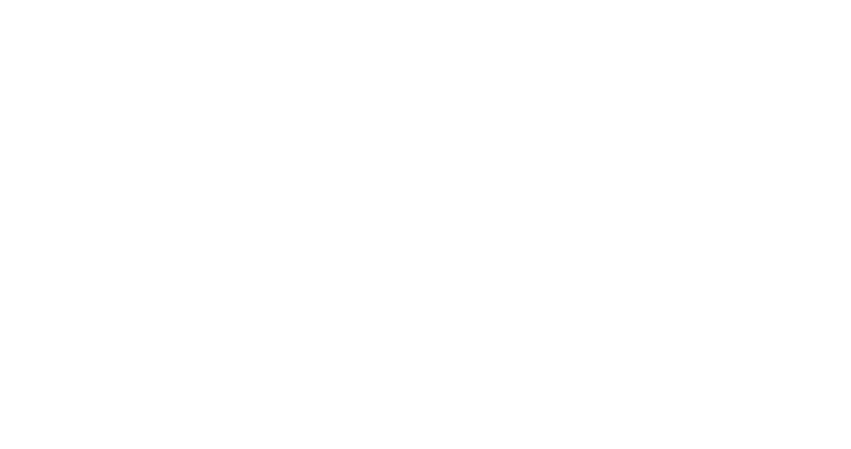

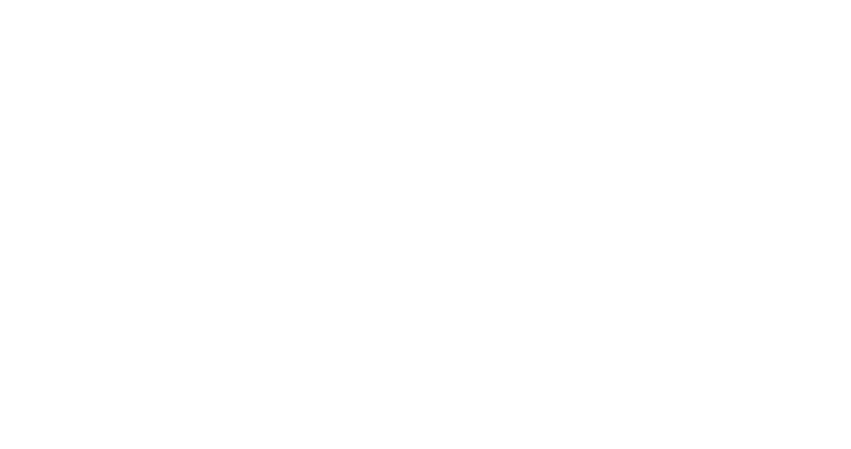

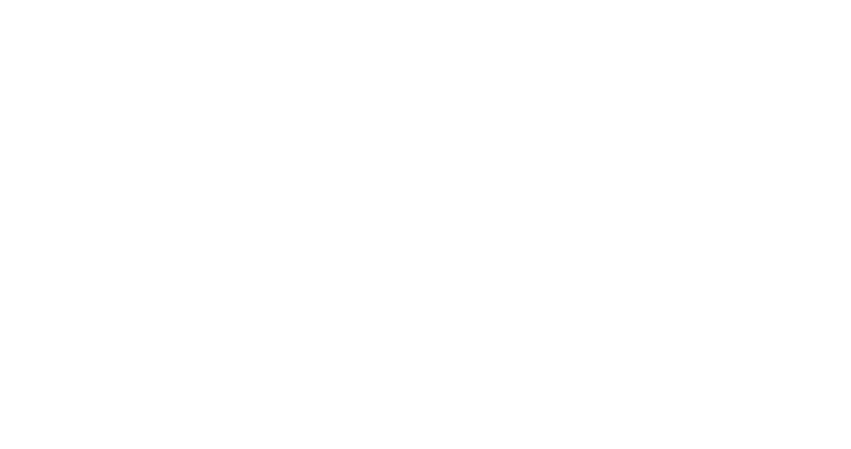

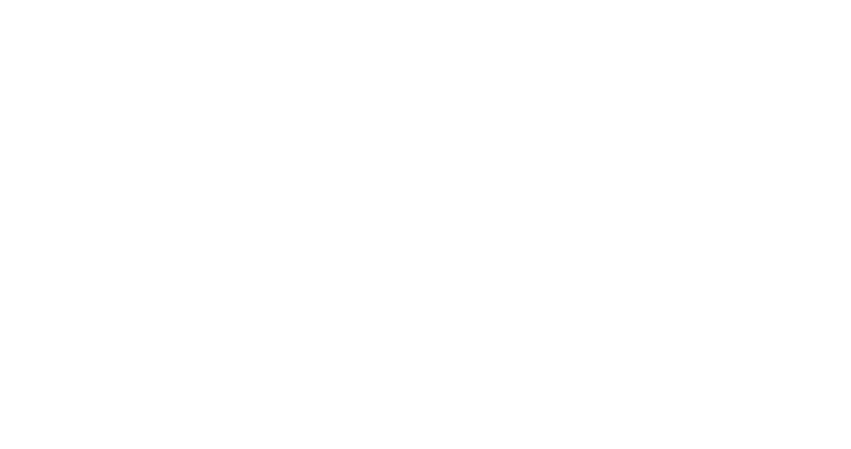

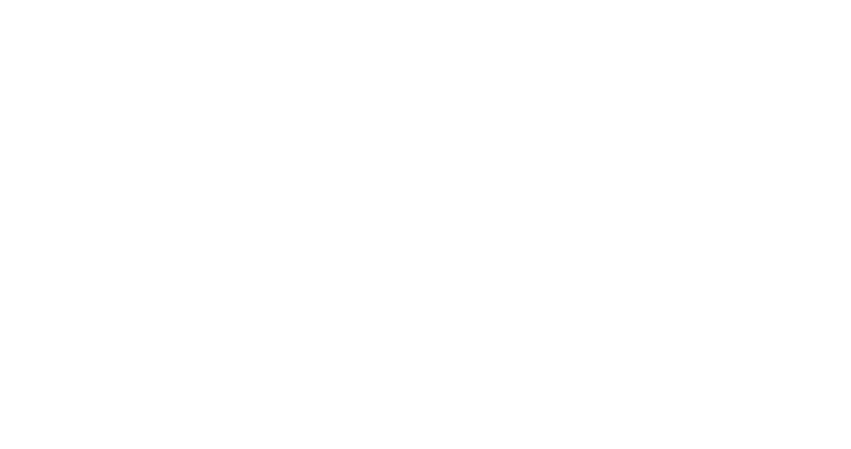

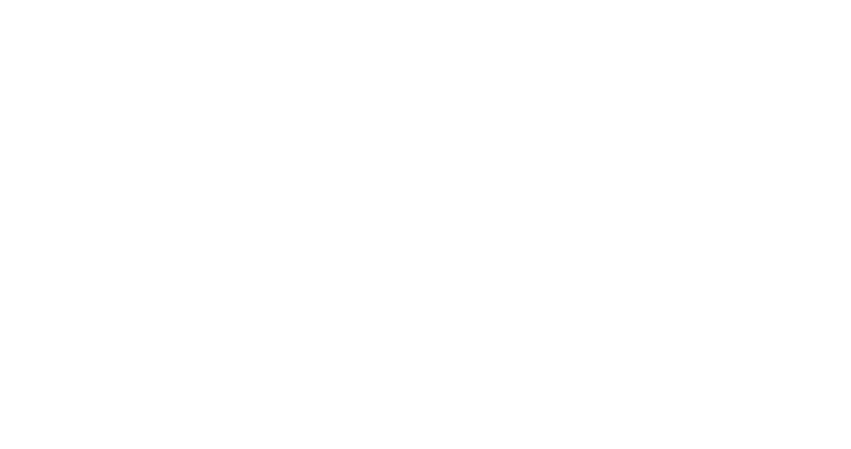

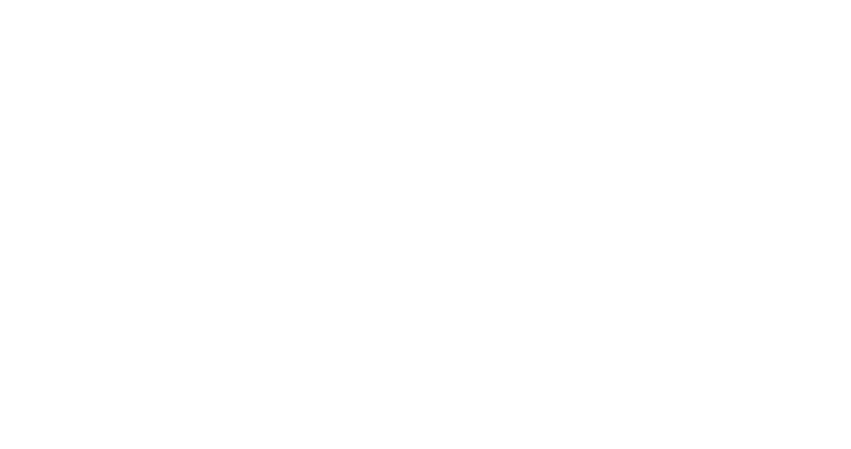

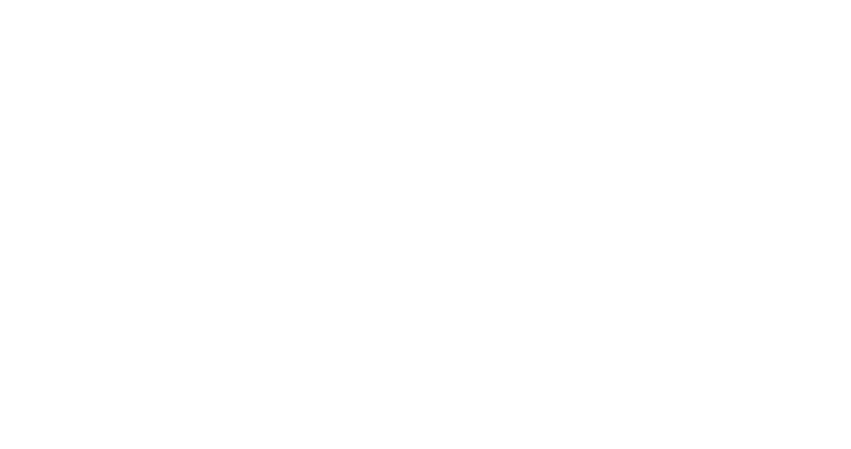

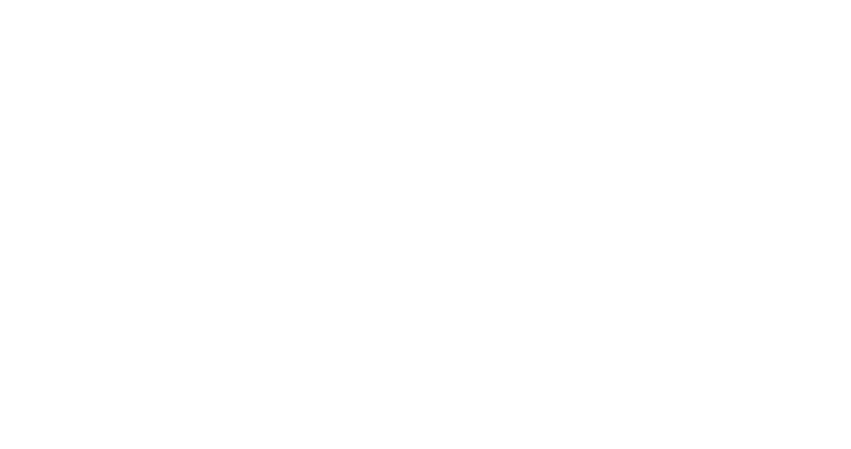

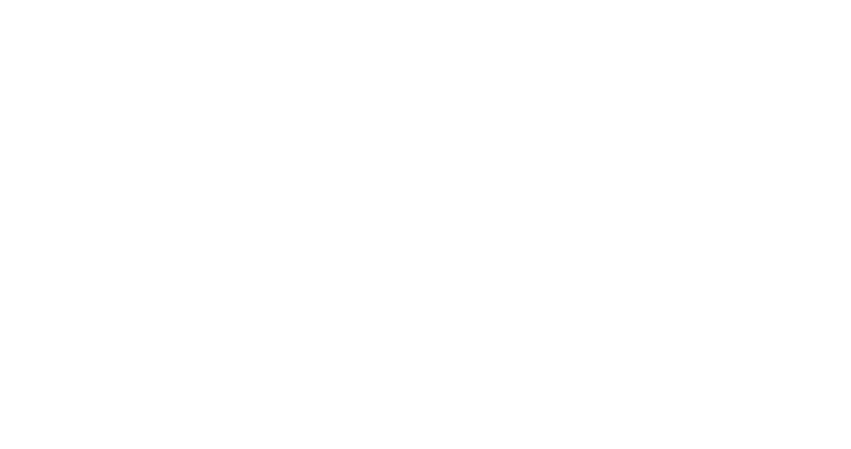

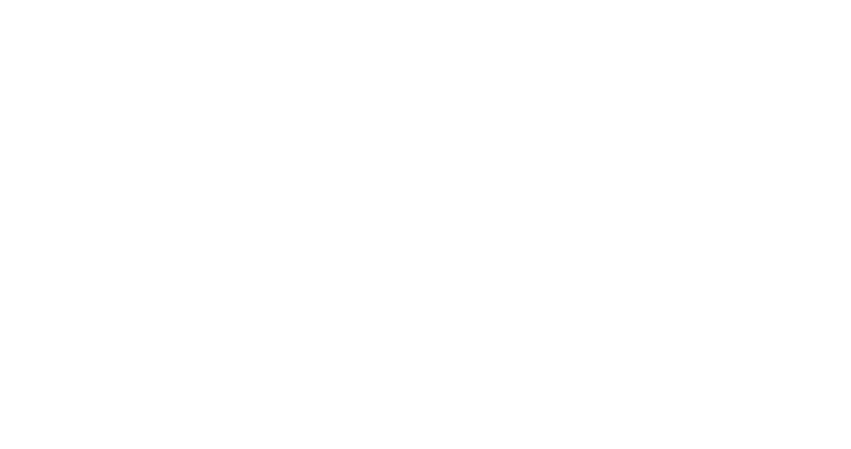

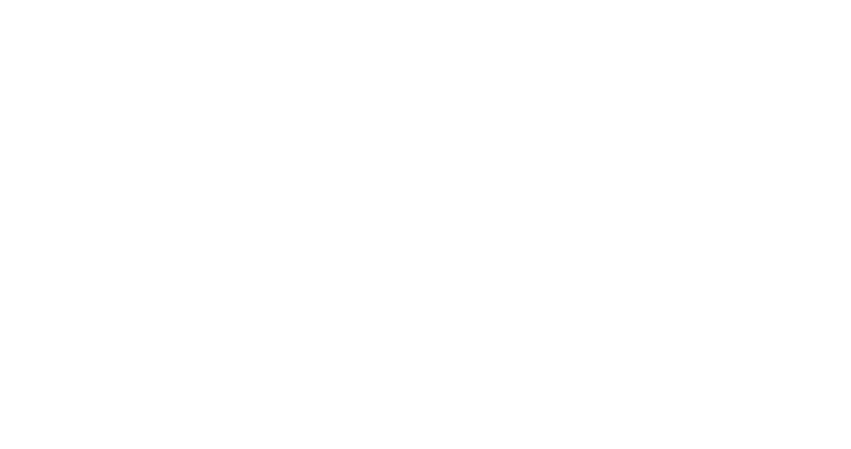

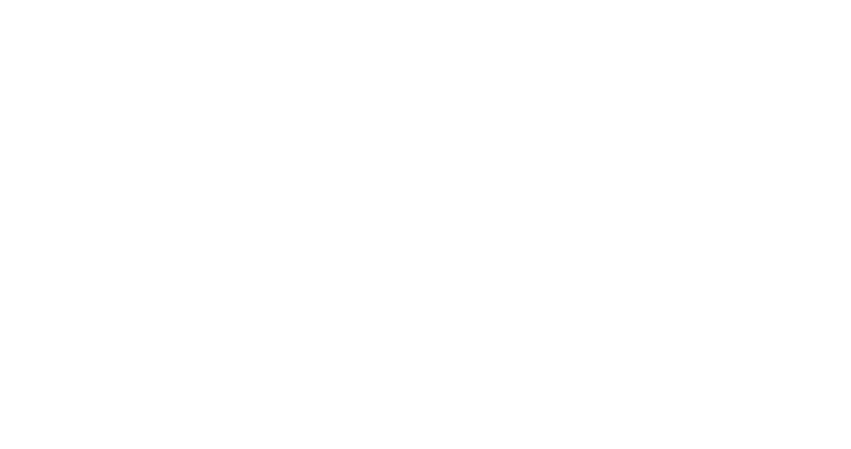

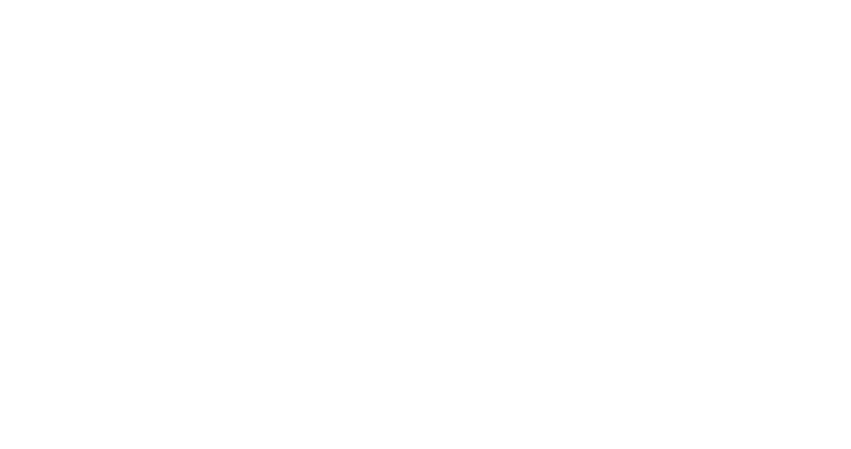

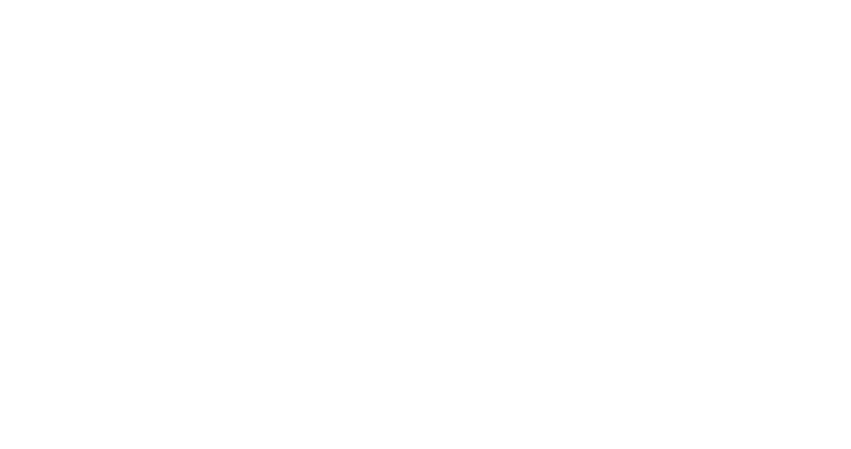

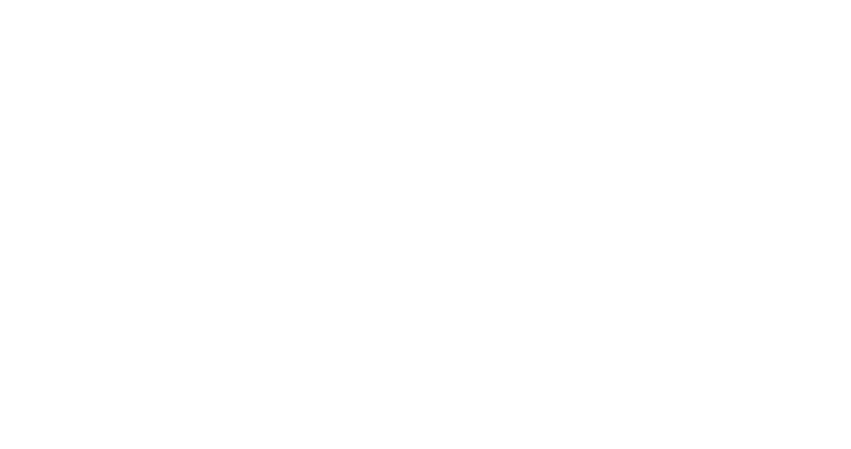

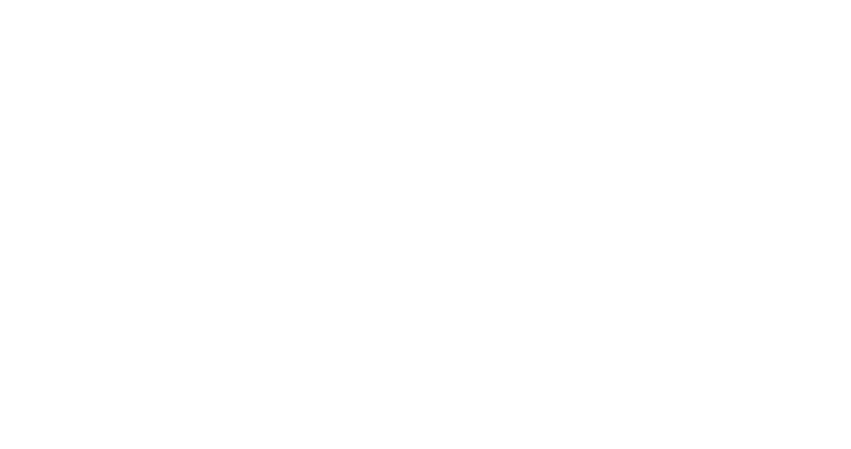

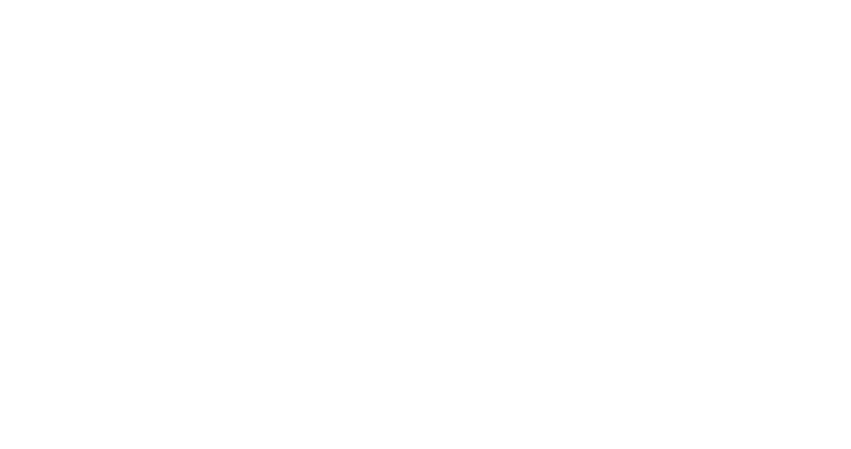

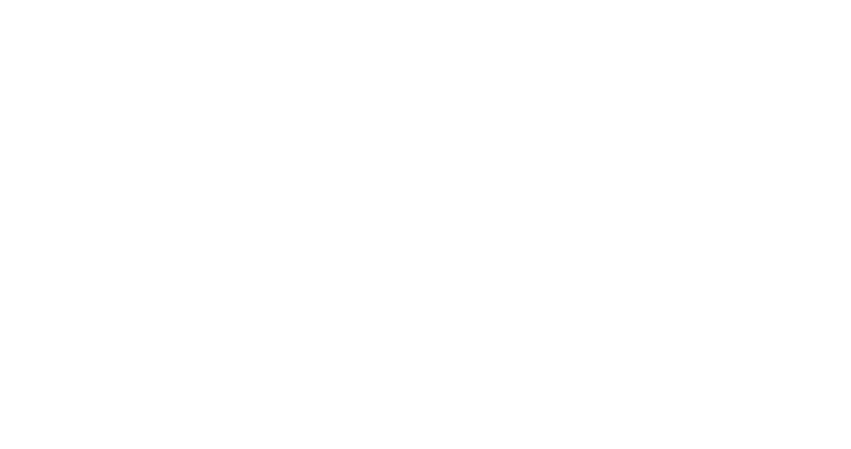

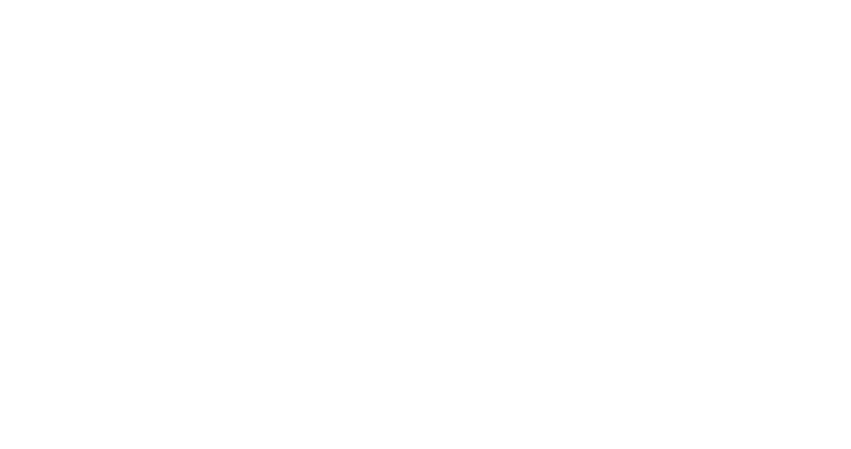

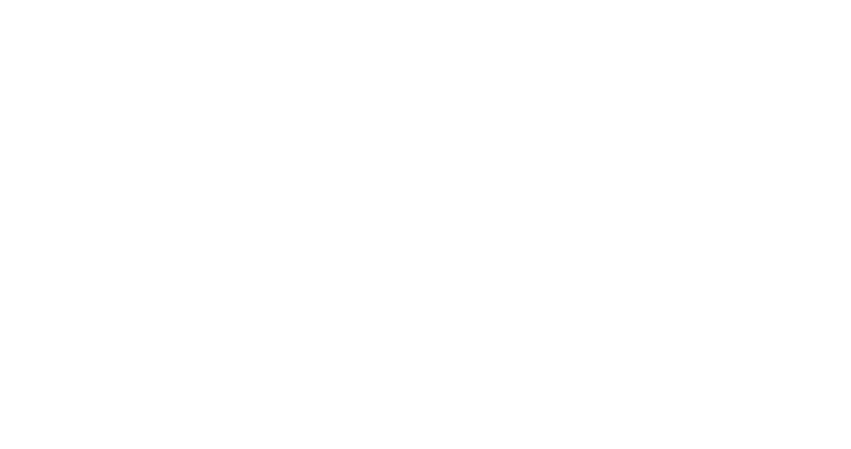

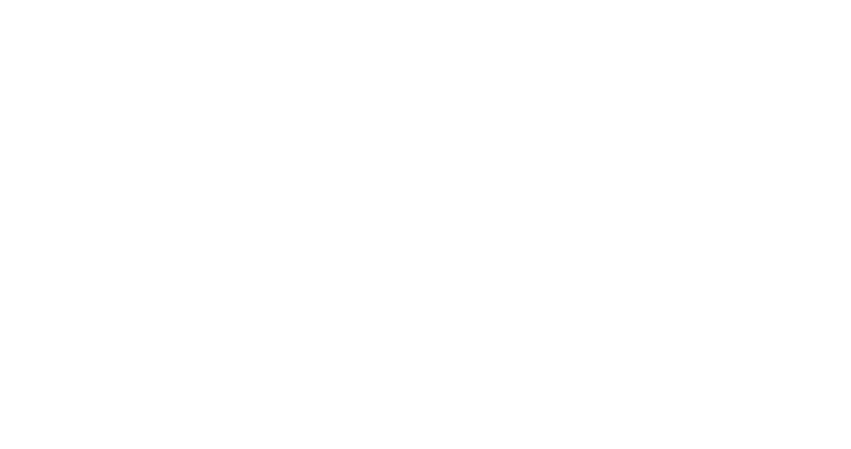

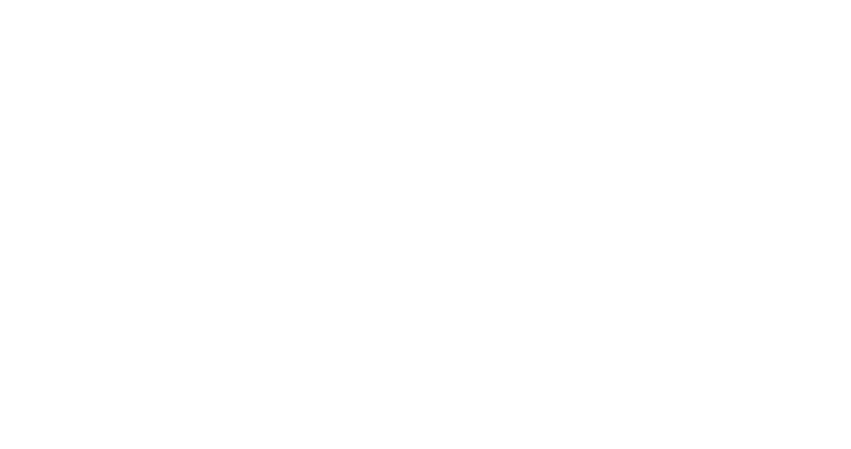

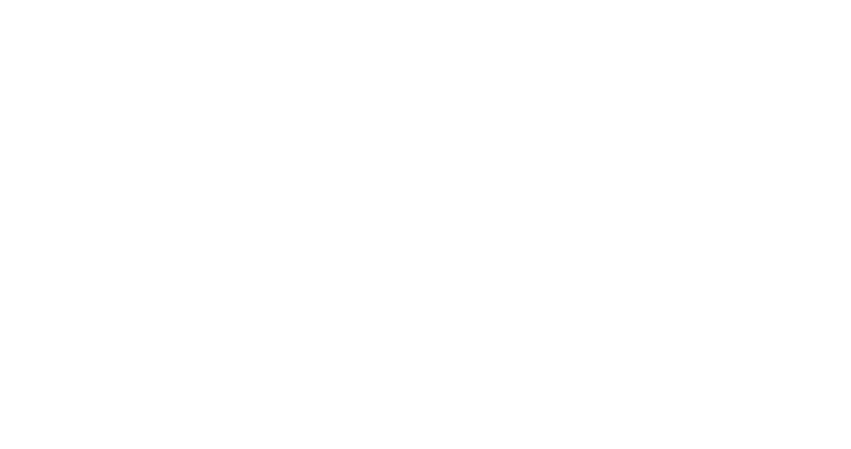

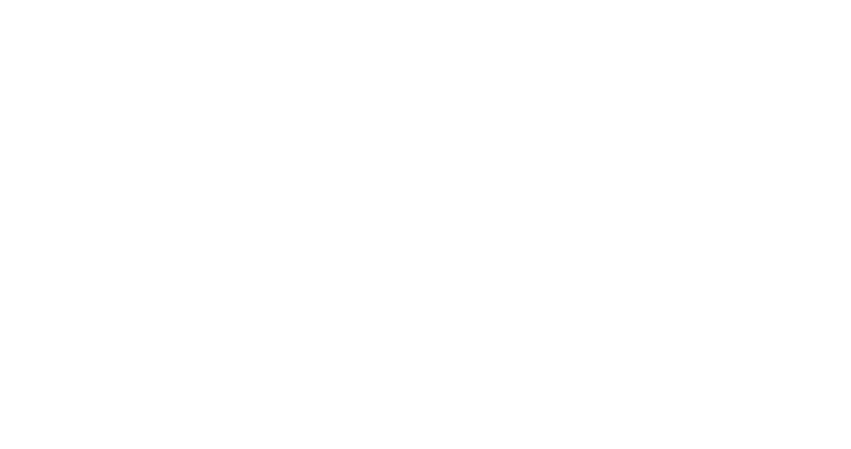

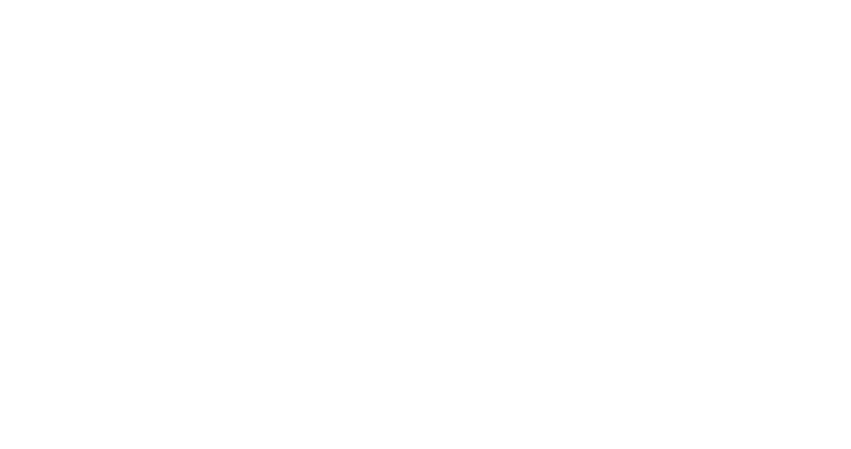

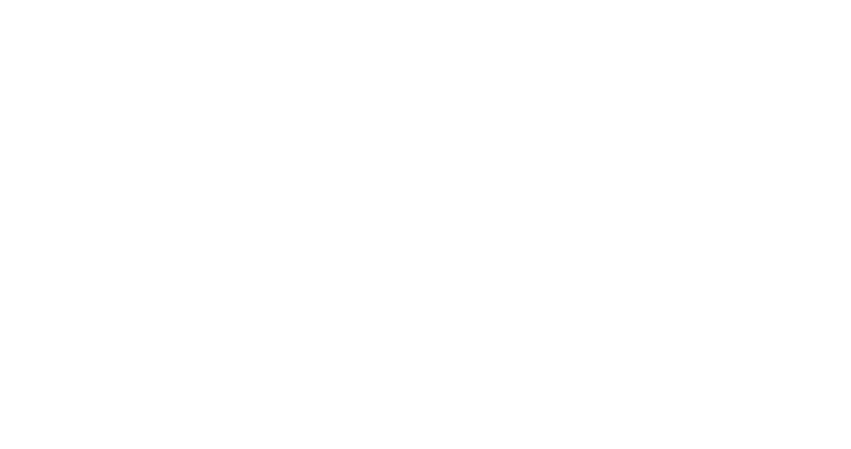

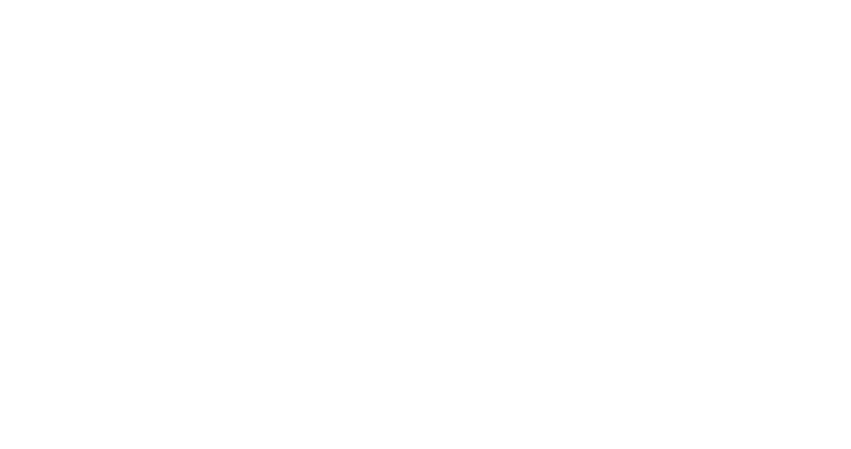

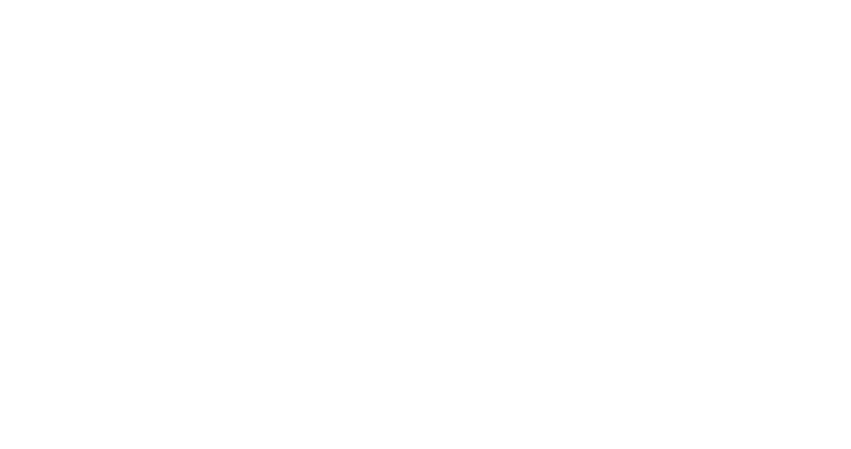

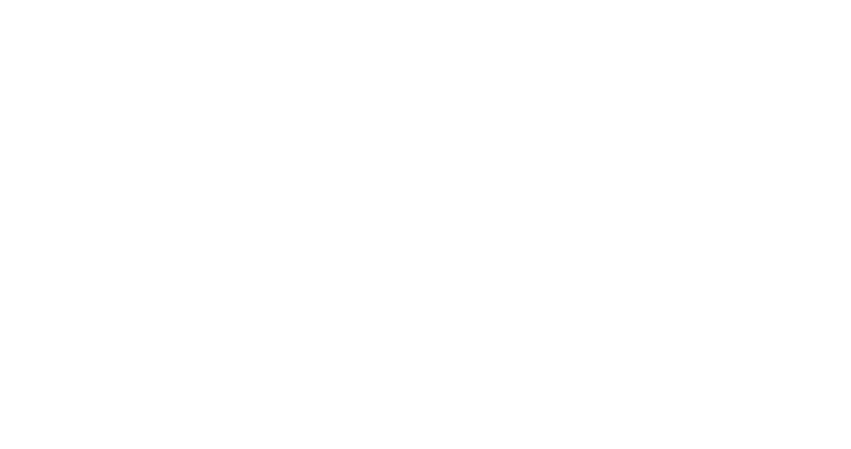

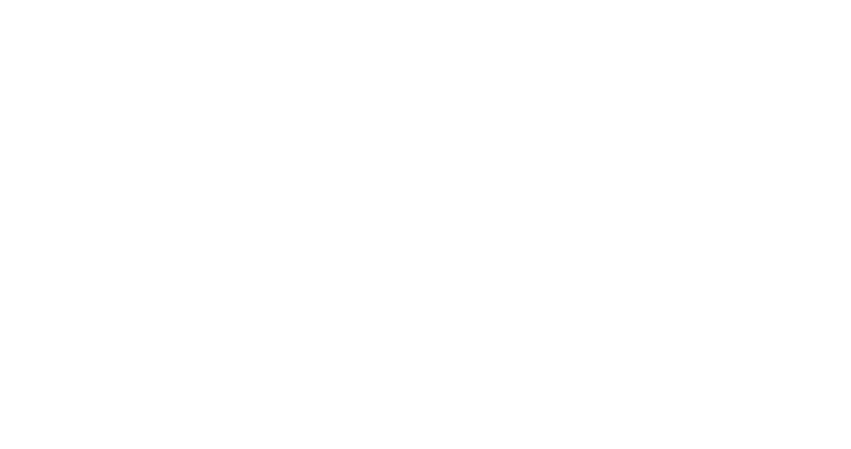

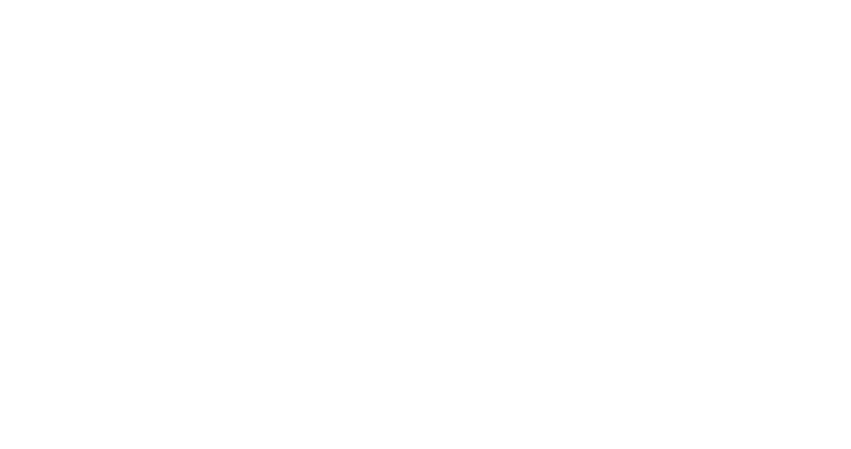

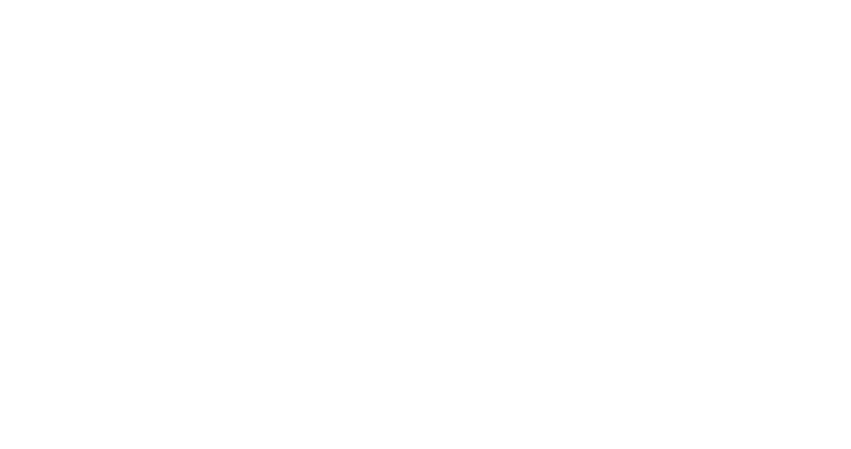

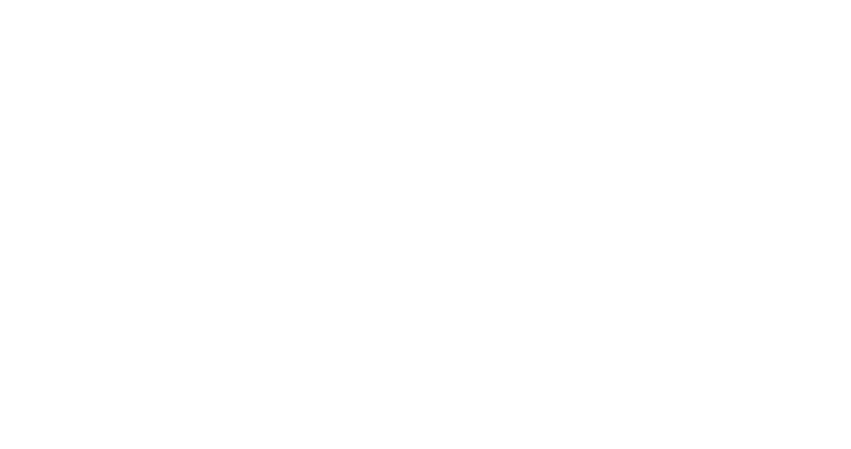

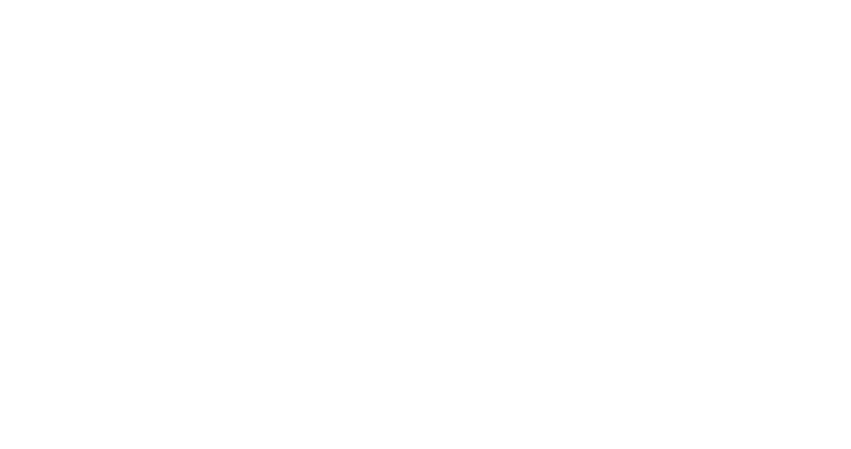

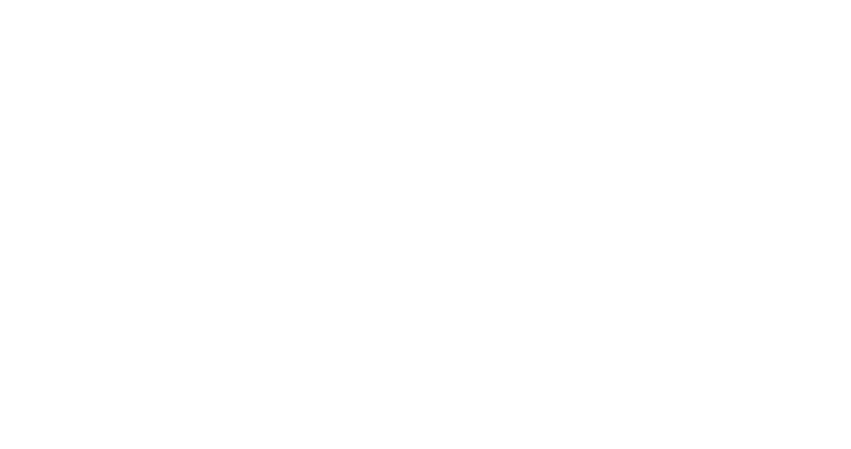

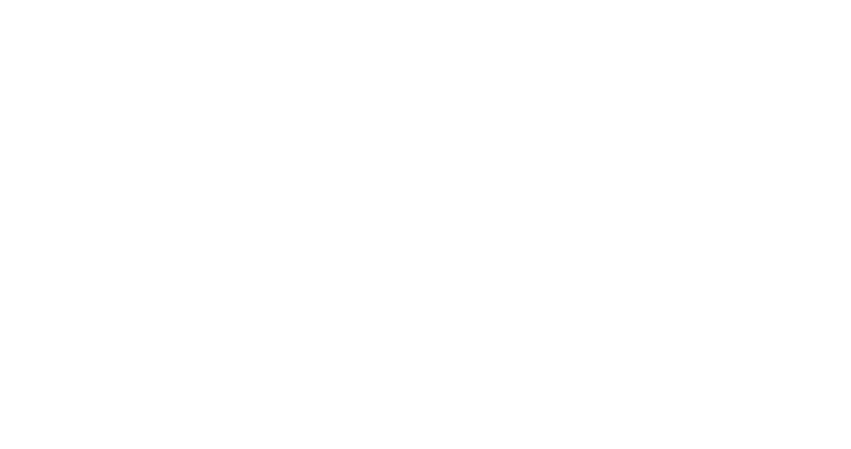

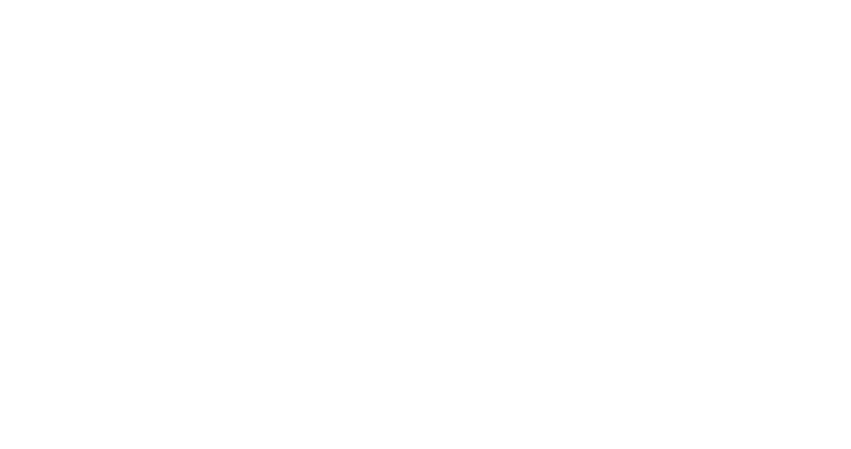

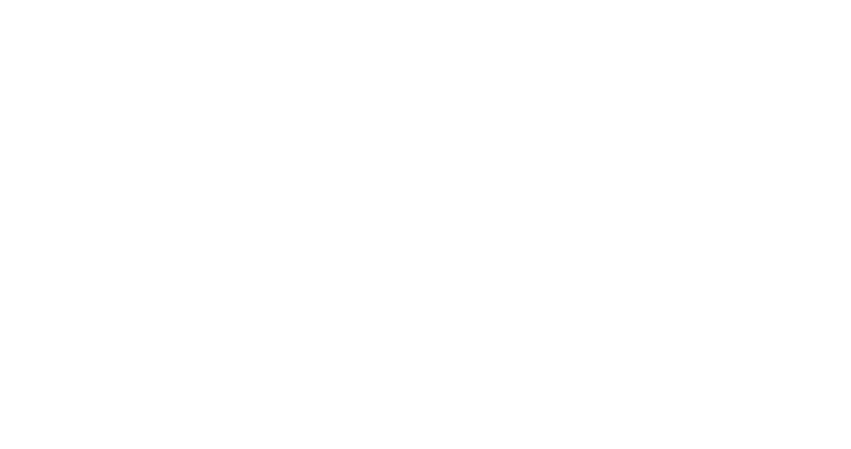

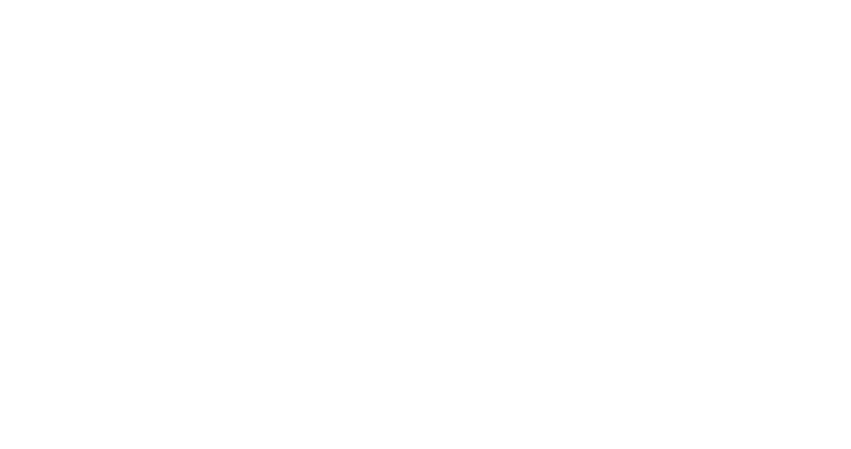

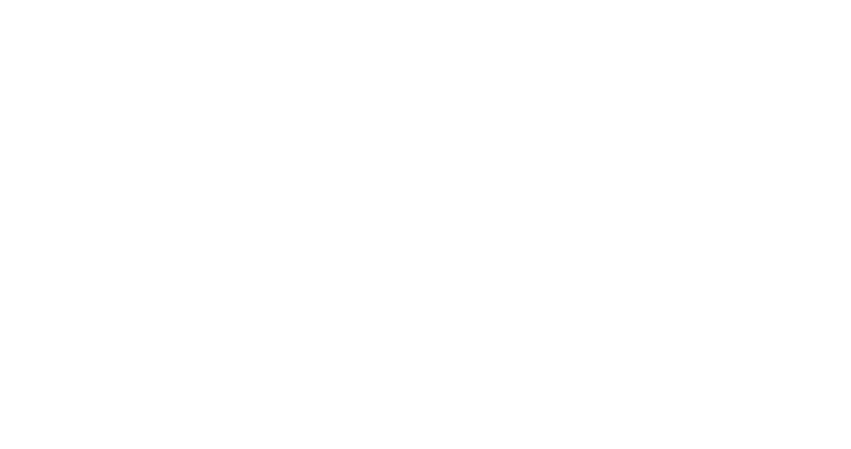

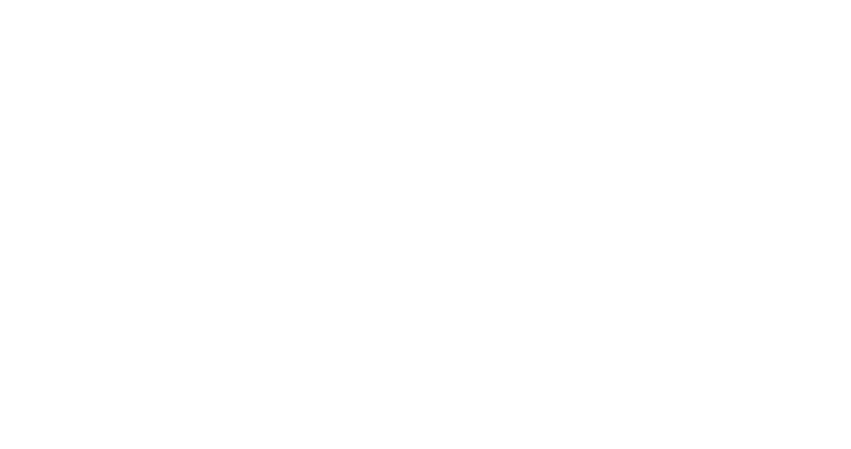

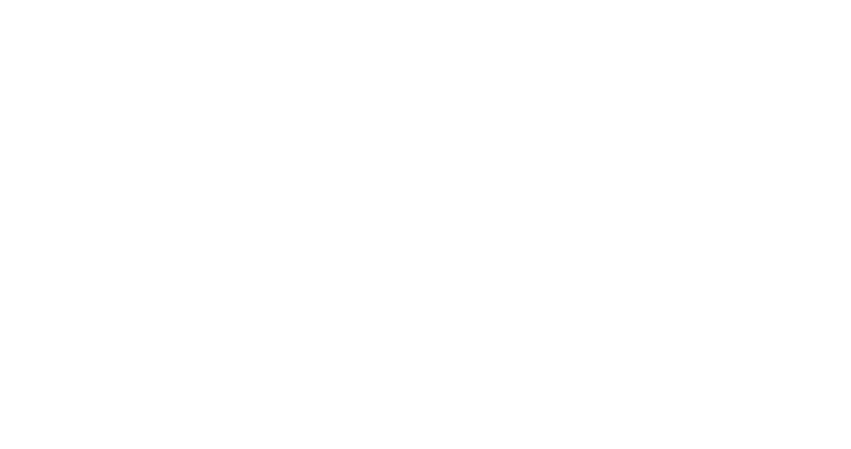

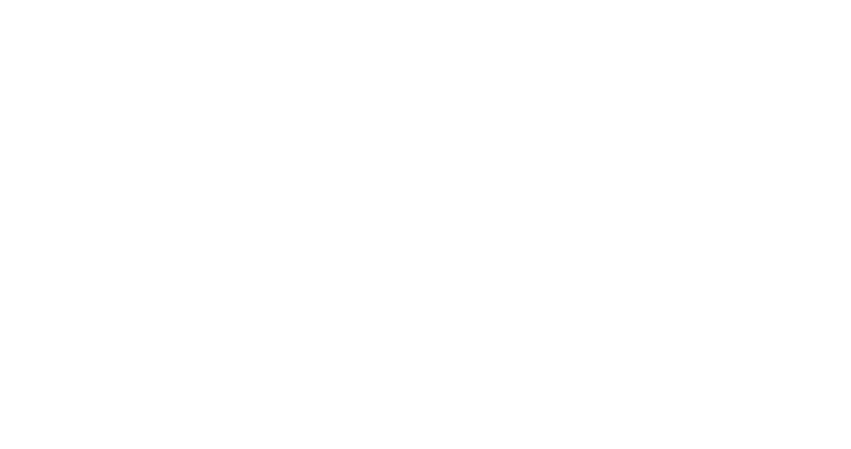

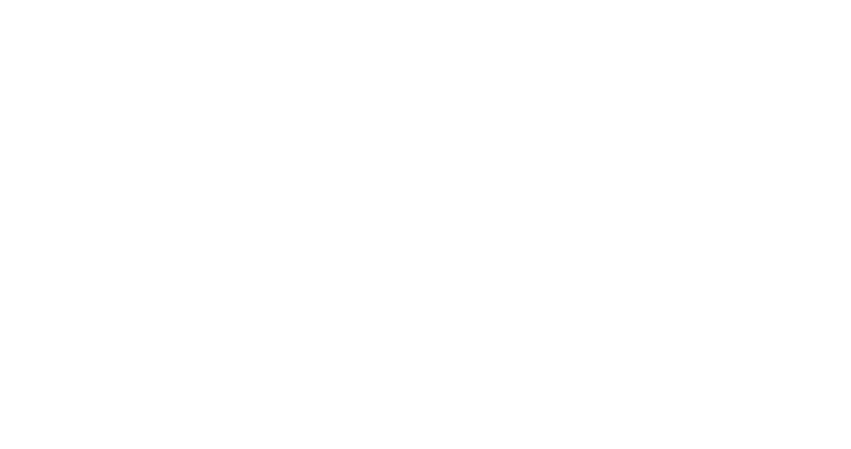

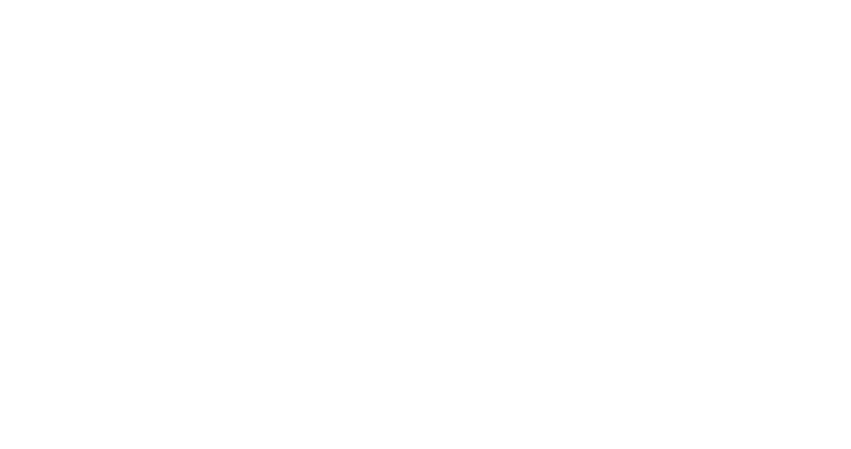

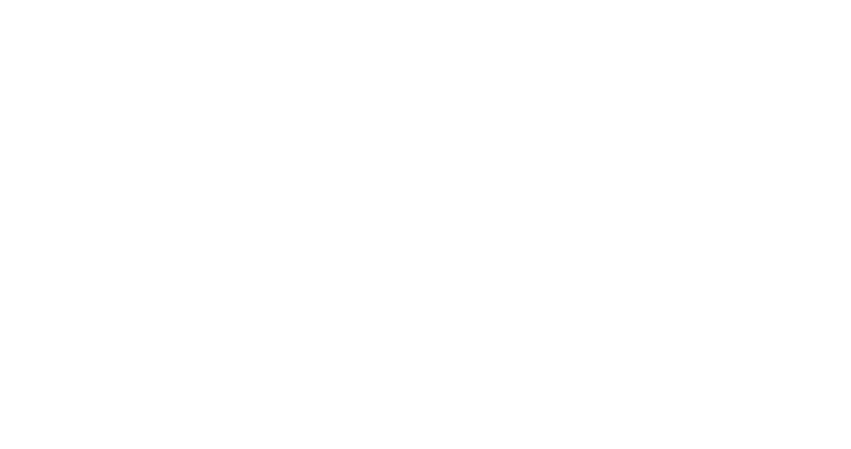

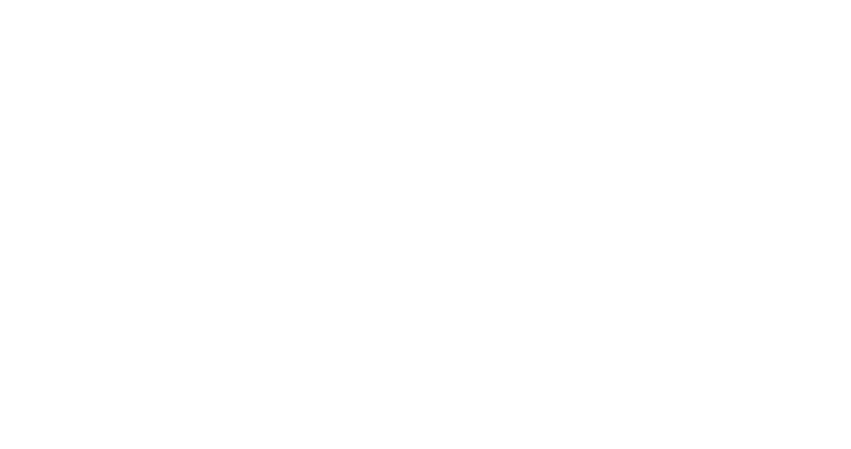

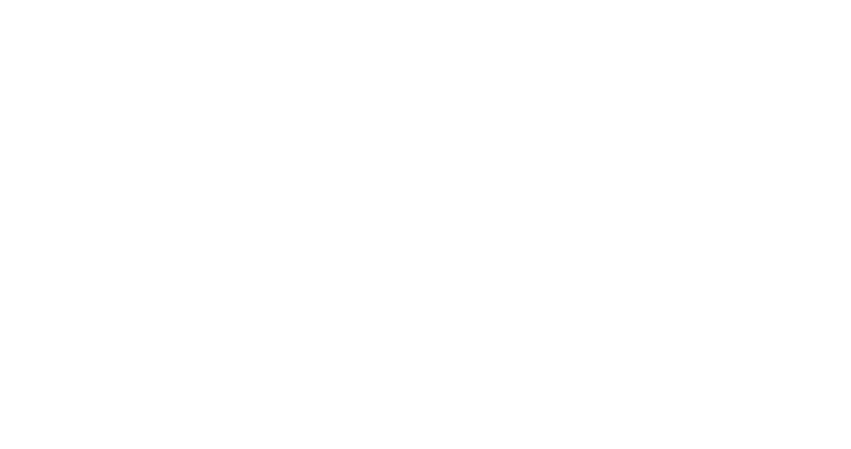

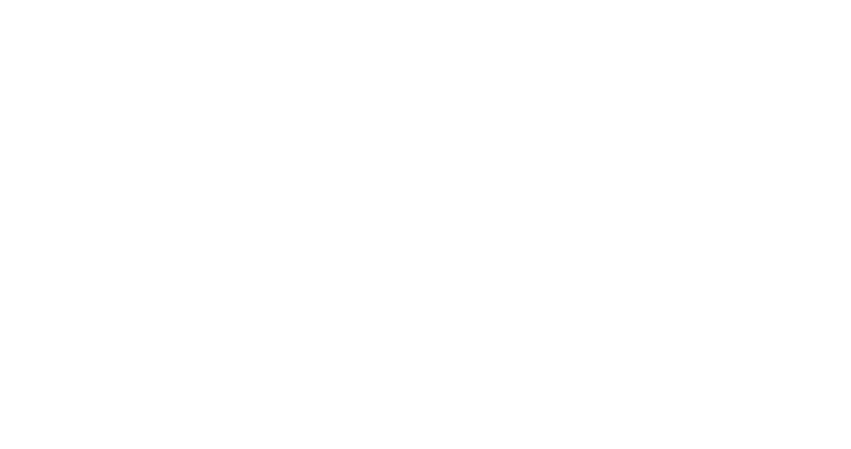

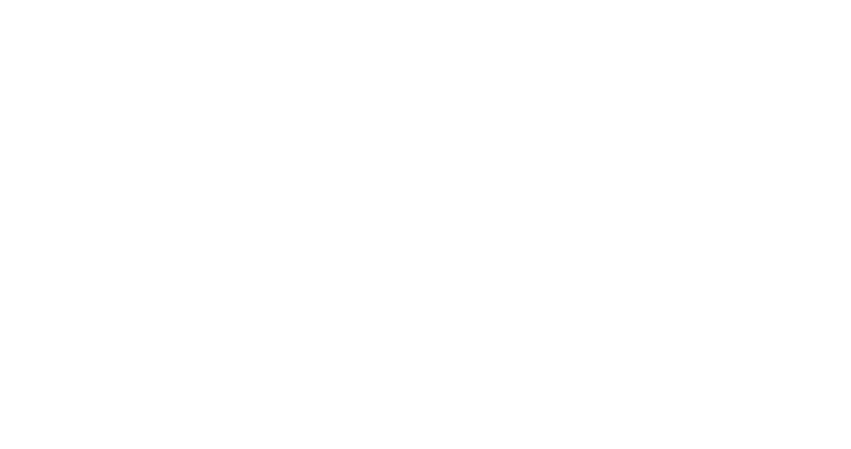

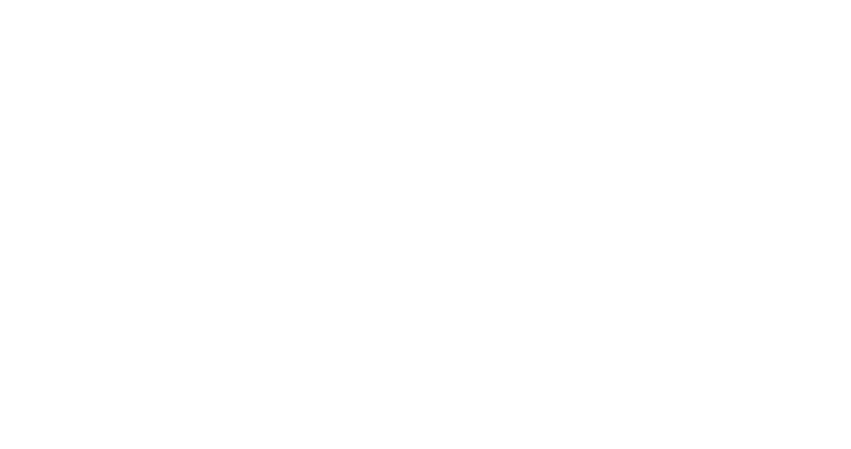

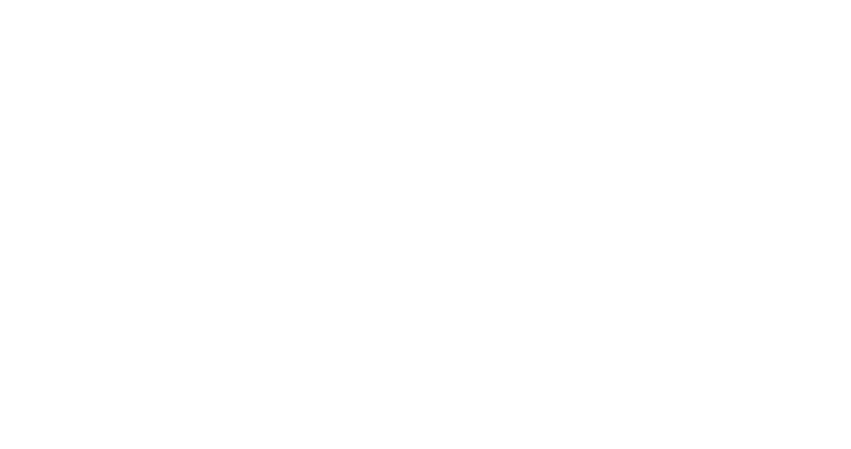

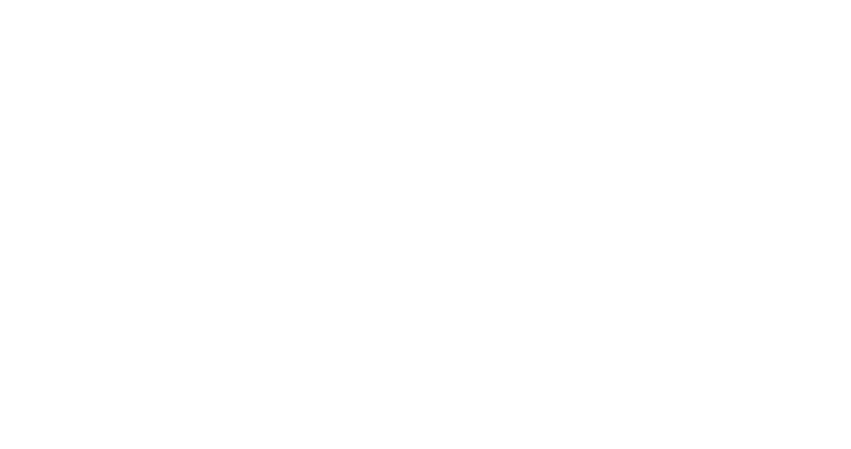

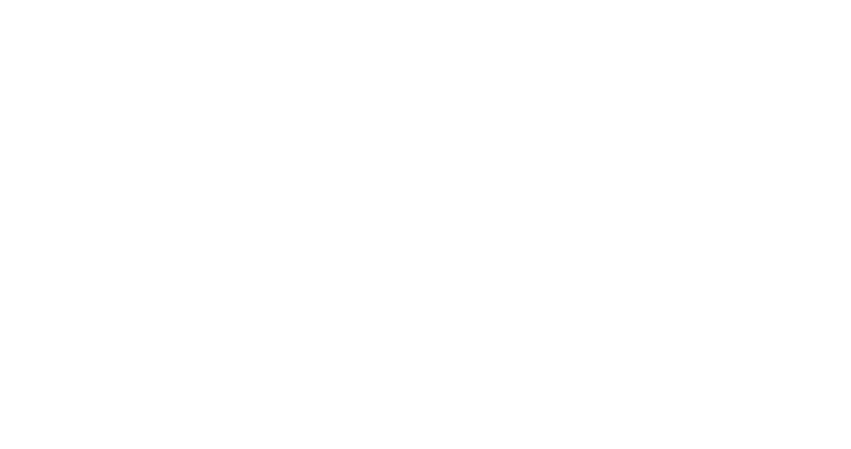

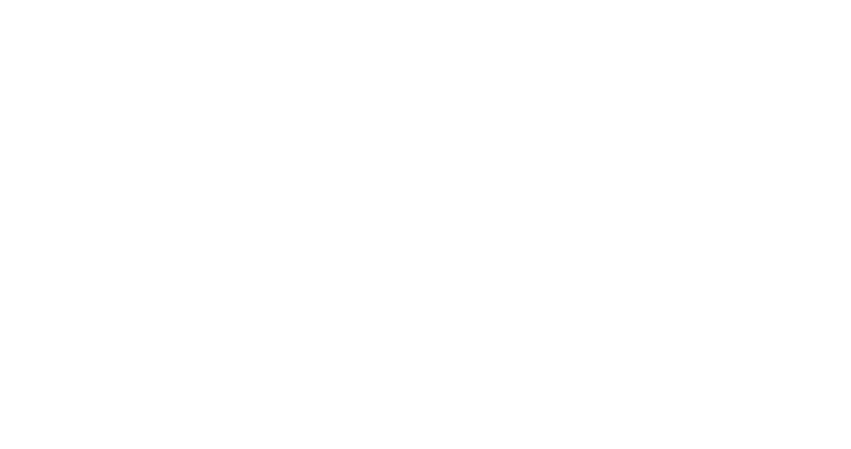

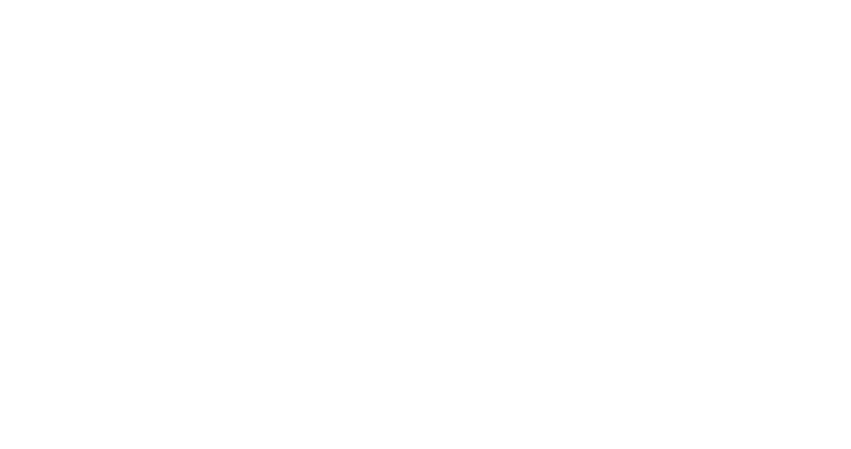

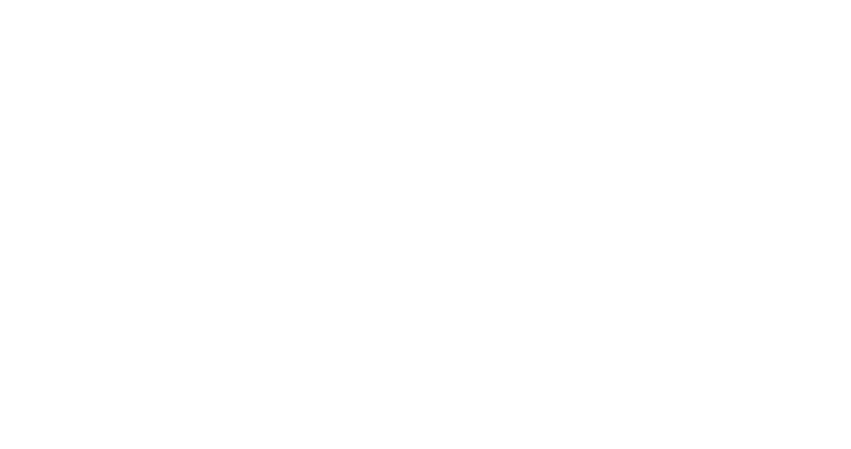

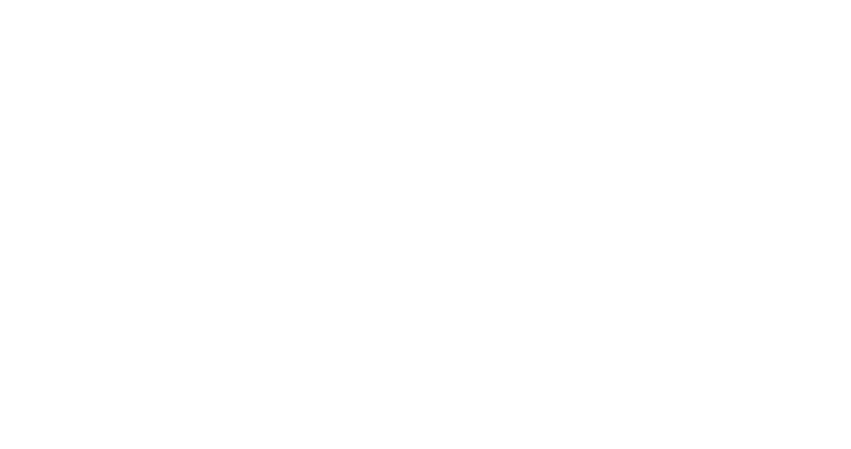

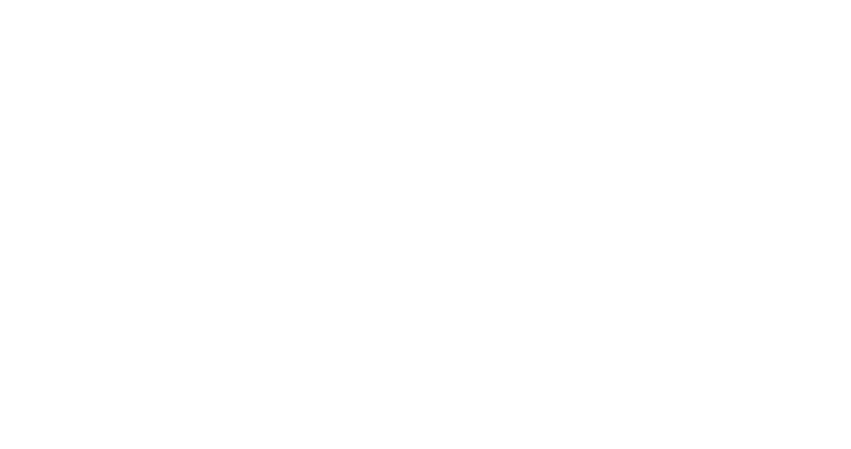

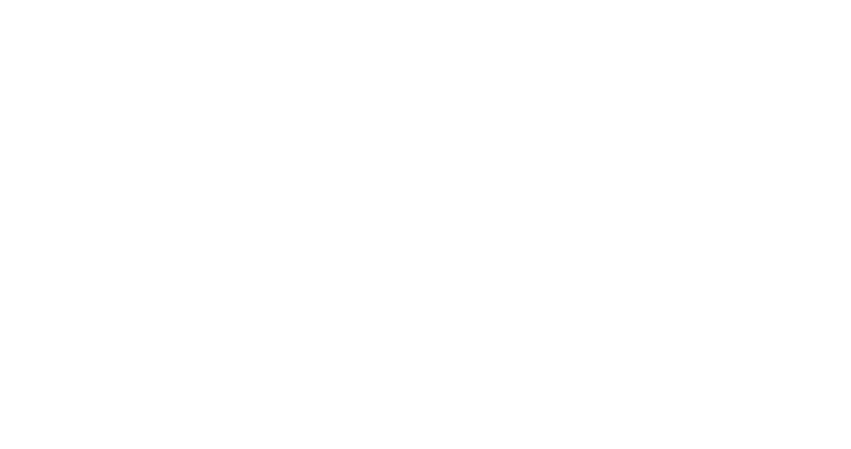

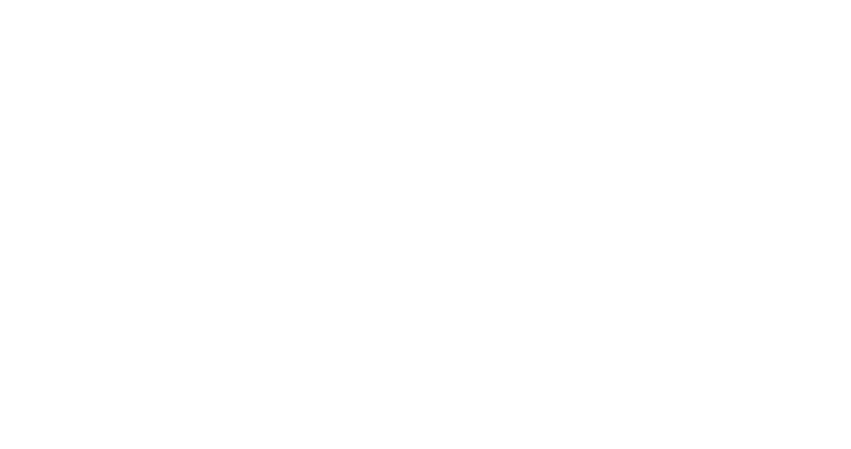

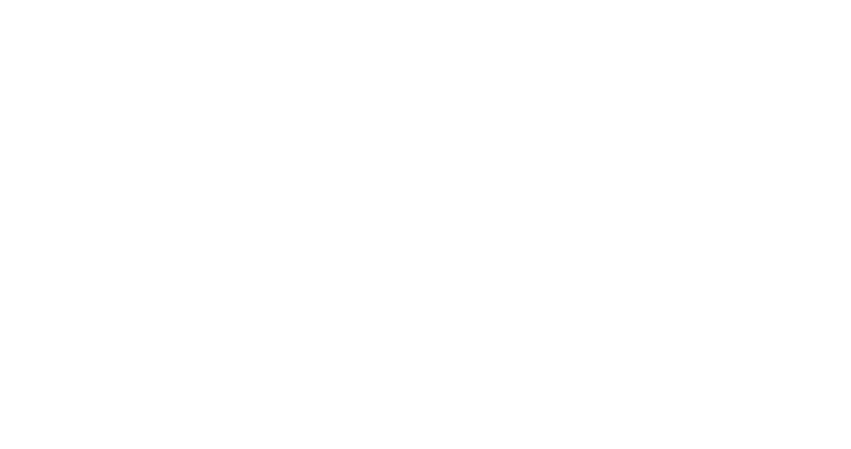

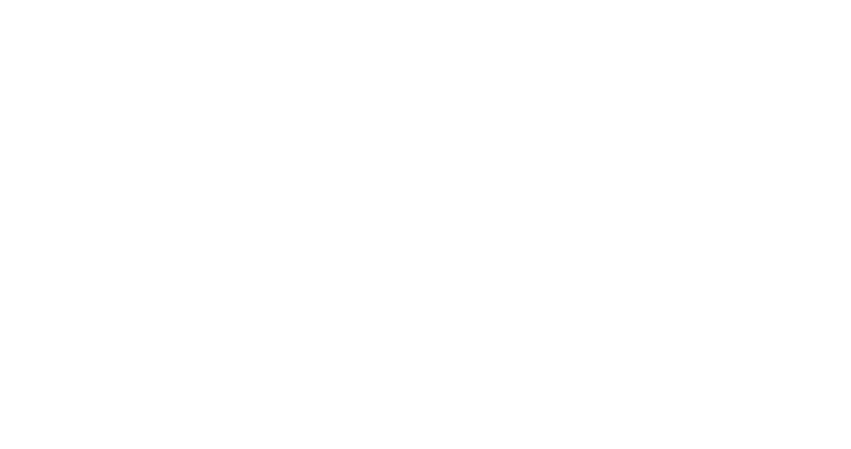

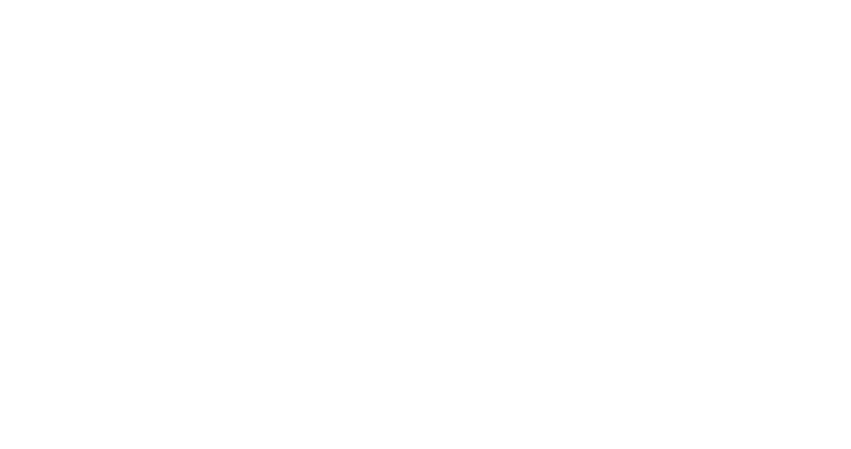

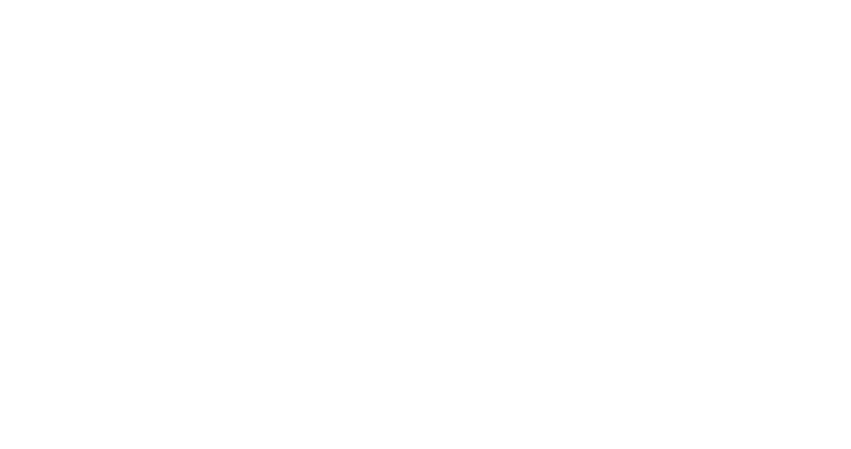

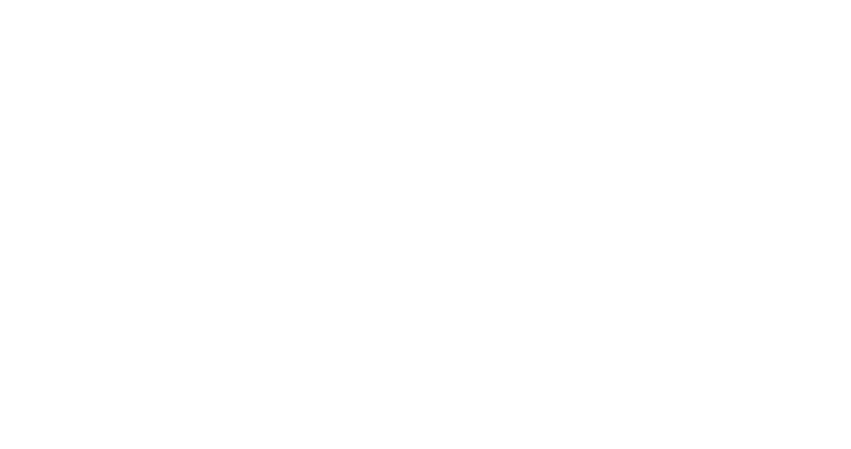

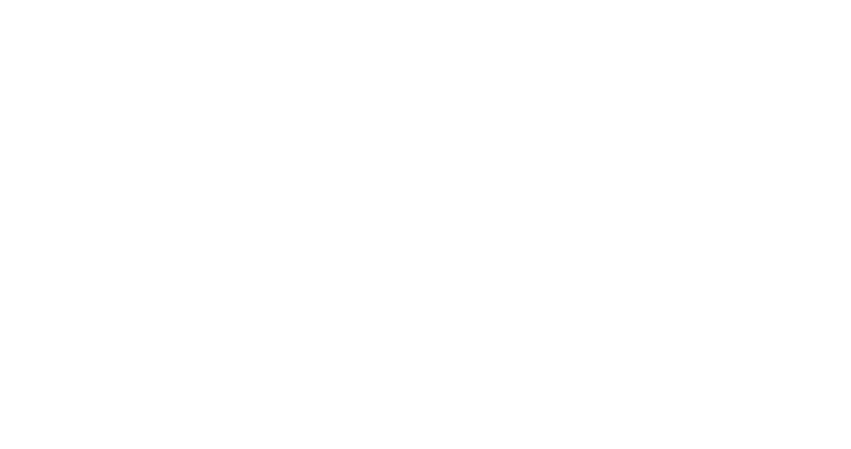

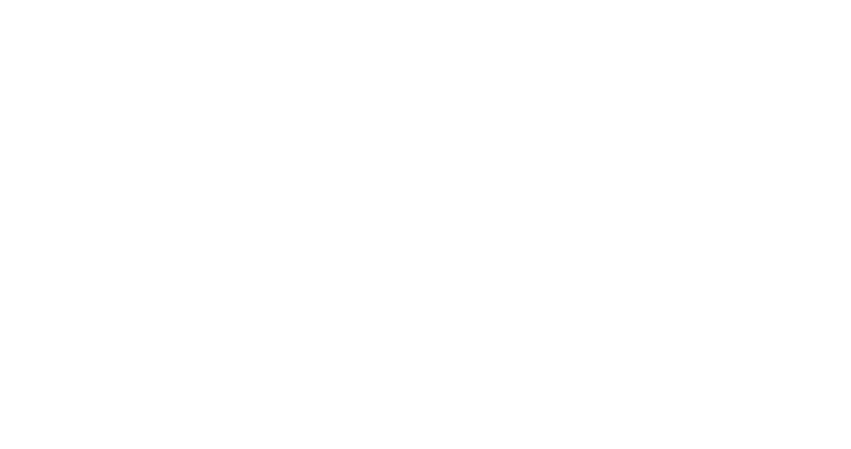

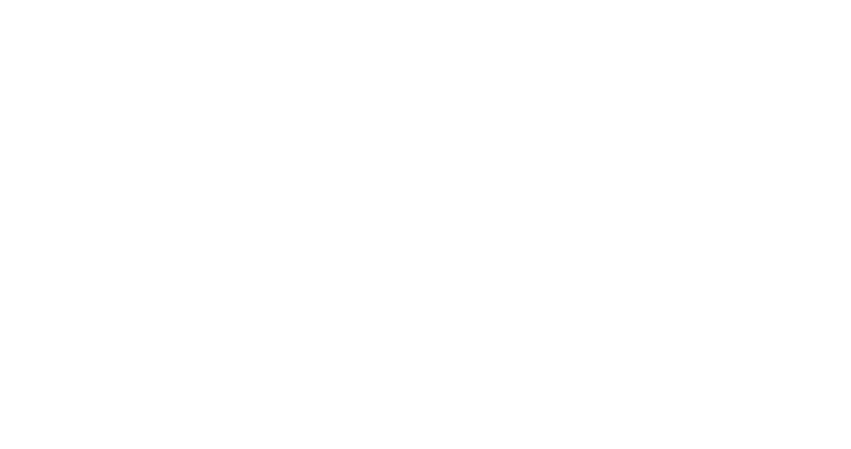

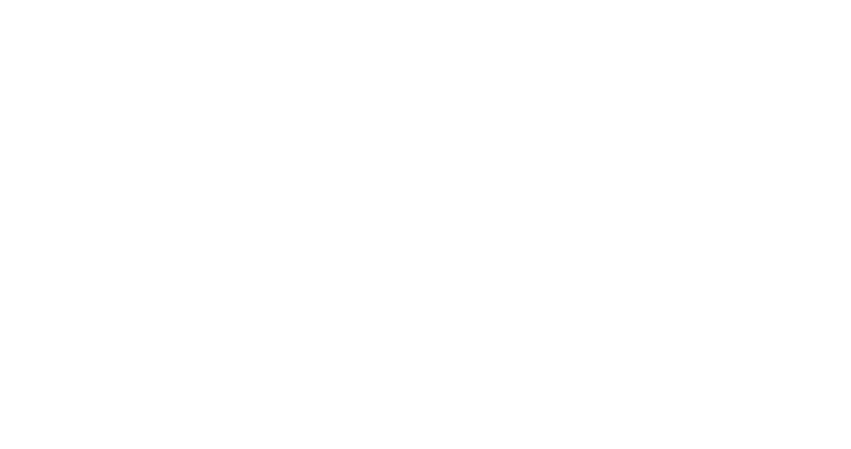

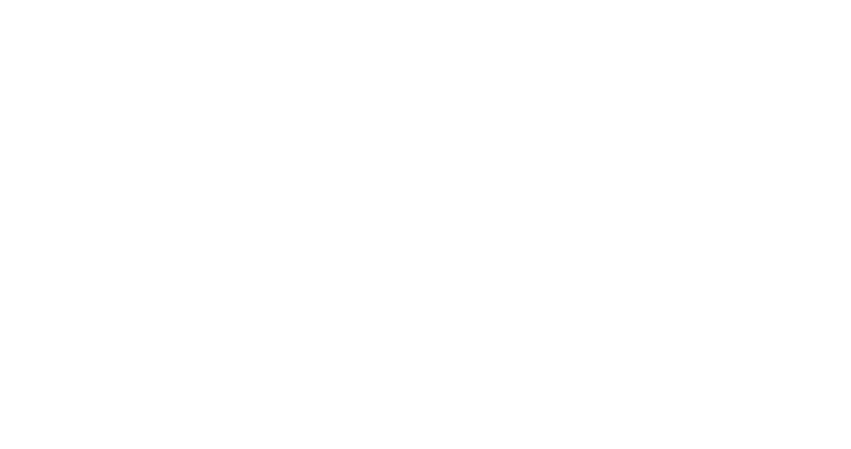

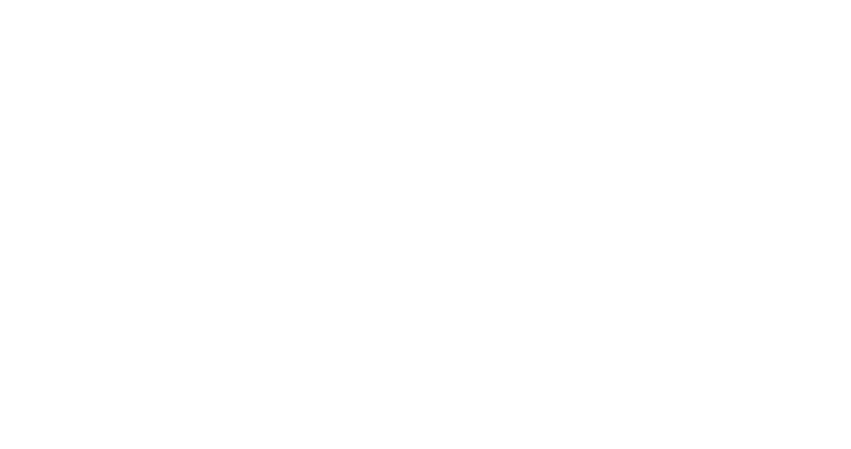

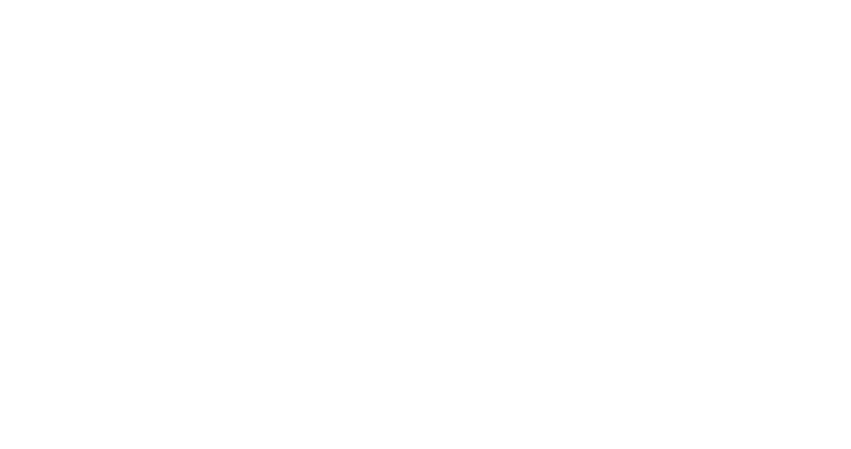

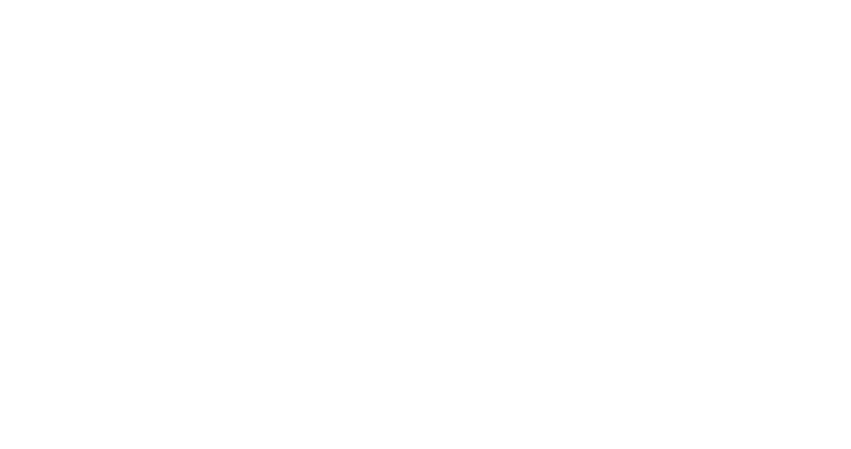

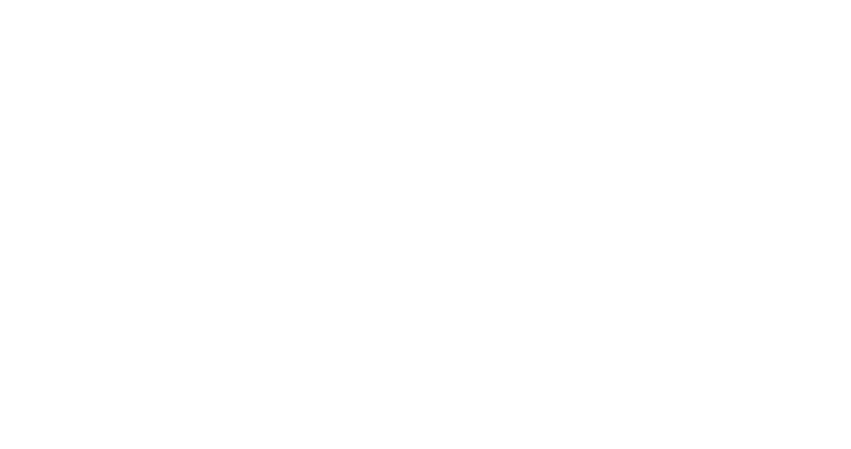

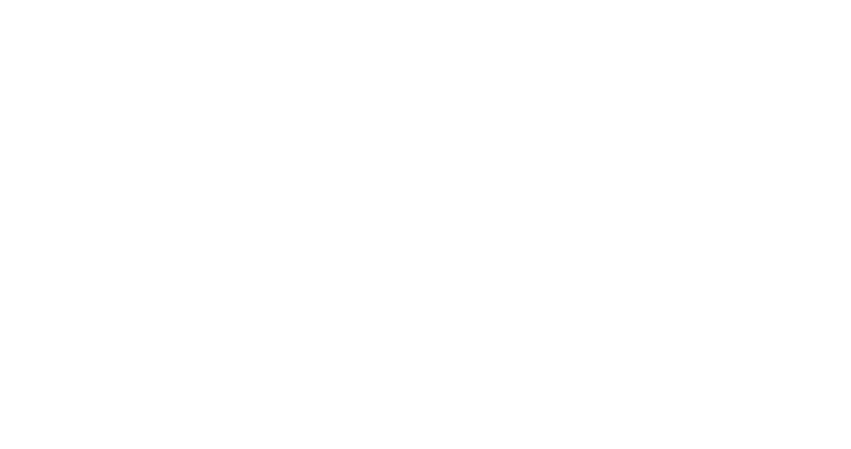

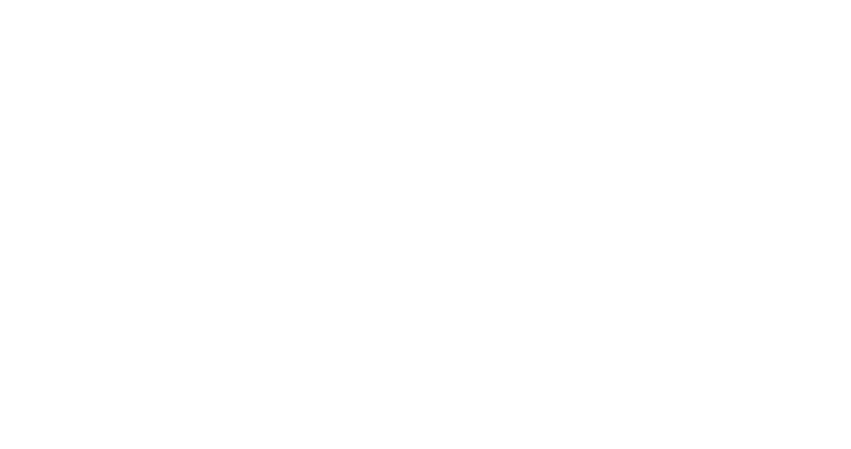

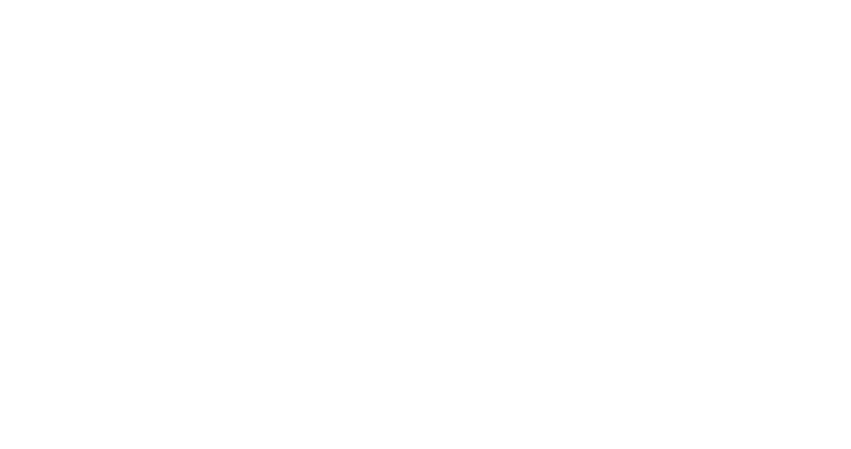

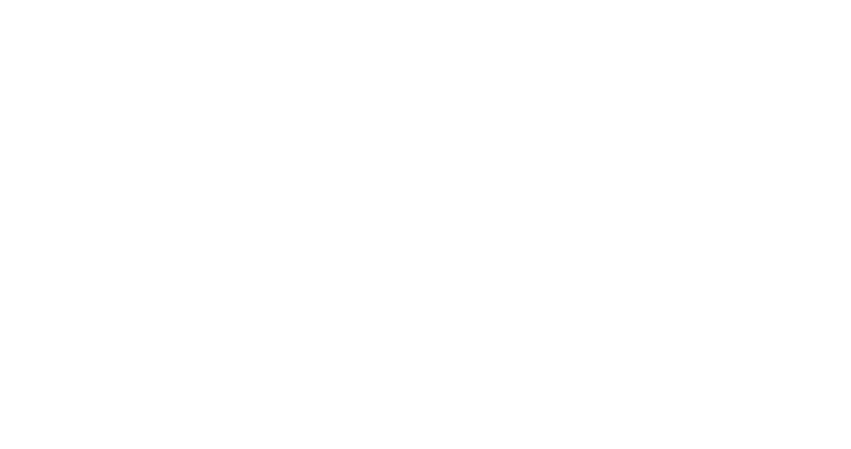

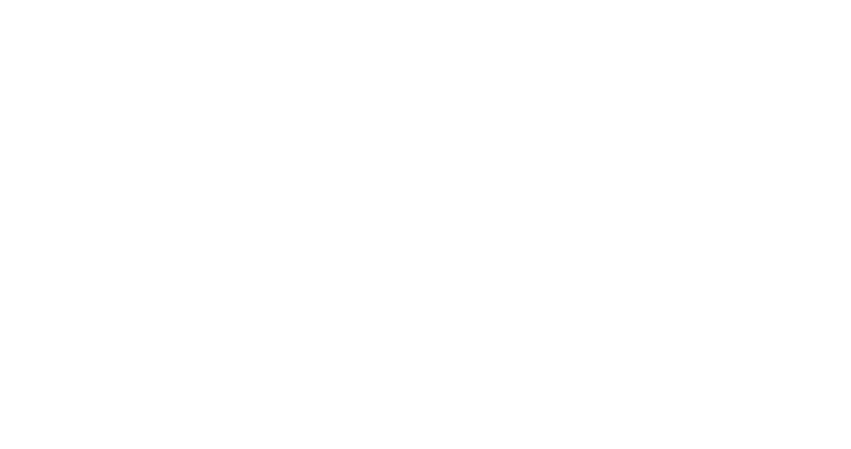

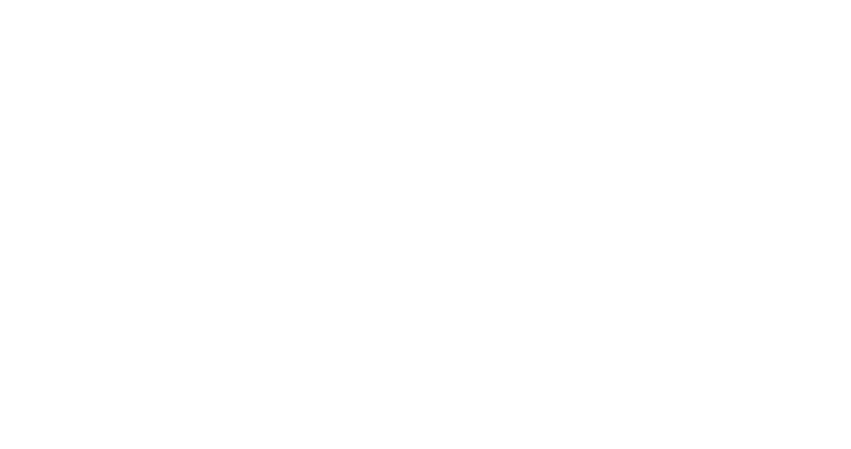

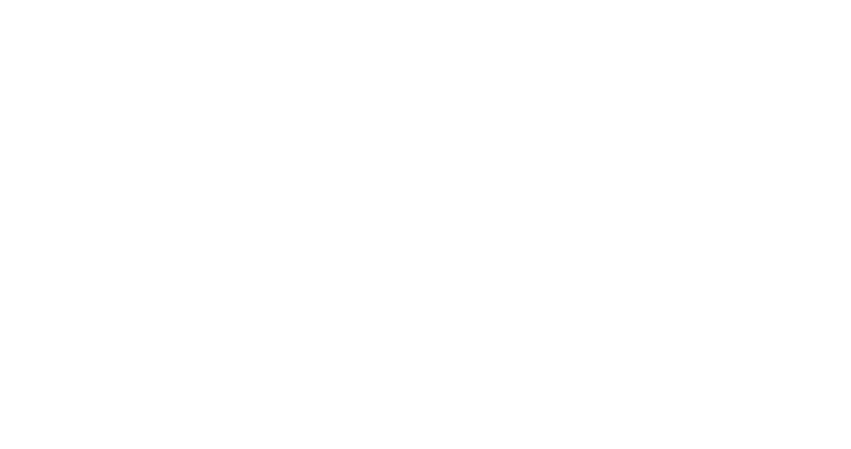

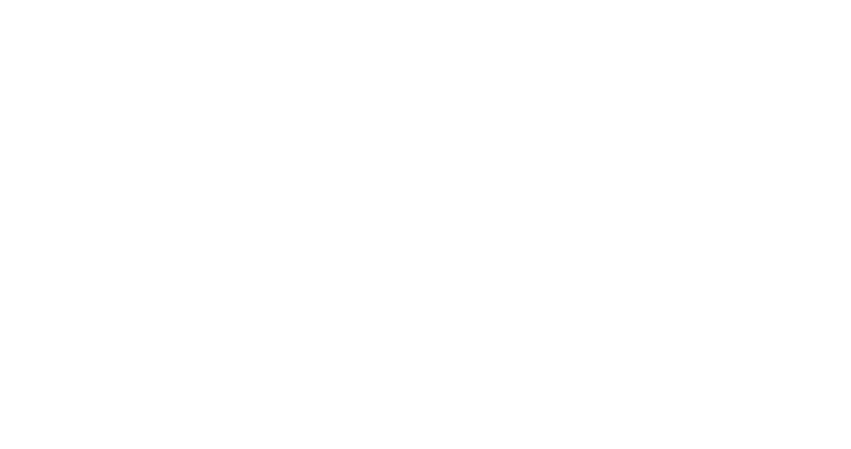

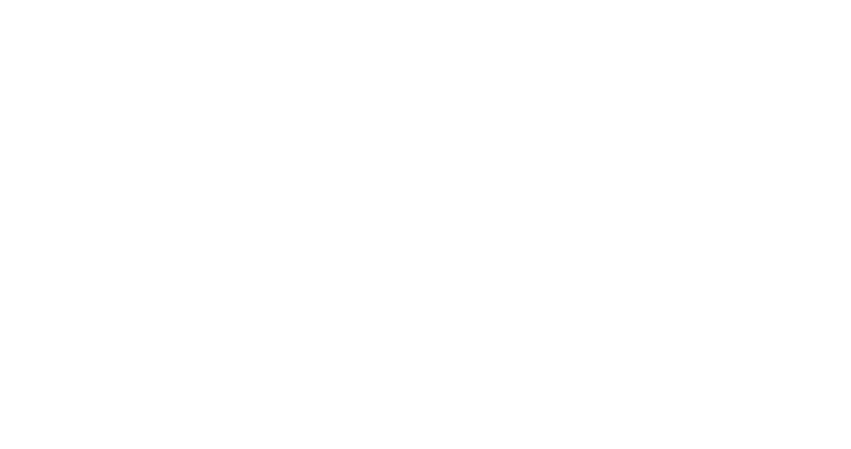

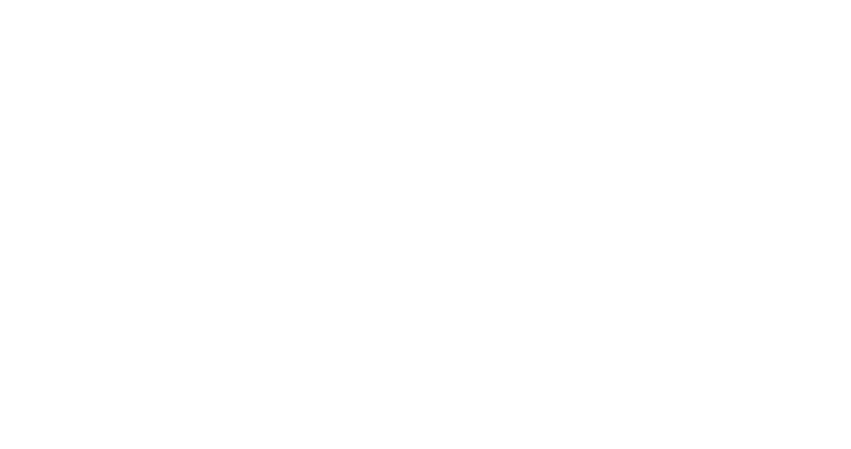

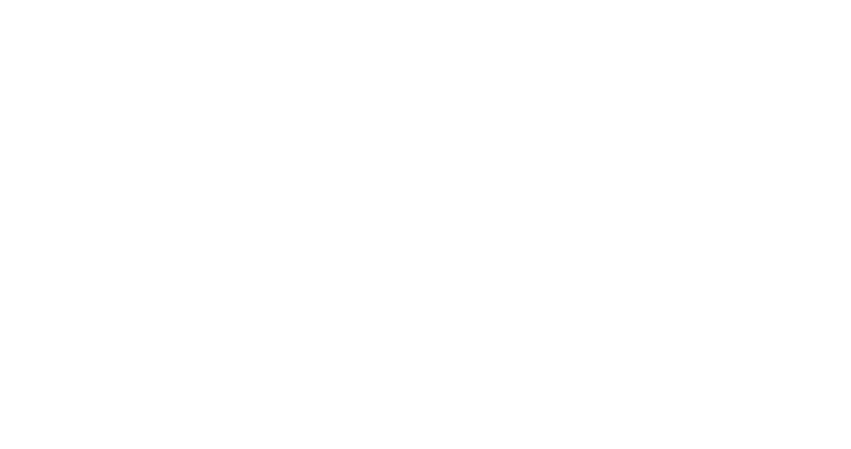

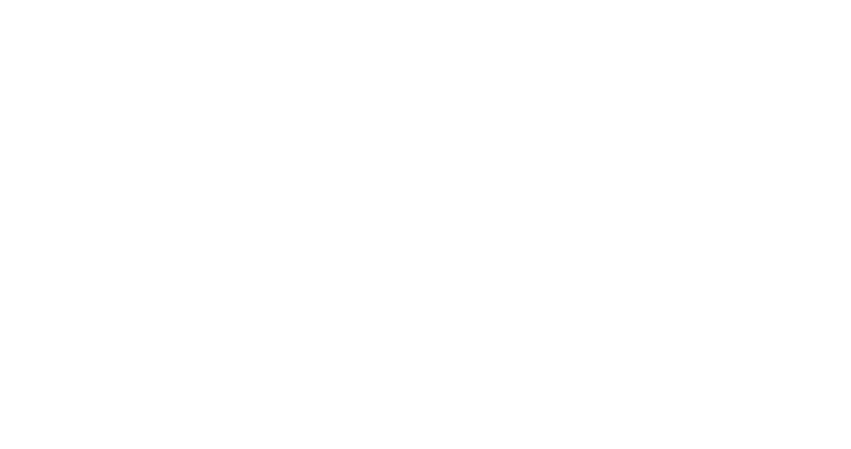

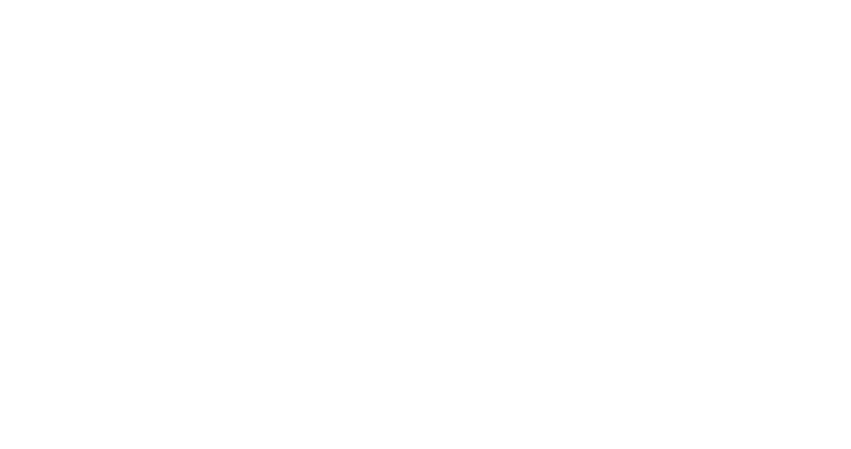

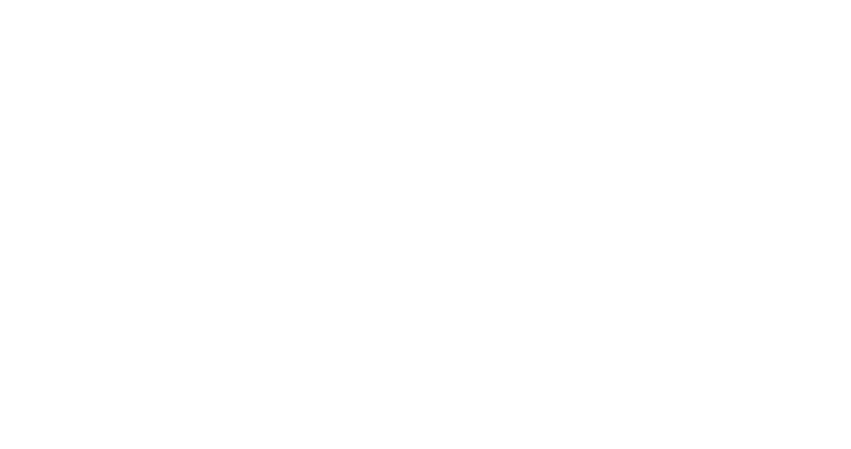

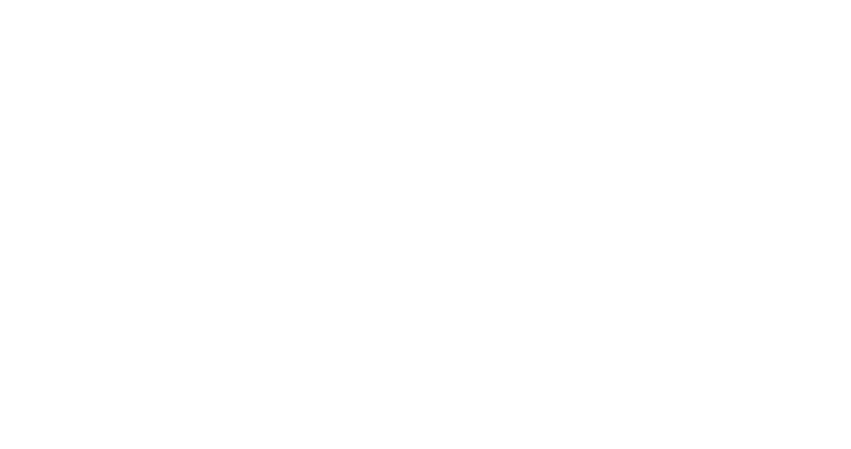

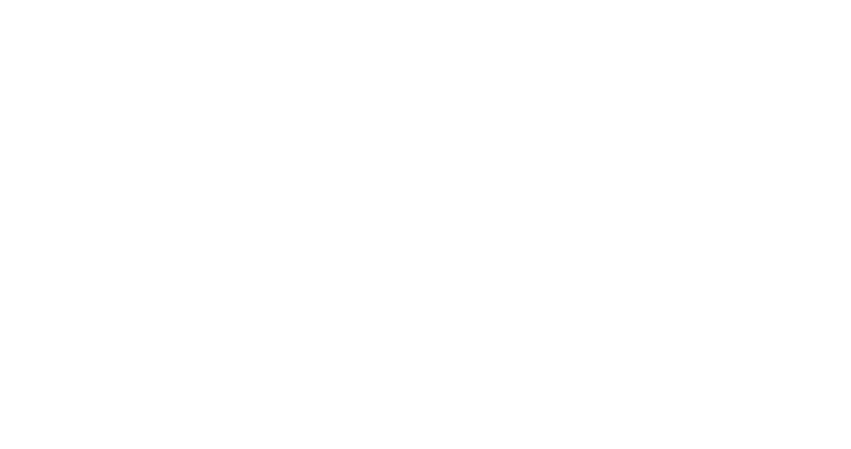

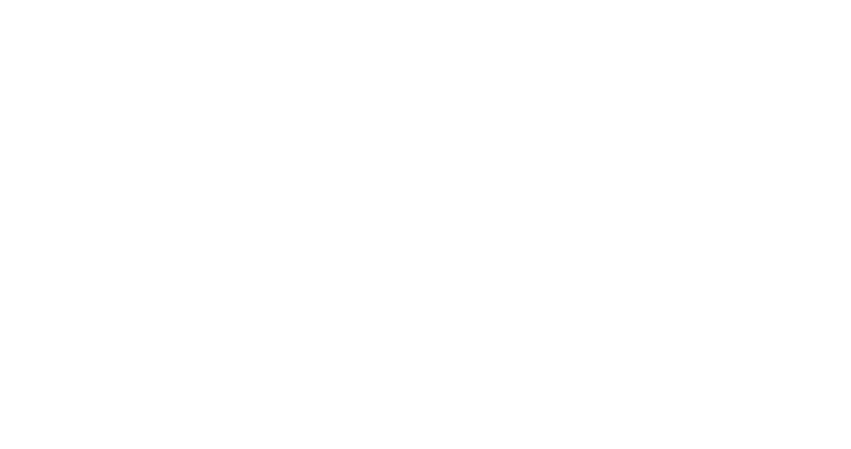

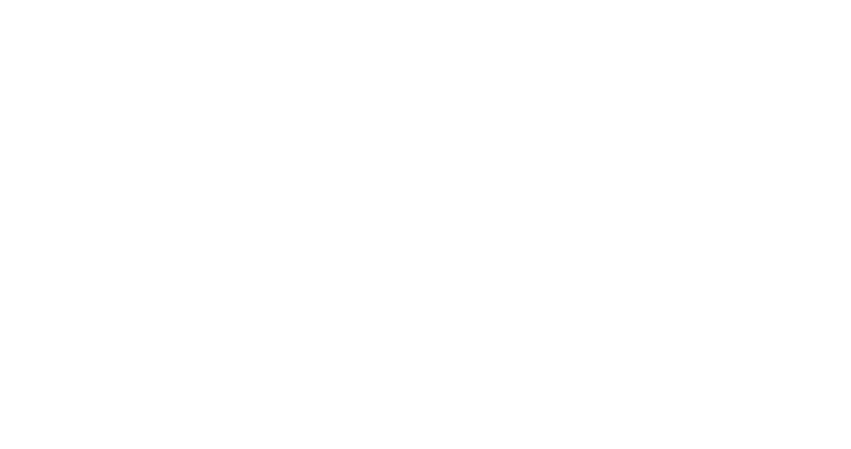

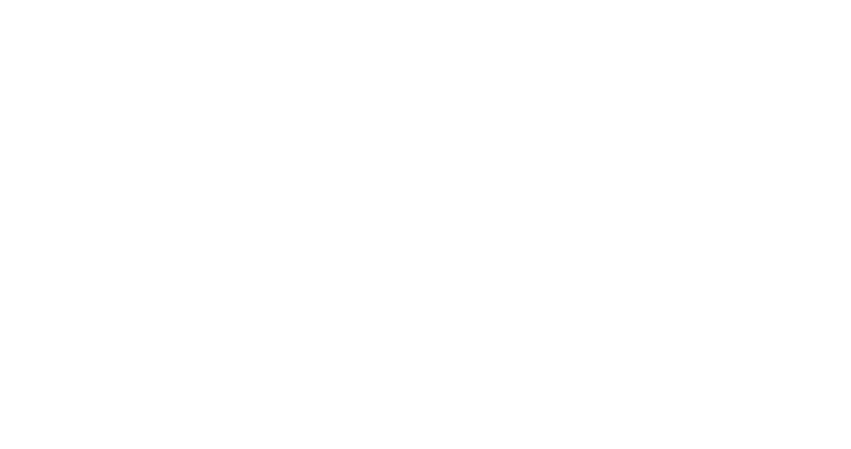

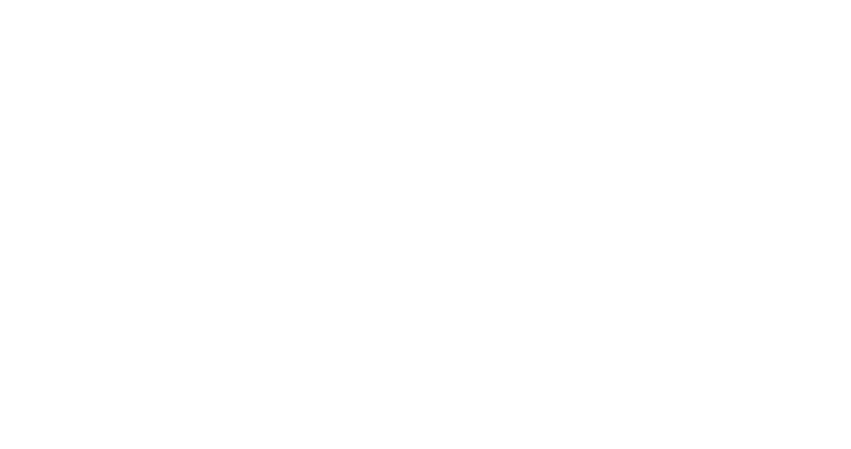

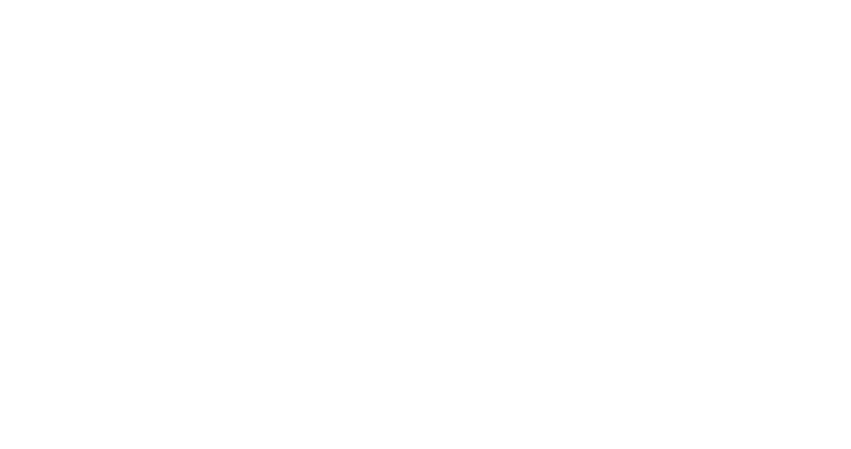

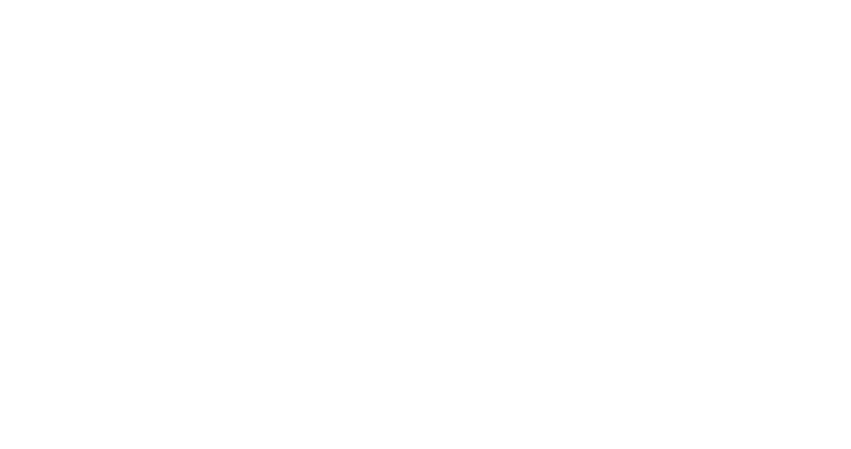

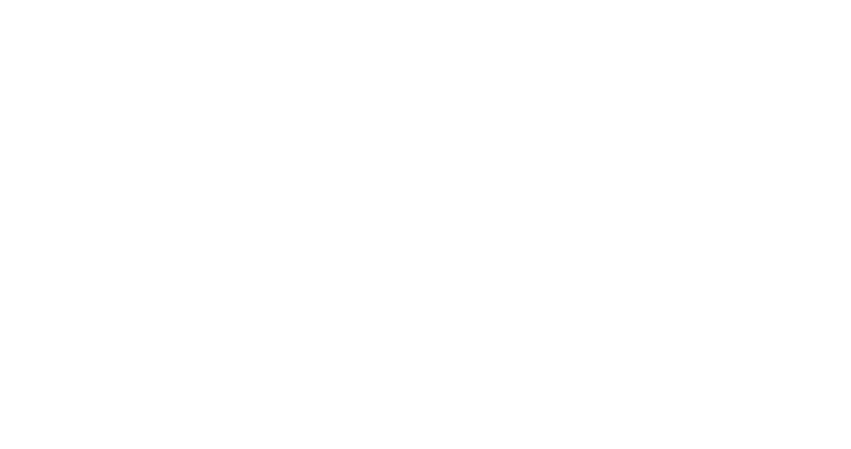

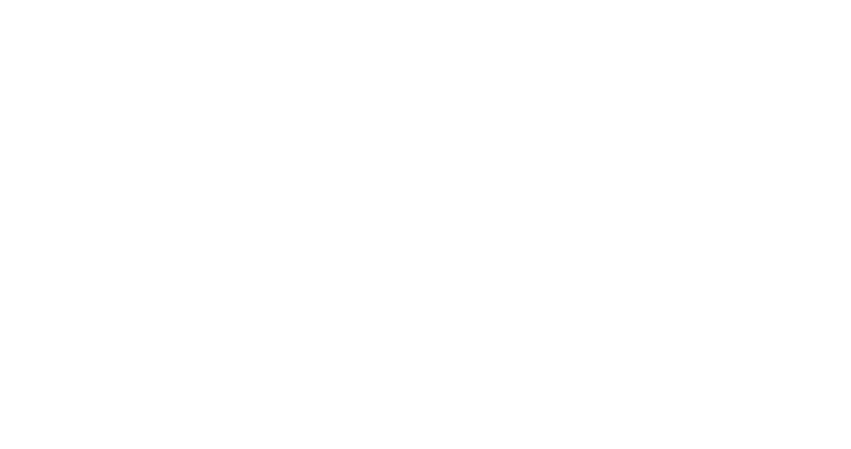

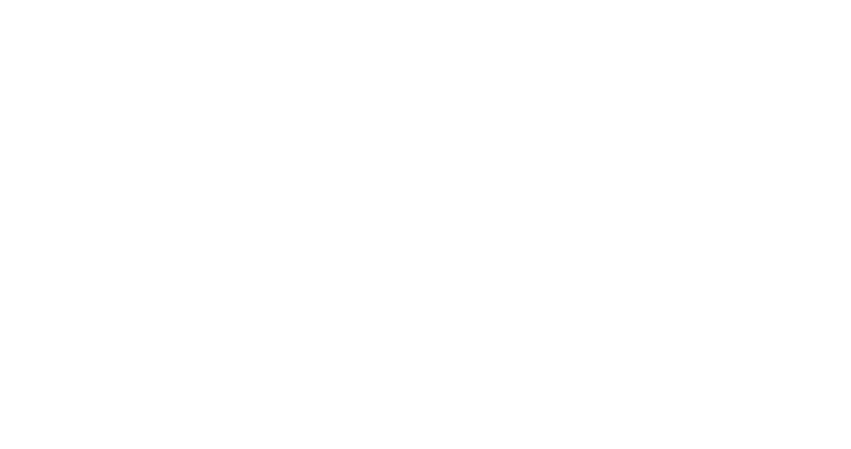

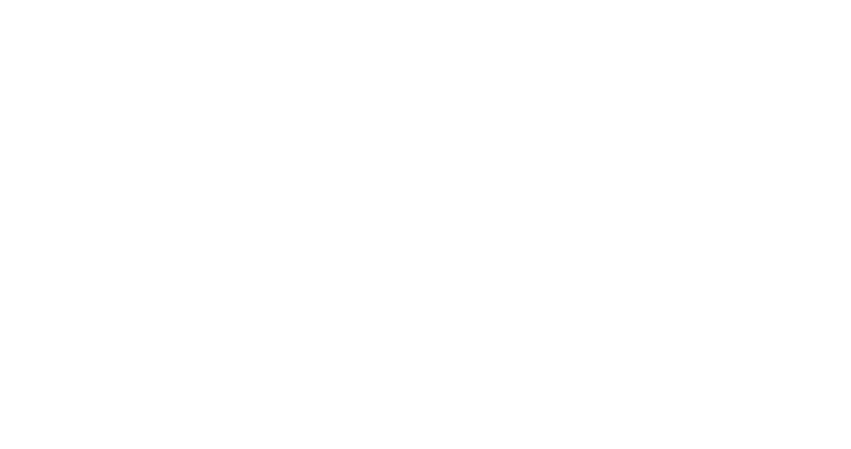

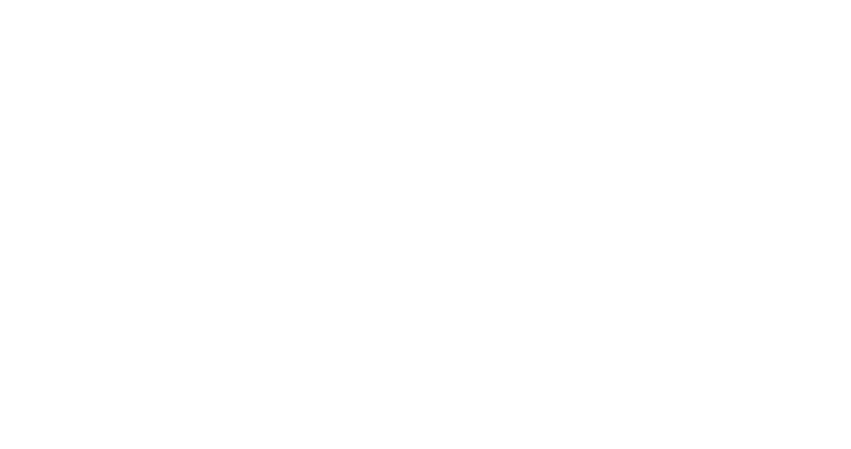

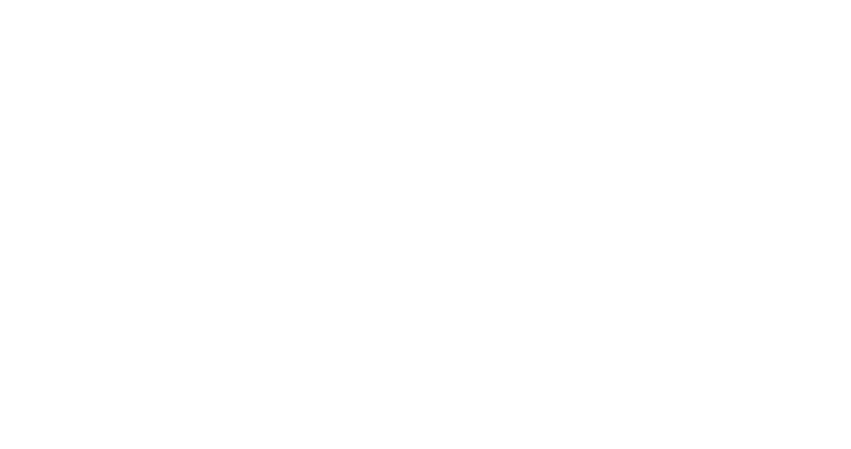

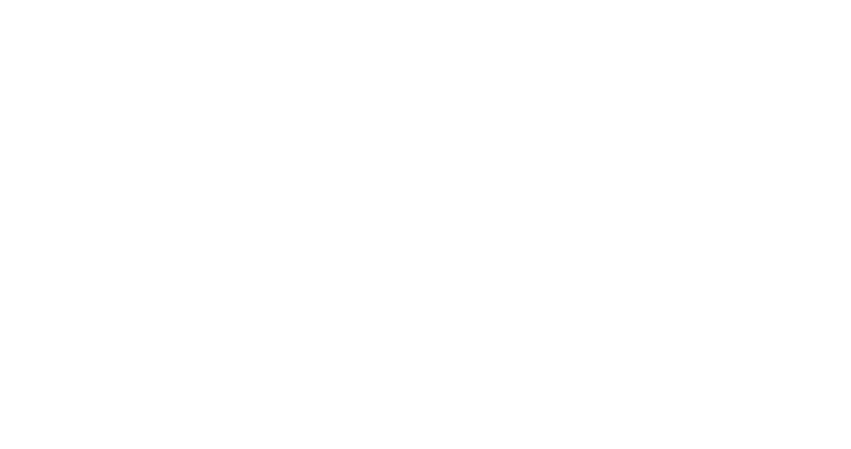

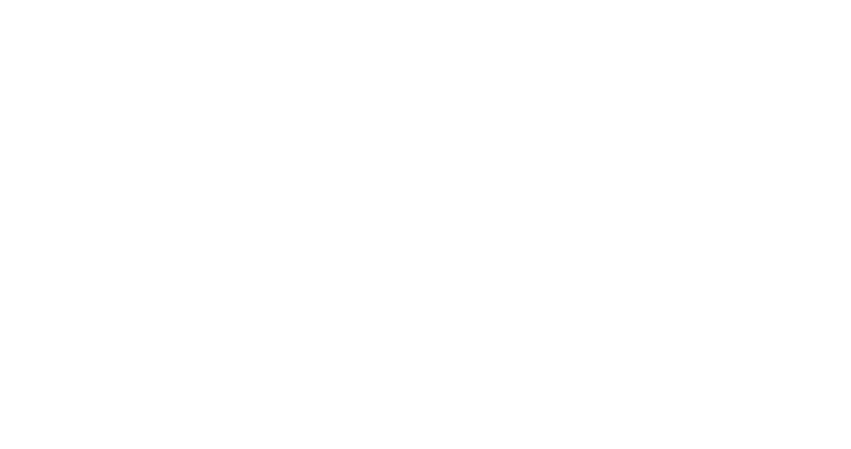

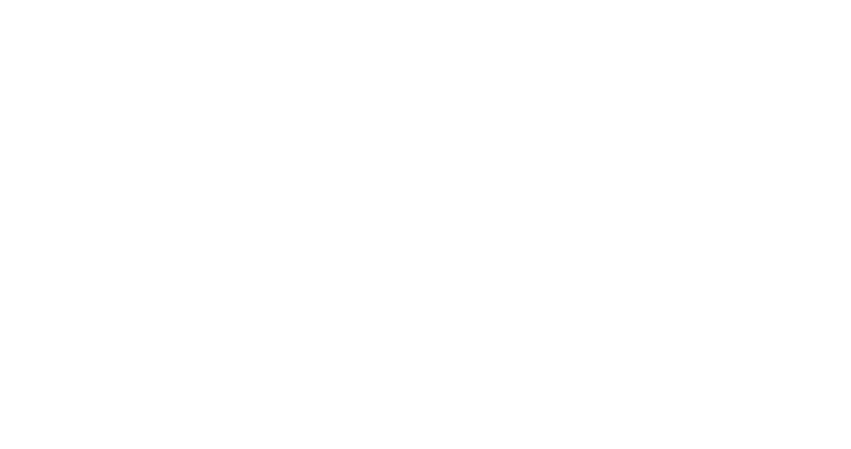

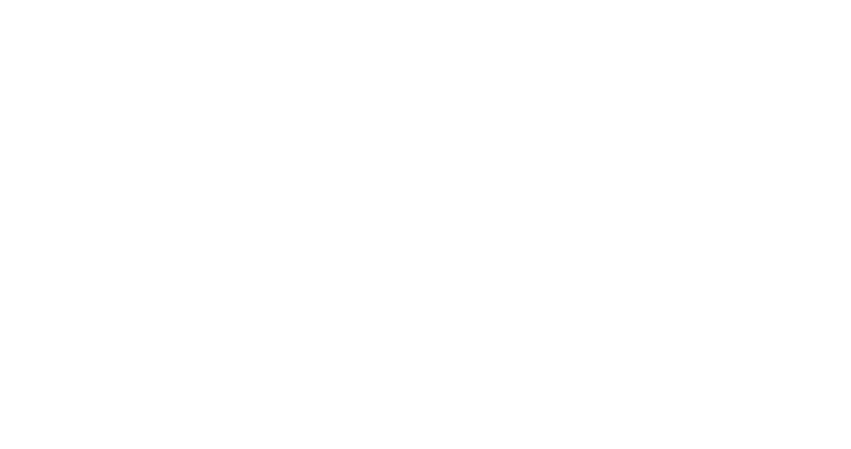

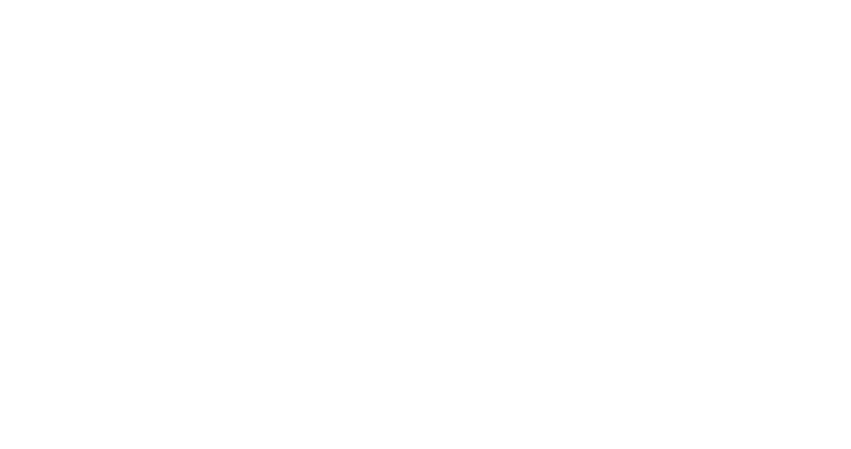

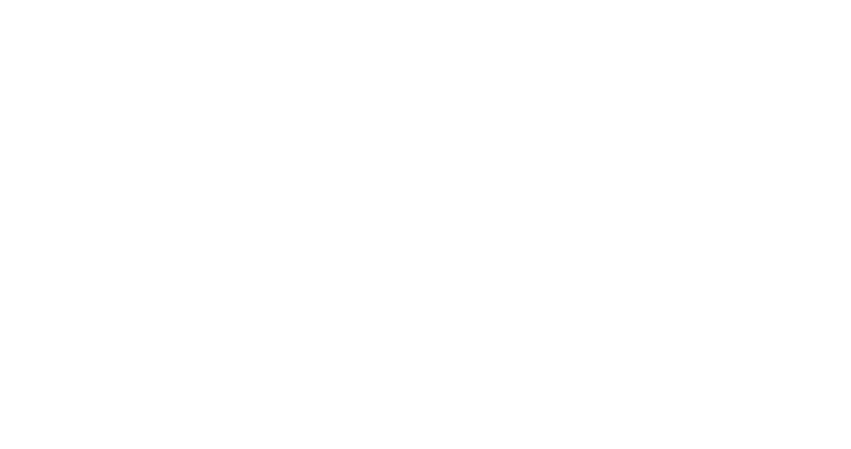

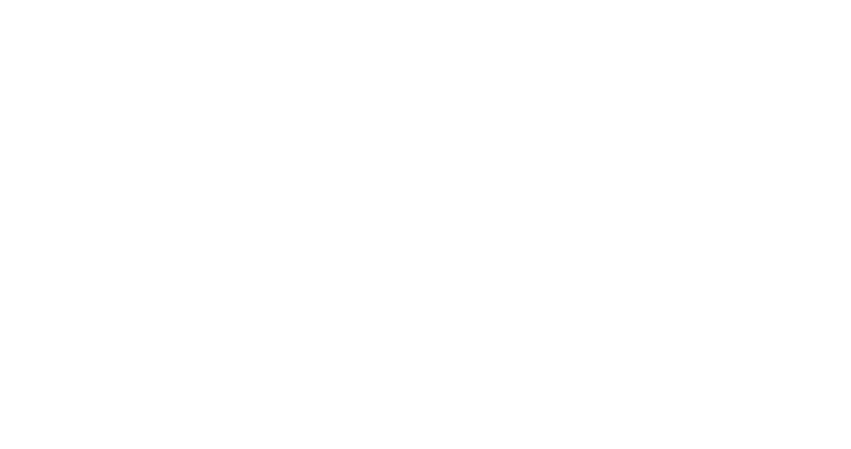

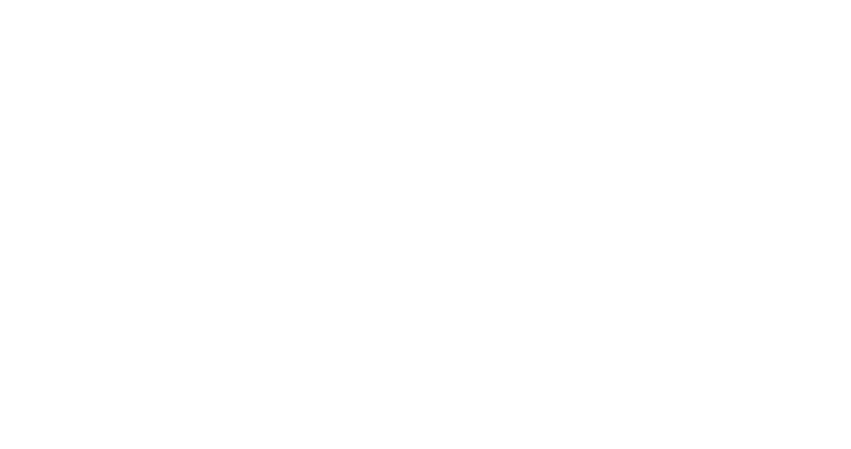

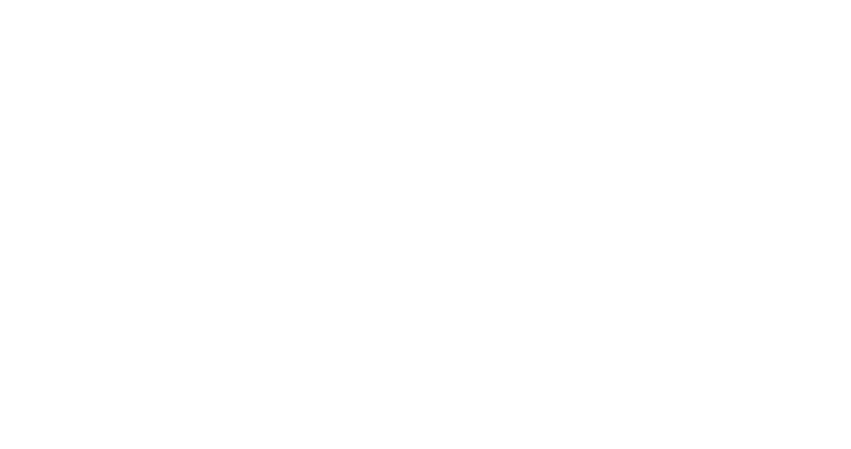

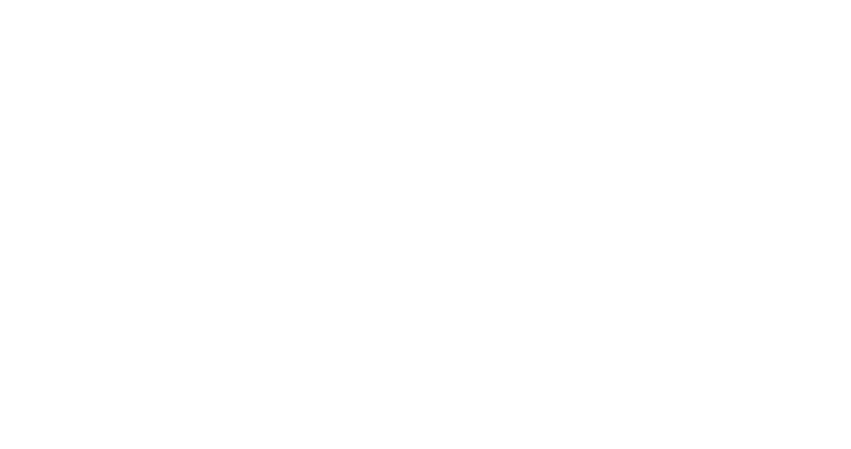

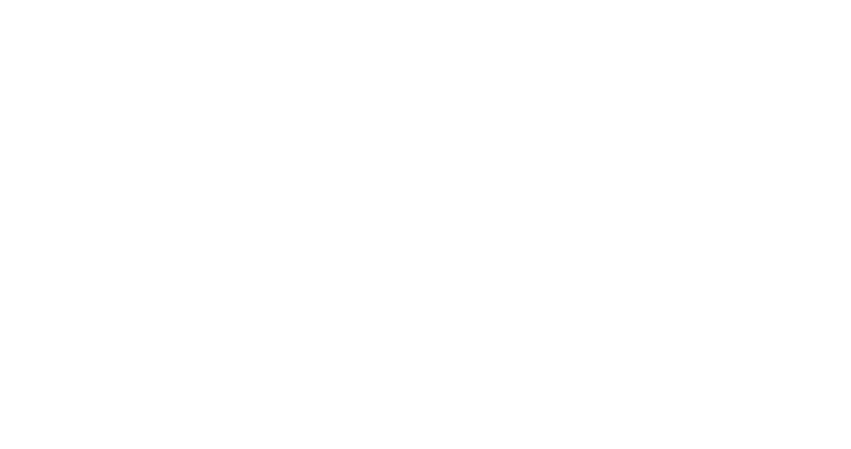

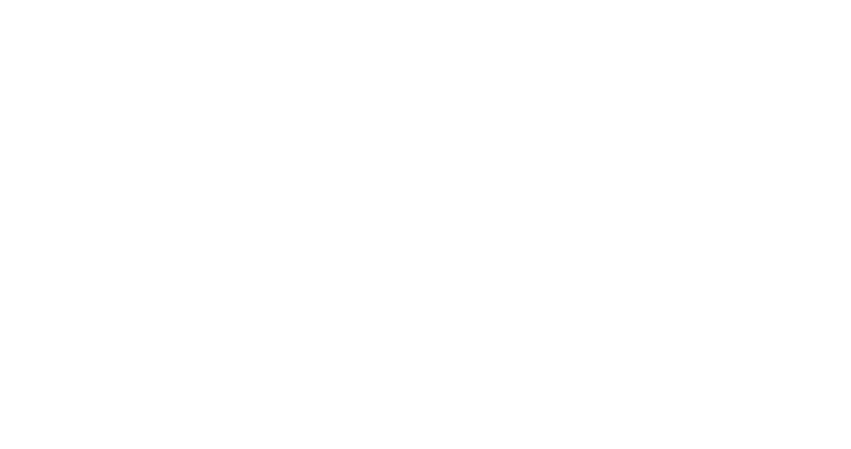

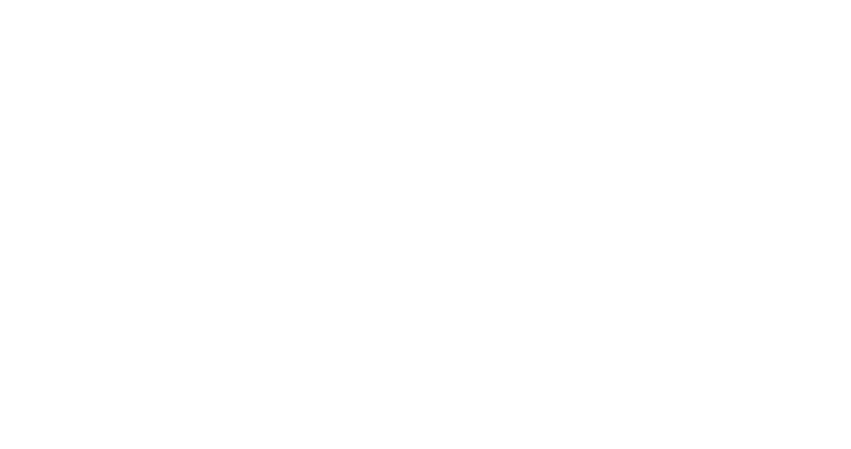

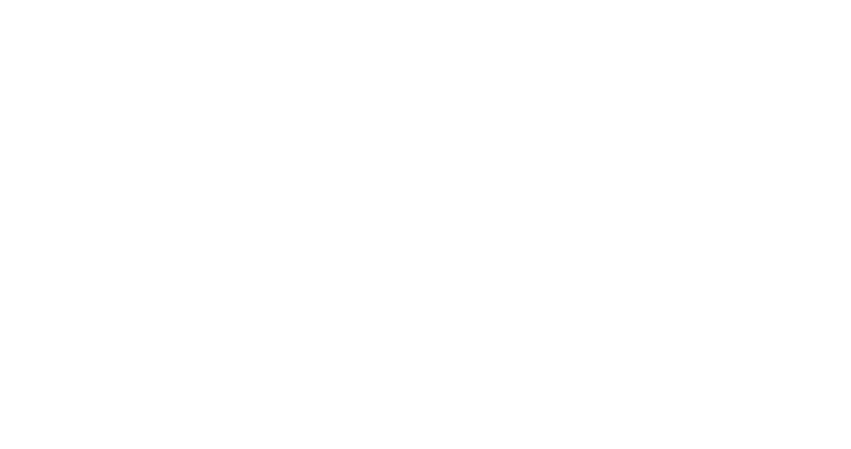

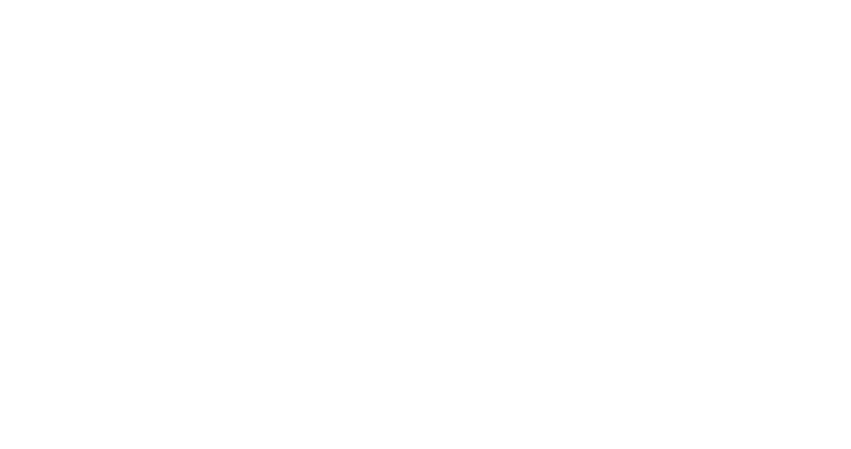

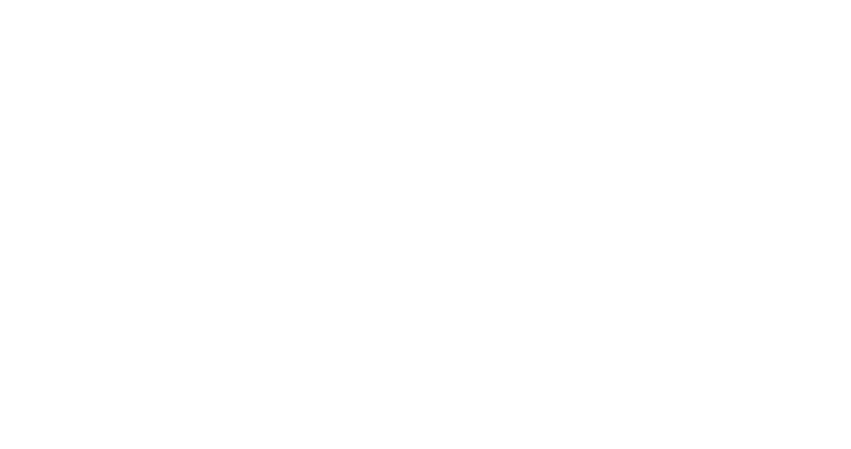

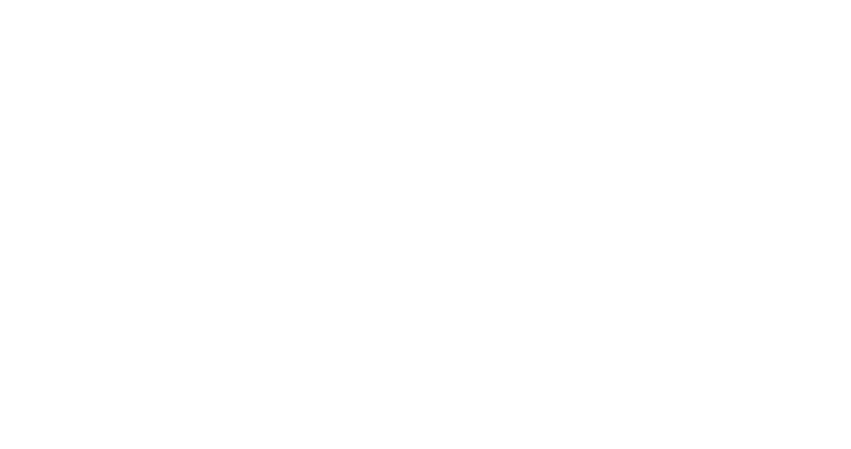

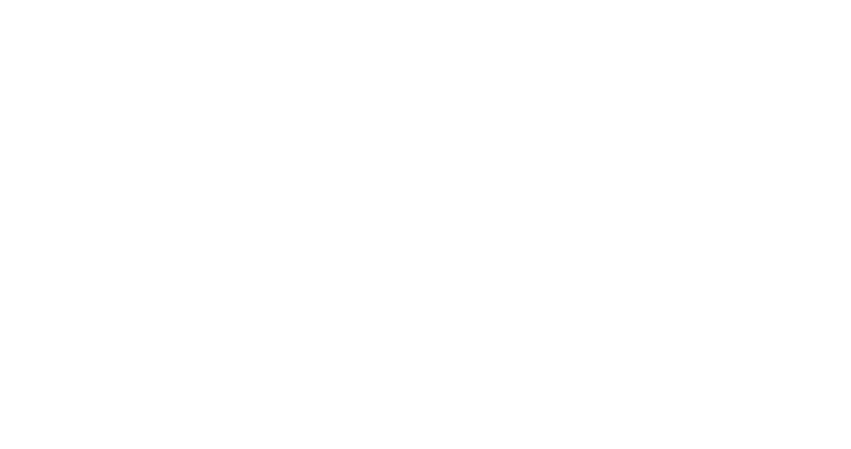

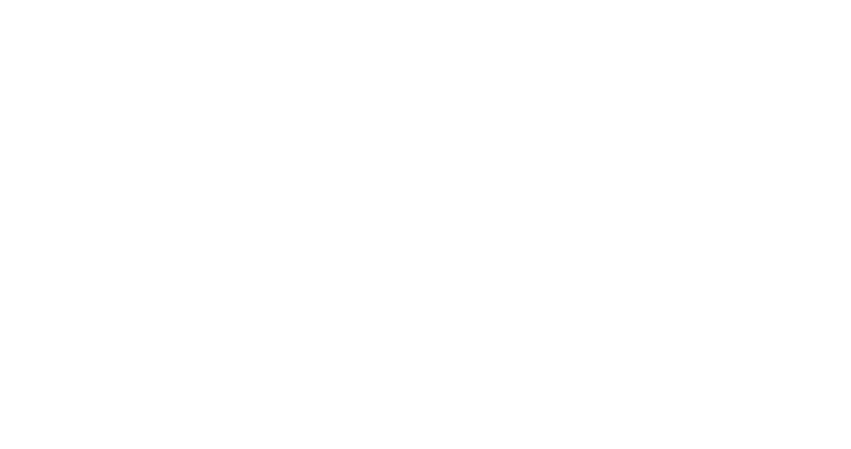

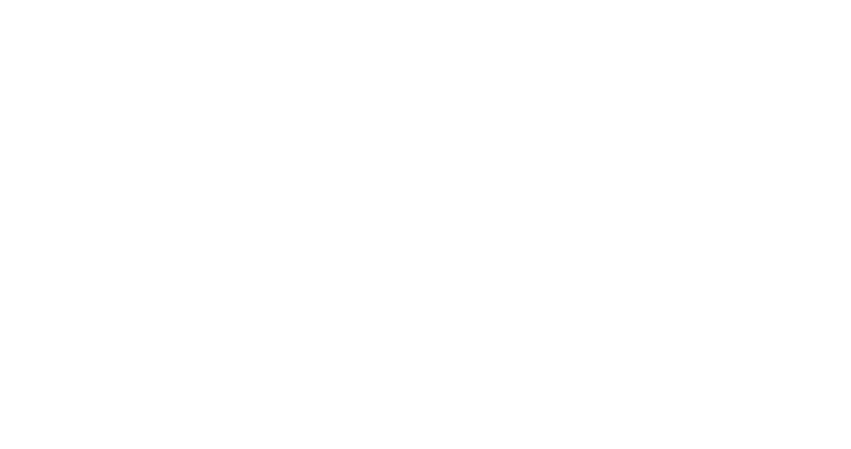

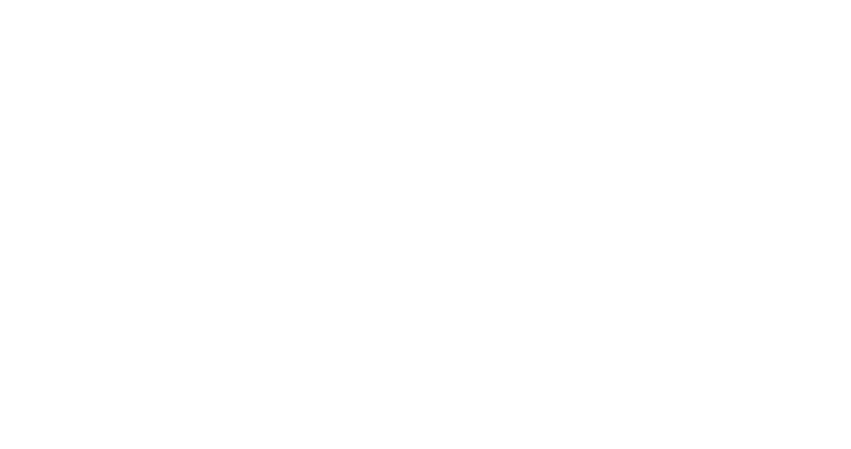

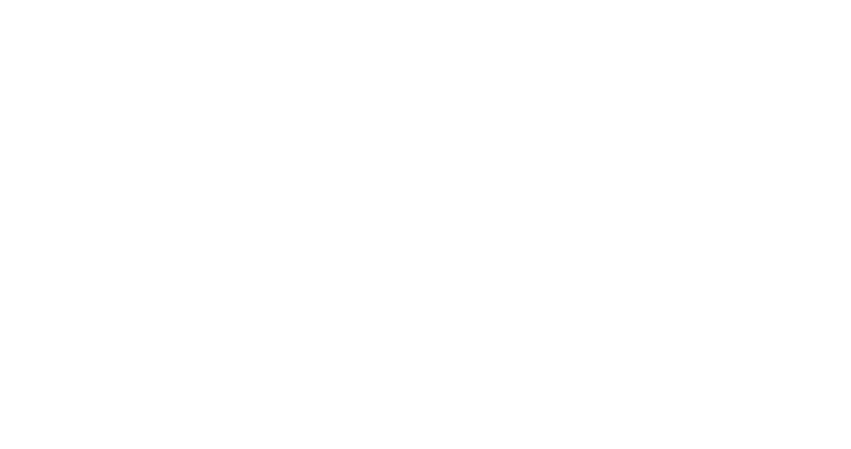

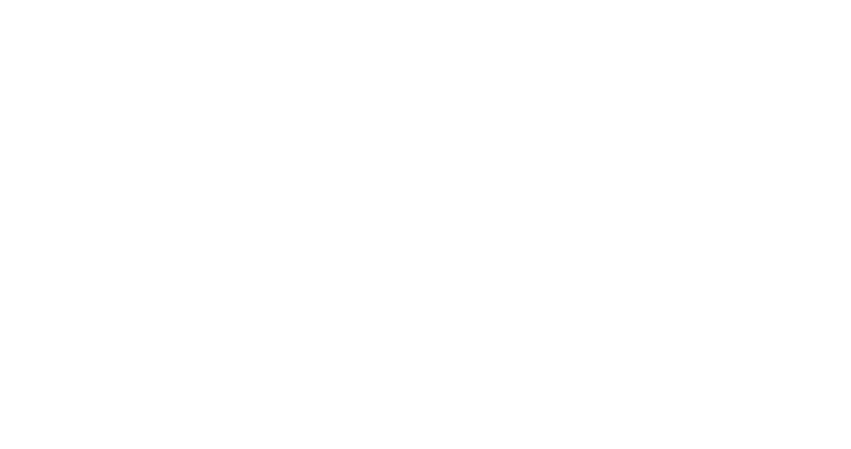

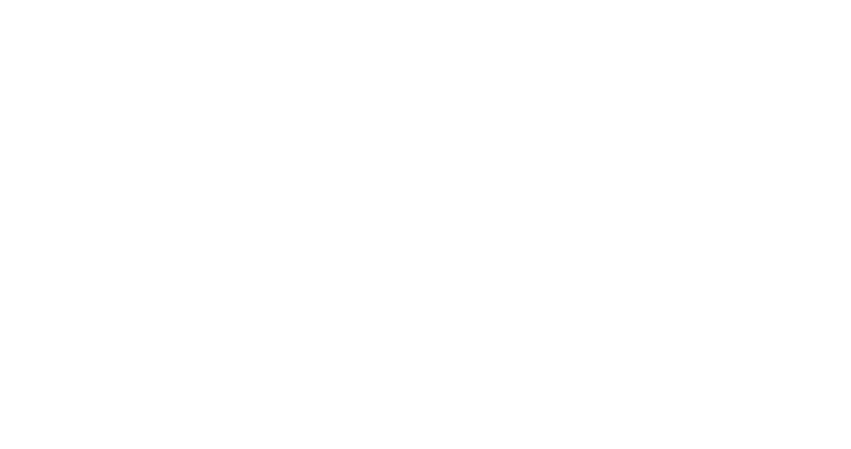

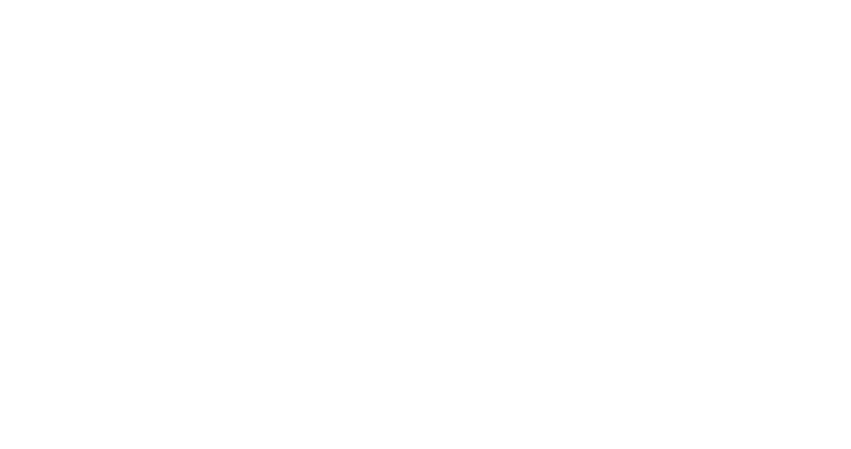

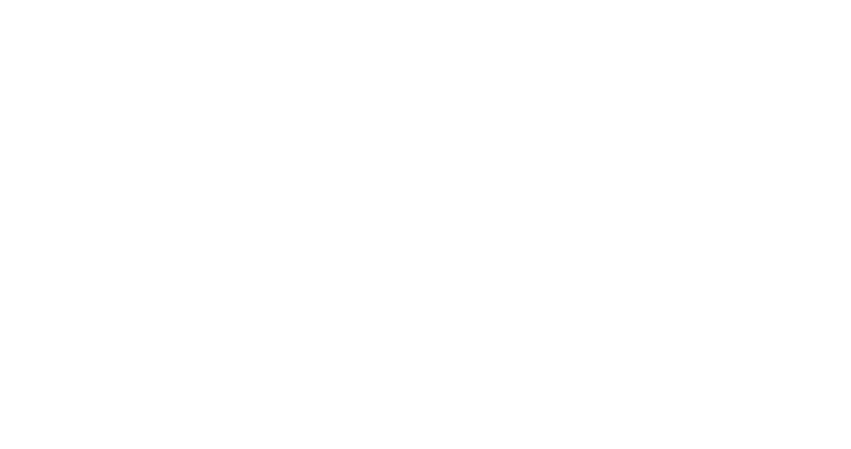

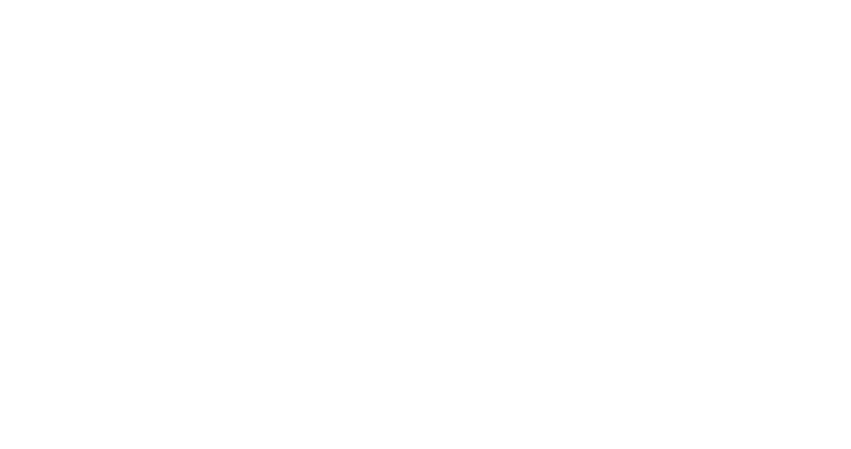

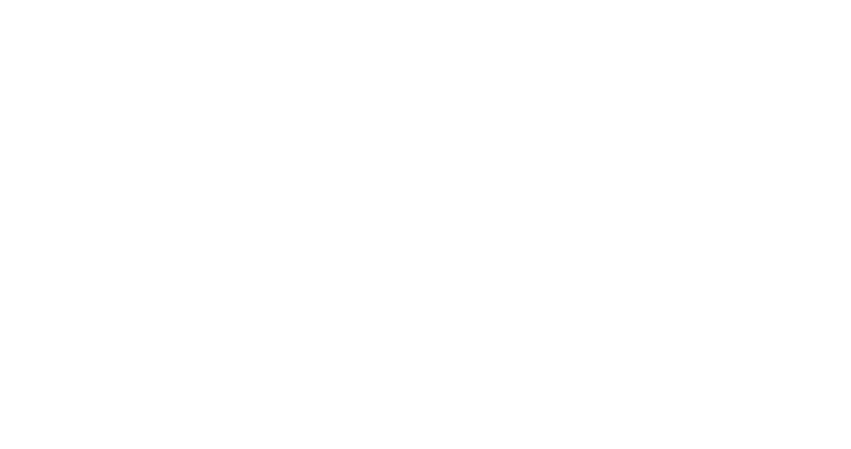

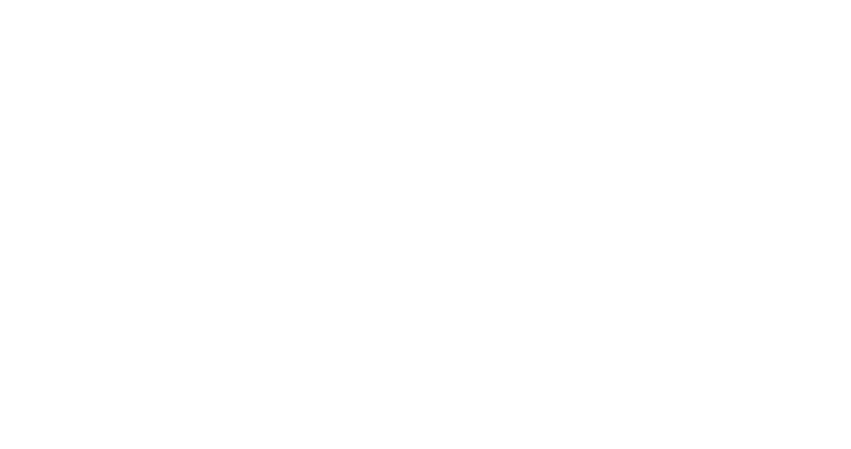

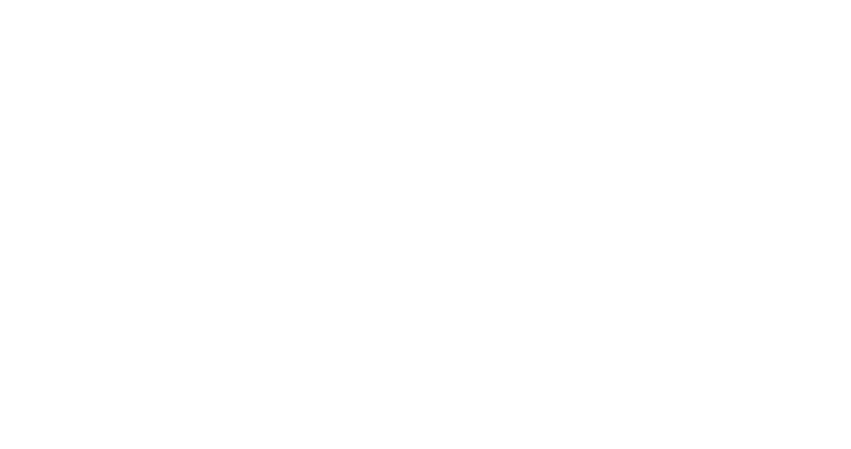

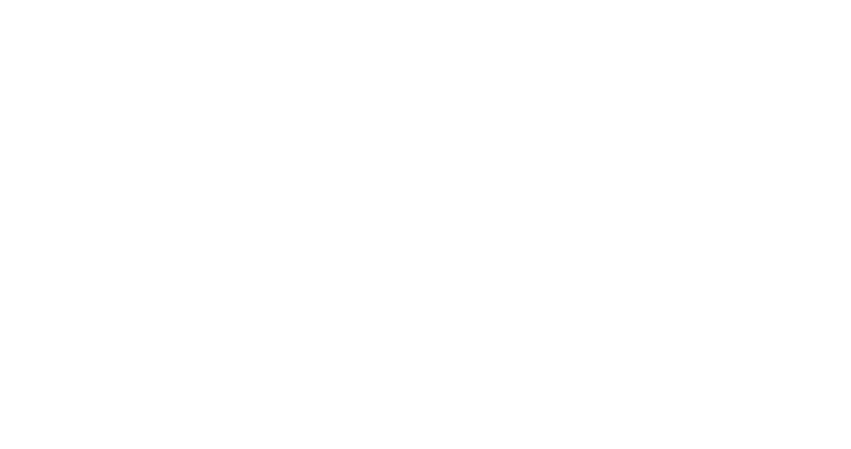

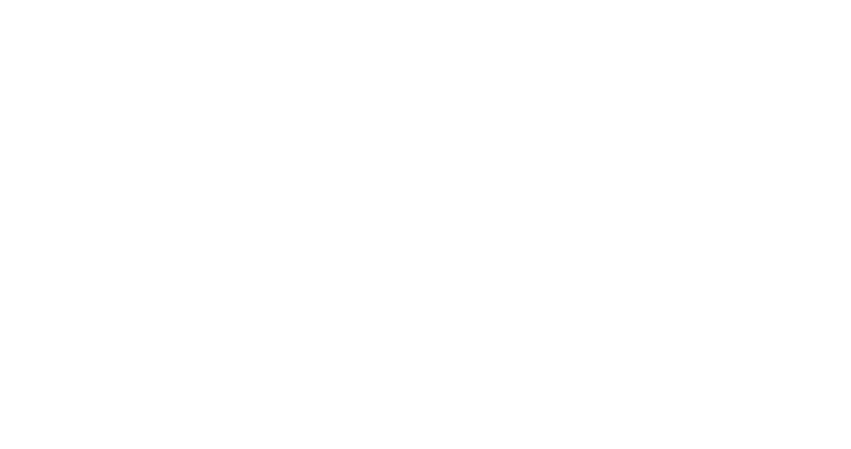

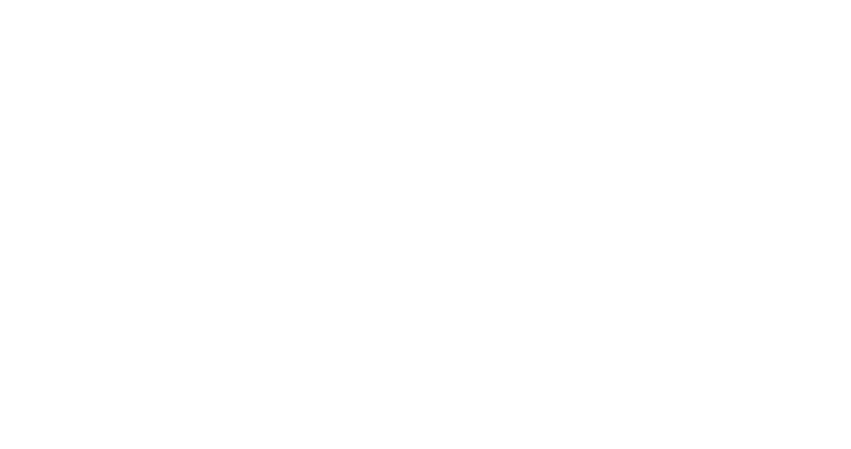

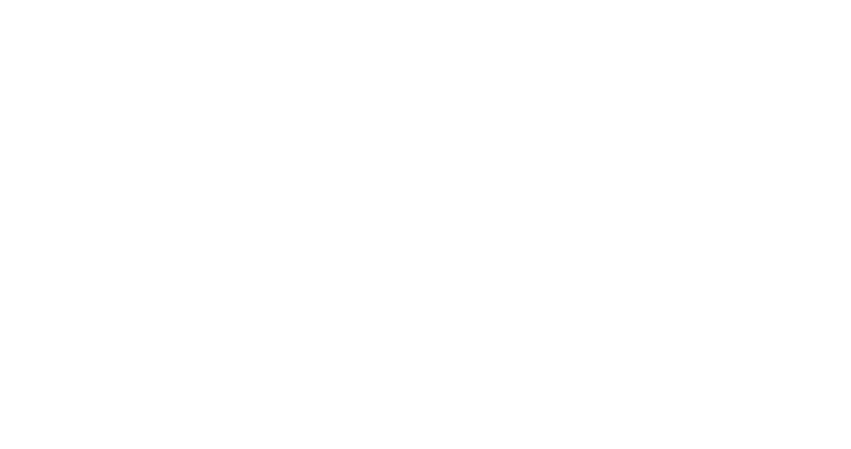

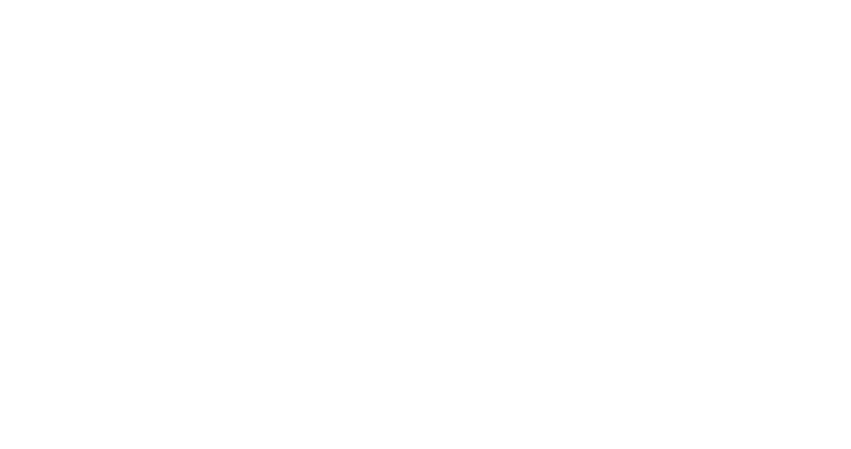

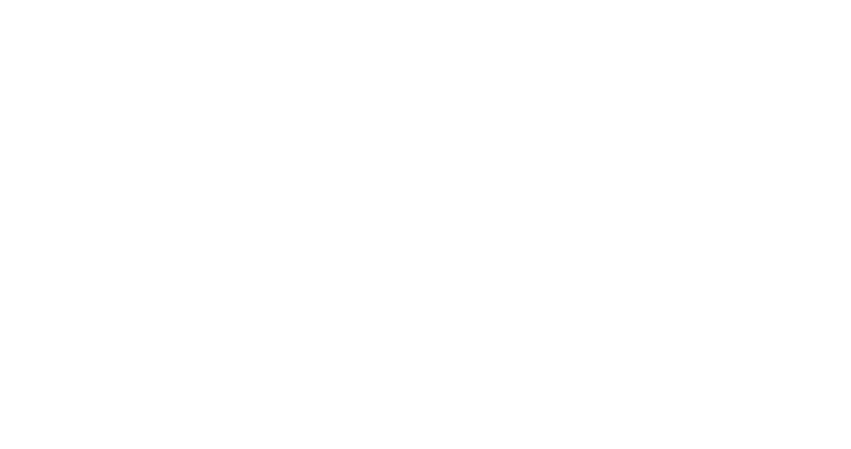

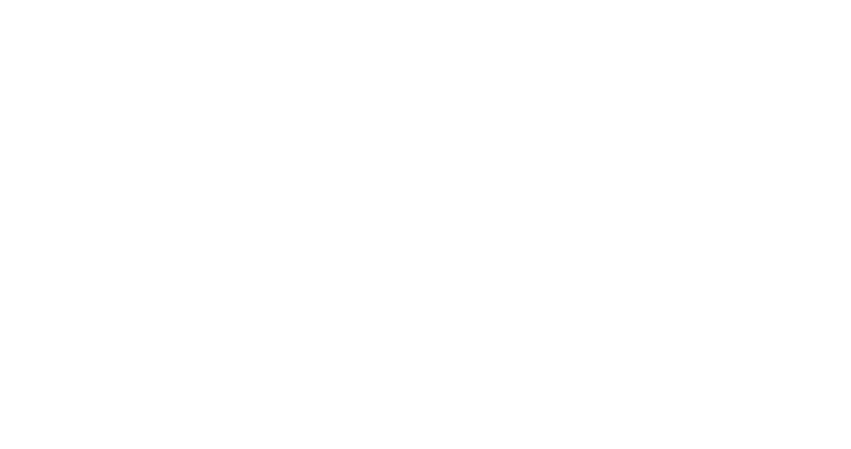

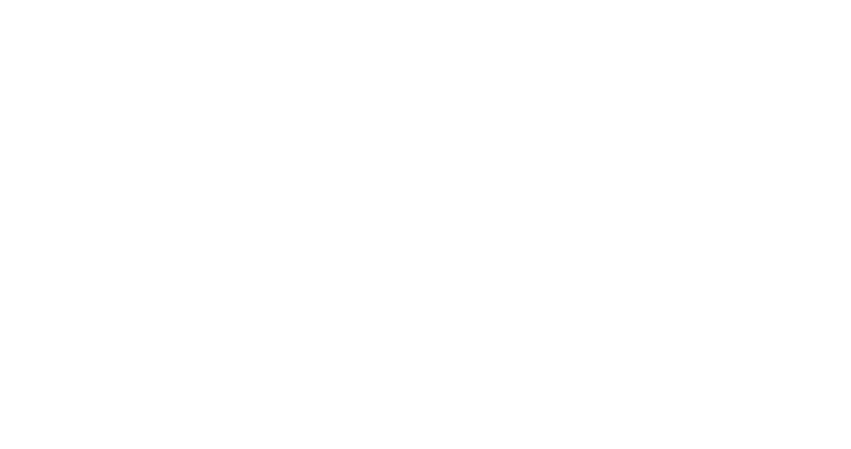

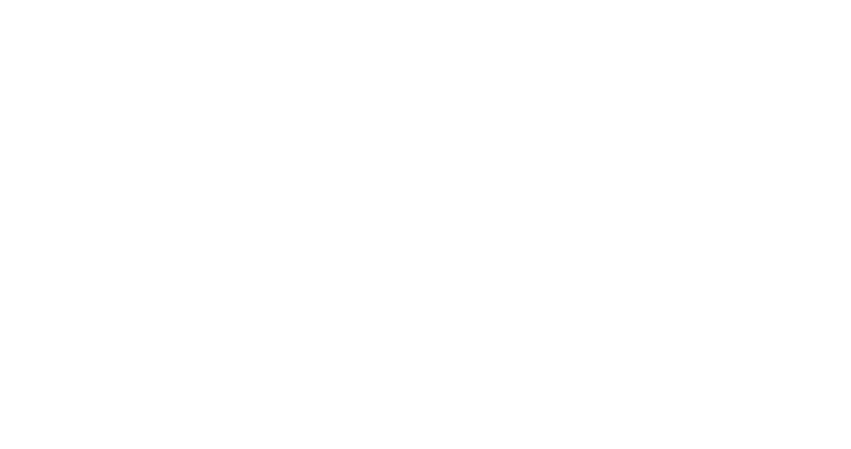

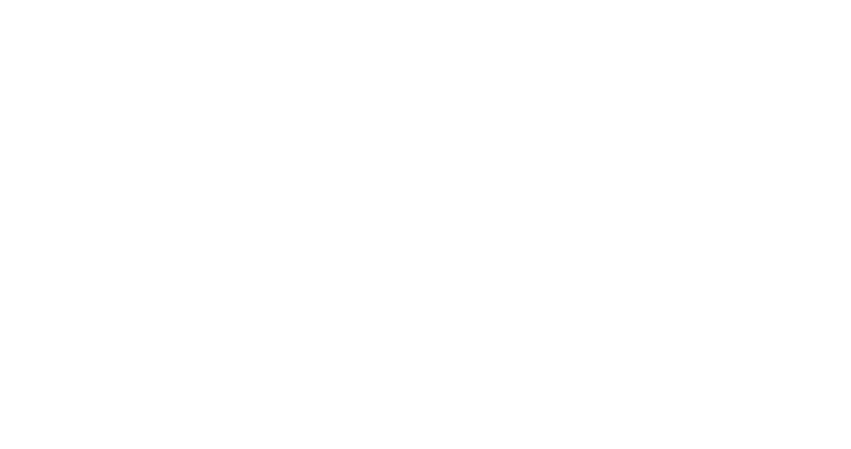

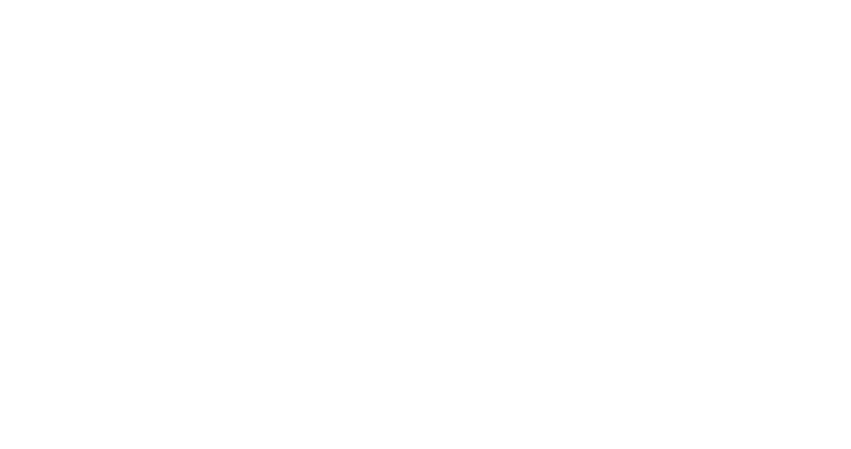

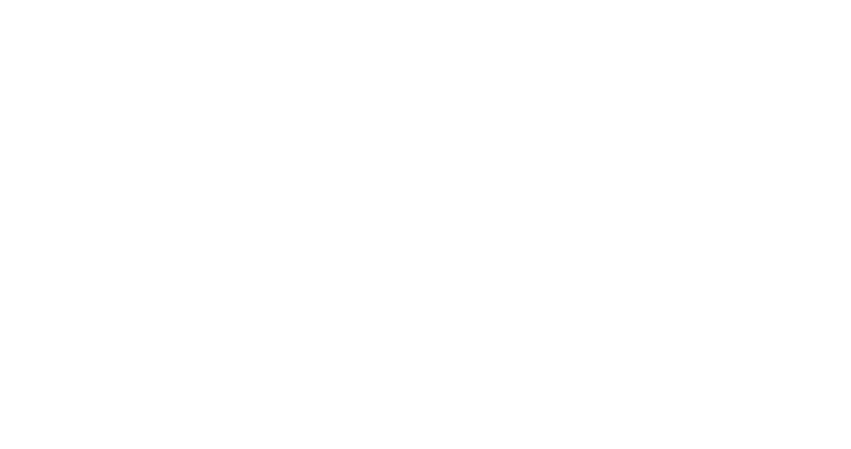

In [49]:
videoinput = cv2.VideoCapture(WEBCAM)

# Init
framenumber = 1
prev_nbpeople = 0
trend = '[Not available]'
color_trend = (255, 0, 0)

# Logging infos into Azure ML experiment
run = experiment.start_logging(snapshot_directory=None)
t1 = datetime.datetime.now() # Current datetime

print('\033[1;31;34mProcessing the video: ', WEBCAM, 'for every', sampling_frames, "frame(s)", '\n')

while(videoinput.isOpened()):
    ret, frame = videoinput.read()
        
    if ret == False:
        break

    if framenumber%sampling_frames == 0: # sampling frames
        
        # Printing informations
        if len(str(framenumber)) == 1:
            framenumberstr = '00000000' + str(framenumber)
        if len(str(framenumber)) == 2:
            framenumberstr = '0000000' + str(framenumber)
        if len(str(framenumber)) == 3:
            framenumberstr = '000000' + str(framenumber)
        if len(str(framenumber)) == 4:
            framenumberstr = '00000' + str(framenumber)
        if len(str(framenumber)) == 5:
            framenumberstr = '0000' + str(framenumber)
        if len(str(framenumber)) == 6:
            framenumberstr = '000' + str(framenumber)
        if len(str(framenumber)) == 7:
            framenumberstr = '00' + str(framenumber)
        if len(str(framenumber)) == 8:
            framenumberstr = '0' + str(framenumber)
        
        print(str(datetime.datetime.now()), "Processing frame =", framenumberstr, '/', nbframes, '\n')
            
        # Saving frame
        cv2.imwrite('results/captures/frame_' + framenumberstr + '.jpg', frame) #Saving frame into image if needed
        
        # Calling the yolo model
        img, preds =  detector.detectCustomObjectsFromImage(input_image = frame, # Calling the obj detection model
                                                      input_type = "array",
                                                      output_type = "array",
                                                      custom_objects = video_object_list, # custom list
                                                      minimum_percentage_probability = minpctprob,
                                                      display_percentage_probability = True,
                                                      display_object_name = True)
        
        # variables init
        nb_people = 0
        print("\033[1;31;34m", "-" * 20, "Detected objects", "-" * 20, "\n")
    
        nb_detectedobjects = 1
        # Parsing predictions
        for key in preds:
            print(str(nb_detectedobjects), '\t', str.upper(key['name']), ' ', round(key['percentage_probability']/100, 5), 
                  ' Bounding Box:', key['box_points'])
            
            if key['name'] == 'person':
                nb_people += 1
                roi = key['box_points']
            
            nb_detectedobjects += 1
        
        new_nbpeople = nb_people

        if prev_nbpeople == 0:
            prev_nbpeople = nb_people

        # Color definitions
        color_lime = (0, 255, 0)
        color_cyan = (255, 255, 0)
        color_red = (0, 0, 255)
        color_blue = (255, 0, 0)
        color_yellow = (0, 255, 255)
        color_orange = (0, 127, 255)
        color_purple = (211, 0, 148)
        color_pink = (121, 28, 227)
        
        delaydisplaymsg = sampling_frames * 60
        
        if framenumber%delaydisplaymsg == 0:
            if new_nbpeople > prev_nbpeople:
                trend = "[Increasing]"
                color_trend = color_red
            if new_nbpeople < prev_nbpeople:
                trend = "[Decreasing]"
                color_trend = color_lime
            if new_nbpeople == prev_nbpeople:
                trend = "[No Change]"
                color_trend = color_blue
            
        prev_nbpeople = nb_people
        
        # people density class
        if nb_people == 0:
            density = "No people detected"
            colorfont_density = color_blue
        
        if nb_people < low_limit:
            density = "Low density of people"
            colorfont_density = color_cyan
        
        if nb_people >= low_limit and nb_people < high_limit:
            density = "Moderate density of people "
            colorfont_density = color_orange
        
        if nb_people >= high_limit:
            density = "High density of people "
            colorfont_density = color_red
        
        # Logging to Azure ML experiments
        now = datetime.datetime.now().replace(microsecond=0)
        run.log("date", str(now))
        run.log("frame", framenumberstr)
        run.log("number_people", nb_people)
        run.log("density", density)

        plt.figure(figsize=(15, 8)) 
        plt.axis('off')
               
        # Plots informations
        thickness1 = 1
        thickness2 = 2
        thickness3 = 3
        fontsize1 = 1.5
        fontsize2 = 2
        fontsize3 = 2.5
        fontsize4 = 3
        
        # Creation of text informations
        msgdate = str(datetime.datetime.now().replace(microsecond=0))
        msgframe = "Frame: " + str(framenumberstr)
        msgcamera = "CCTV 1 - Counting People App"
        msgdensity = str(density)
        msgpeople = "Number of people = " + str(nb_people)

        # Printing results informations
        print()
        print("\033[1;31;91m", "-" * 20, "Results", "-" * 20)
        print("\nNumber of detected objects =", nb_detectedobjects - 1)
        print("\nNumber of people =", nb_people)
        print(density)
        print("People count trend =", trend)

        # OpenCV text displays
        cv2.putText(img, msgdate, (30, 50), cv2.FONT_HERSHEY_SIMPLEX, fontsize2, color_lime, thickness3)
        cv2.putText(img, msgcamera, (30, 120), cv2.FONT_HERSHEY_SIMPLEX, fontsize2, color_lime, thickness3)
        cv2.putText(img, msgframe, (30, 190), cv2.FONT_HERSHEY_SIMPLEX, fontsize2, color_lime, thickness3)
        cv2.putText(img, msgpeople, (30, 350), cv2.FONT_HERSHEY_SIMPLEX, fontsize2, color_red, thickness3)
        cv2.putText(img, trend, (30, 420), cv2.FONT_HERSHEY_SIMPLEX, fontsize2, color_trend, thickness3)
        cv2.putText(img, msgdensity, (30, 490), cv2.FONT_HERSHEY_SIMPLEX, fontsize2, colorfont_density, thickness3)

        # Saving processed frame to a jpg file format
        jpgimagefile = 'results/processed_frame_' + str(framenumberstr) + '.jpg'
        cv2.imwrite(jpgimagefile, img)
        
        #run.log_image(name = 'processedimage', path = jpgimagefile)    
        print('\n\033[1;31;34mProcessing next frame...')
    
    framenumber += 1

print("-" * 20, "End of job", "-" * 20)
print(datetime.datetime.now(), 'Done in', datetime.datetime.now() - t1)

videoinput.release()

## 6. Reports
Captured images are saved into a dedicated directory (optional).<br>
Processed images with results are saved into an another dedicated directory and into the Azure ML experiment (optional)
We can dowload the logged metrics from the Azure ML experiment.

In [50]:
nbfiles = sum(len(files) for _, _, files in os.walk(DIR2)) # dir where the raw captured frames are
print("Number of captured frames =", nbfiles)

Number of captured frames = 275


### Azure ML experiment

In [51]:
experiment

Name,Workspace,Report Page,Docs Page
PeopleCounting,AMLworkshop,Link to Azure Machine Learning studio,Link to Documentation


### Retrieving logged metrics

In [52]:
videoresults = run.get_metrics() # Get Metrics from the Azure ML experiment
videoresults_df = pd.DataFrame(videoresults) # Convert to a pandas df

In [53]:
videoresults_df.shape

(275, 4)

In [54]:
videoresults_df.dtypes

date             object
frame            object
number_people     int64
density          object
dtype: object

In [55]:
videoresults_df.head(5)

,date,frame,number_people,density
0,2022-01-25 12:20:29,000000001,37,Moderate density of people
1,2022-01-25 12:20:30,000000002,37,Moderate density of people
2,2022-01-25 12:20:31,000000003,38,Moderate density of people
3,2022-01-25 12:20:32,000000004,37,Moderate density of people
4,2022-01-25 12:20:34,000000005,38,Moderate density of people


In [56]:
videoresults_df.tail(5)

,date,frame,number_people,density
270,2022-01-25 12:24:48,000000271,31,Low density of people
271,2022-01-25 12:24:49,000000272,31,Low density of people
272,2022-01-25 12:24:50,000000273,33,Moderate density of people
273,2022-01-25 12:24:51,000000274,33,Moderate density of people
274,2022-01-25 12:24:52,000000275,32,Moderate density of people


In [57]:
videoresults_df.describe()

,number_people
count,275.000000
mean,35.010909
std,4.200698
min,28.000000
25%,32.000000
50%,34.000000
75%,38.000000
max,44.000000


### Statistics

In [58]:
createdir('reports') # Directory to save the graphs

Creating directory: reports
Done!


In [59]:
print("\033[1;31;34mDistribution")
print(videoresults_df['density'].value_counts())

Distribution
Moderate density of people     160
Low density of people           64
High density of people          51
Name: density, dtype: int64


In [60]:
print("\033[1;31;34mDistribution in %")
print(videoresults_df['density'].value_counts(normalize=True))

Distribution in %
Moderate density of people     0.581818
Low density of people          0.232727
High density of people         0.185455
Name: density, dtype: float64


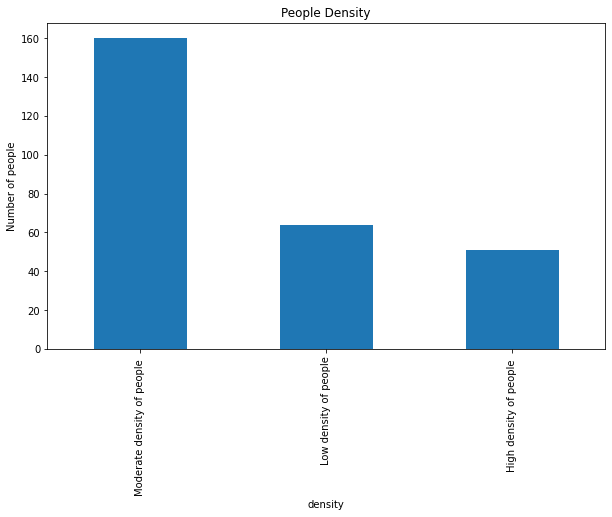

In [61]:
%matplotlib inline
import matplotlib.pyplot as plt

ax = videoresults_df['density'].value_counts().plot(kind='bar',
                                    figsize=(10,6),
                                    title="People Density")
ax.set_xlabel("density")
ax.set_ylabel("Number of people")
plt.savefig("reports/density.png", dpi=300)

### People

In [62]:
print("\033[1;31;34mStatistics about Persons:\n")
print("Minimum")
print(videoresults_df[['number_people']].min())
print("\nMaximum")
print(videoresults_df[['number_people']].max())
print("\nMean")
print(round(videoresults_df[['number_people']].mean()))

Statistics about Persons:

Minimum
number_people    28
dtype: int64

Maximum
number_people    44
dtype: int64

Mean
number_people    35.0
dtype: float64


<AxesSubplot:xlabel='number_people', ylabel='Count'>

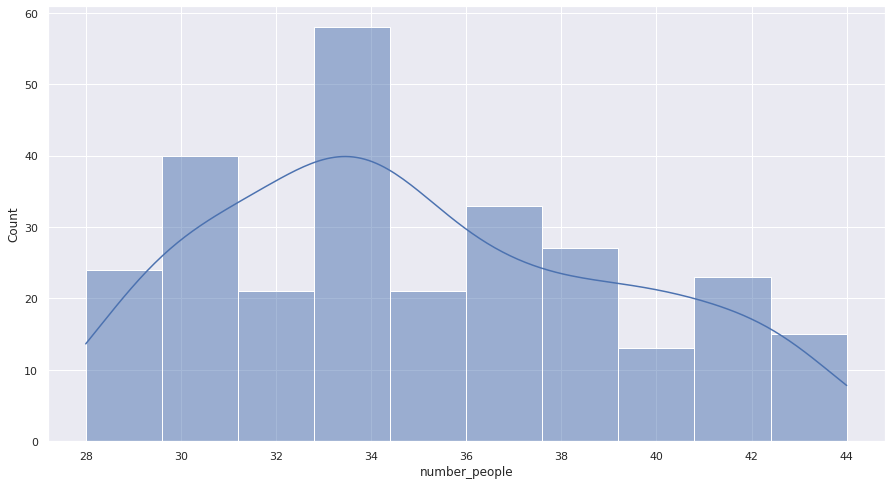

In [63]:
sns.set_style('darkgrid')
sns.set(rc={"figure.figsize":(15, 8)}) 
sns.histplot(data = videoresults_df, x = "number_people", kde=True)

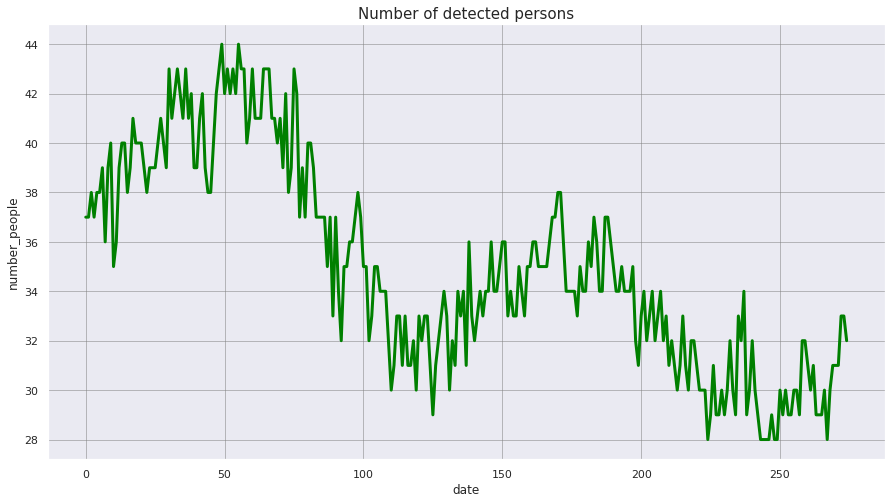

In [64]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.figure(figsize = (15, 8))
plt.plot(videoresults_df['number_people'], 
         label='Number of persons', color='green', linewidth = 3)

plt.xlabel('date', fontsize = 12)
plt.ylabel('number_people', fontsize = 12)
plt.title('Number of detected persons', fontsize = 15)
plt.grid(color='gray', linestyle='-', linewidth = 0.5)
plt.savefig("reports/persons_plot.png", dpi = 300)
plt.show()

### Exporting metrics

In [65]:
EXCELFILE = 'reports/videometrics.xls'
CSVFILE = 'reports/videometrics.csv'

In [66]:
videoresults_df.to_excel(EXCELFILE, index = False, sheet_name = "predictions") # Excel export
videoresults_df.to_csv(CSVFILE, index = False) # CSV export

In [67]:
for item in os.scandir('reports'):
     print(ts_to_dt(item.stat().st_atime), item.stat().st_size, item.name)

2022-01-25 12:25:10.702321 65275 density.png
2022-01-25 12:25:15.997226 354730 persons_plot.png
2022-01-25 12:25:16.978653 16220 videometrics.csv
2022-01-25 12:25:16.891704 34304 videometrics.xls


In [68]:
from IPython.display import FileLink
xls_link = FileLink(path = EXCELFILE)
print("Link to download the Excel file:")
xls_link

Link to download the Excel file:


/mnt/batch/tasks/shared/LS_root/mounts/clusters/seretkow5/code/Users/seretkow/ComputerVision/People Counting and Tracking/reports/videometrics.xls

In [69]:
csv_link = FileLink(path = CSVFILE)
print("Link to download the CSV file:")
csv_link

Link to download the CSV file:


/mnt/batch/tasks/shared/LS_root/mounts/clusters/seretkow5/code/Users/seretkow/ComputerVision/People Counting and Tracking/reports/videometrics.csv

### Saving the processed frames into a new video

In [70]:
results_path = 'results' # input images dir
video_output = 'processed_video_crowd.mp4' # Should be an MP4 file

In [71]:
output_path = 'videoresults' # dir to save the video
createdir(output_path) # create the dir

Creating directory: videoresults
Done!


In [72]:
import moviepy.video.io.ImageSequenceClip
image_folder = 'results' # Images to saved into a video file

fps_output = fps # FPS for the video to generate

video_outputfilename = output_path + '/' + video_output # result video file
t1 = datetime.datetime.now()
print(t1, "Building video file:", video_outputfilename, '\n')
image_files = [os.path.join(image_folder, img)
               for img in os.listdir(image_folder)
               if img.endswith(".jpg")]

clip = moviepy.video.io.ImageSequenceClip.ImageSequenceClip(image_files, fps = fps_output)
print(datetime.datetime.now(), "Writing video file...")
clip.write_videofile(video_outputfilename)

print('\nDone in', datetime.datetime.now() - t1)

2022-01-25 12:25:21.662534 Building video file: videoresults/processed_video_crowd.mp4 

2022-01-25 12:25:47.860113 Writing video file...
Moviepy - Building video videoresults/processed_video_crowd.mp4.
Moviepy - Writing video videoresults/processed_video_crowd.mp4



Moviepy - Done !
Moviepy - video ready videoresults/processed_video_crowd.mp4

Done in 0:00:52.912912


In [73]:
for item in os.scandir(output_path):
     print(ts_to_dt(item.stat().st_atime), item.stat().st_size, item.name)

2022-01-25 12:26:14.510105 12156405 processed_video_crowd.mp4


In [2]:
# Viewing the video output
#videoresult = VideoFileClip(video_outputfilename)
#videoresult.ipython_display(width = 640, height = 480)

In [75]:
from IPython.display import FileLink

video_link = FileLink(path = video_outputfilename)
print("Link to download the video file:")
video_link

Link to download the video file:


/mnt/batch/tasks/shared/LS_root/mounts/clusters/seretkow5/code/Users/seretkow/ComputerVision/People Counting and Tracking/videoresults/processed_video_crowd.mp4

> End